# 现代控制理论与技术大作业 · 数据处理脚本

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import loadmat
from scipy.signal import welch
from scipy.integrate import simpson

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import control as ct

import plotly.io as pio
pio.renderers.default = "browser"
import plotly.graph_objects as go
import plotly.express as px

import ysy_mamplot as mb

### 辅助函数

In [2]:
def iplot(
    x,
    y,
    legend_name,
    plot_title: str = '',
    x_label: str = 'X',
    y_label: str = 'Y',
    plot_type: str = 'curve',
    legend_title: str = '',
    return_fig: bool = True,
    show: bool = False,
):
    """
    Plotly 实现的标准绘图函数，使用前请导入：`import plotly.graph_objects as go`。

    参数：
        x : array-like
        y : array-like 或多个 y 的元组/列表
        legend_name : str 或 str 列表
        plot_title : 图标题
        x_label : X轴标签
        y_label : Y轴标签
        plot_type : 'curve' 或 'scatter'
        legend_title : 图例标题
        return_fig : bool, default True
            如果为 True，则返回 `plotly.graph_objects.Figure`；否则返回 None。

    说明（与原实现保持一致的要点与仅有改动）
    ----------------------------------------
    - 模板固定为 'plotly_white'（不参与任何自定义样式加载/注册）。
    - 多曲线判定：仅依据 `isinstance(y, (list, tuple))`。
    - 不提供导出功能（无文件保存）。
    """
    fig = go.Figure()

    # 多条曲线情况（按要求：仅判断 y 是否为 list/tuple）
    if isinstance(y, (list, tuple)):
        for i, yi in enumerate(y):
            name = legend_name[i] if isinstance(legend_name, (list, tuple)) else f'Line {i}'
            mode = 'lines' if plot_type == 'curve' else 'markers'
            fig.add_trace(go.Scatter(
                x=x, y=yi, mode=mode, name=name,
                hovertemplate='x=%{x:.2f}<br>y=%{y:.2f}<extra></extra>'
            ))
    else:
        # 单条曲线
        mode = 'lines' if plot_type == 'curve' else 'markers'
        fig.add_trace(go.Scatter(
            x=x, y=y, mode=mode, name=legend_name,
            hovertemplate='x=%{x:.2f}<br>y=%{y:.2f}<extra></extra>'
        ))

    fig.update_layout(
        title=dict(text=plot_title, x=0.5, xanchor='center', font=dict(size=20)),
        xaxis=dict(title=dict(text=x_label, font=dict(size=16)), tickfont=dict(size=14)),
        yaxis=dict(title=dict(text=y_label, font=dict(size=16)), tickfont=dict(size=14)),
        legend=dict(title=dict(text=legend_title, font=dict(size=16)), font=dict(size=14)),
        template='plotly_white',   # 固定样式
        hovermode='closest'
    )
    if show:
        fig.show()
    return fig if return_fig else None

In [3]:
def compute_frf(
    t, u, y, *,
    fs=None,
    estimator="H1",          # "H1" (output-noise-robust) or "H2" (input-noise-robust)
    window="hann",
    nperseg=None,            # default: auto (power-of-two ~ 8–10 segments)
    noverlap=None,           # default: 50%
    detrend="constant",      # remove DC per-segment by default
    remove_dc=True,          # only applied when detrend is False
    clip_coh=None            # e.g. 0.8 -> drop low-coherence points when returning FRF
):
    """
    Compute FRF H(f) between input u(t) and output y(t) using Welch/CSD.

    Returns a dict:
        fs: float
        f:  (Hz)      ndarray, one-sided frequency grid
        w:  (rad/s)   ndarray, 2*pi*f
        H:            ndarray, complex FRF (H1 or H2)
        gamma2:       ndarray, magnitude-squared coherence
        Suu, Syy, Syu: ndarrays, auto/cross PSDs (density)
        nperseg, noverlap: ints, Welch params actually used
        navg:          int, number of averaged segments (Welch)
        estimator:     str, "H1" or "H2"
        window:        str or tuple, window spec actually used

    Notes:
      - If sampling is slightly nonuniform (default tolerance 0.5% in dt),
        the signal is linearly resampled to a uniform grid with median dt.
        This is an approximation and may affect high-frequency content.
    """
    t = np.asarray(t, float)
    u = np.asarray(u, float)
    y = np.asarray(y, float)

    # ---- basic checks ----
    if t.ndim != 1 or u.ndim != 1 or y.ndim != 1:
        raise ValueError("t, u, y must be 1-D arrays.")
    if len(t) != len(u) or len(t) != len(y):
        raise ValueError("t, u, y must have the same length.")
    if len(t) < 4:
        raise ValueError("Too few samples.")

    # ---- (near-)uniform sampling check ----
    dt = np.diff(t)
    dt_med = float(np.median(dt))
    if not np.allclose(dt, dt_med, rtol=5e-3, atol=0.0):
        n = len(t)
        t_uni = t[0] + np.arange(n) * dt_med
        # linear interpolation; consider anti-alias filtering for stronger jitter
        u = np.interp(t_uni, t, u)
        y = np.interp(t_uni, t, y)
        t = t_uni
    if fs is None:
        fs = 1.0 / dt_med

    # ---- detrend option normalization ----
    # scipy expects 'constant'/'linear'/False or callable; avoid passing None
    if isinstance(detrend, bool) or detrend is None:
        detr_opt = 'constant' if detrend else False
    else:
        detr_opt = detrend

    # optional whole-record DC removal (skip if segment detrend is enabled)
    if remove_dc and detr_opt is False:
        u = u - u.mean()
        y = y - y.mean()

    # ---- Welch parameters (auto) ----
    n = len(t)
    if nperseg is None:
        # target ≈ n/8, round to power-of-two, clamp into [8, 16384] then ≤ n
        target = int(2 ** int(np.round(np.log2(max(n/8, 8)))))
        nperseg = min(max(8, target), min(16384, n))
    if noverlap is None:
        noverlap = nperseg // 2
    if not (0 <= noverlap < nperseg):
        raise ValueError(f"noverlap must satisfy 0 ≤ noverlap < nperseg (got {noverlap} vs {nperseg}).")

    # estimate number of averages used by Welch
    step = nperseg - noverlap
    navg = max(1, (n - noverlap) // step)

    # ---- Spectra ----
    f, Suu = signal.welch(u, fs=fs, window=window, nperseg=nperseg,
                          noverlap=noverlap, detrend=detr_opt, return_onesided=True)
    _, Syy = signal.welch(y, fs=fs, window=window, nperseg=nperseg,
                          noverlap=noverlap, detrend=detr_opt, return_onesided=True)
    _, Syu = signal.csd(y, u, fs=fs, window=window, nperseg=nperseg,
                        noverlap=noverlap, detrend=detr_opt, return_onesided=True)
    _, Suy = signal.csd(u, y, fs=fs, window=window, nperseg=nperseg,
                        noverlap=noverlap, detrend=detr_opt, return_onesided=True)

    # ---- FRF estimators ----
    # H1 = S_yu / S_uu  (robust to output noise)
    # H2 = S_yy / S_uy  (robust to input noise)  [note: csd(x,y)=S_xy]
    tiny = np.finfo(float).tiny
    if str(estimator).upper() == "H1":
        H = Syu / (Suu + tiny)
    elif str(estimator).upper() == "H2":
        H = Syy / (Suy + tiny)
    else:
        raise ValueError("estimator must be 'H1' or 'H2'.")

    # ---- coherence ----
    gamma2 = (np.abs(Syu) ** 2) / (Suu * Syy + tiny)
    gamma2 = np.clip(np.real_if_close(gamma2), 0.0, 1.0)

    # ---- optional coherence-based masking ----
    if clip_coh is not None:
        if not (0.0 <= clip_coh <= 1.0):
            raise ValueError("clip_coh must be in [0, 1].")
        mask = (f > 0.0) & (gamma2 >= clip_coh)
        f, H, gamma2, Suu, Syy, Syu = f[mask], H[mask], gamma2[mask], Suu[mask], Syy[mask], Syu[mask]
    else:
        # still drop DC for FRF/plots if desired; keep as-is here
        pass

    return {
        "fs": fs,
        "f": f,
        "w": 2.0 * np.pi * f,
        "H": H,
        "gamma2": gamma2,
        "Suu": Suu,
        "Syy": Syy,
        "Syu": Syu,
        "nperseg": nperseg,
        "noverlap": noverlap,
        "navg": int(navg),
        "estimator": str(estimator).upper(),
        "window": window,
    }

## LQG 效果分析

In [4]:
data_cl1 = pd.read_csv('course_work_lqg_closeloop_simulink_sim_output_data_202512030002.csv')
data_cl1

t          y_VL          y_HL          y_VR          y_HR
0            0.0000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
1            0.0001 -8.523452e-09 -8.417516e-09  7.916858e-10  8.695818e-10
2            0.0002 -1.856103e-08 -1.844774e-08  7.860871e-09  7.840894e-09
3            0.0003 -2.872347e-08 -2.857036e-08  1.346191e-08  1.347322e-08
4            0.0004 -3.740242e-08 -3.713981e-08  2.158398e-08  2.166304e-08
...             ...           ...           ...           ...           ...
19999996  1999.9996 -9.692244e-07 -4.568836e-07 -3.153563e-08  4.922184e-07
19999997  1999.9997 -9.660260e-07 -4.505668e-07 -3.195930e-08  4.853966e-07
19999998  1999.9998 -9.608682e-07 -4.420172e-07 -2.890459e-08  4.823625e-07
19999999  1999.9999 -9.568556e-07 -4.347027e-07 -2.703375e-08  4.782186e-07
20000000  2000.0000 -9.497896e-07 -4.246913e-07 -2.358215e-08  4.757008e-07

[20000001 rows x 5 columns]

In [5]:
data_cl2 = pd.read_csv('course_work_lqg_closeloop_simulink_sim_output_data_202512031124.csv')
data_cl2

t          y_VL          y_HL          y_VR          y_HR  \
0            0.0000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
1            0.0001 -4.553308e-09 -4.116670e-09  9.658827e-10 -3.431265e-09   
2            0.0002 -9.450567e-09 -5.254264e-09  6.863930e-09 -5.352587e-09   
3            0.0003 -1.534938e-08 -6.227510e-09  1.233502e-08 -8.869628e-09   
4            0.0004 -2.096635e-08 -5.322031e-09  1.963499e-08 -1.015475e-08   
...             ...           ...           ...           ...           ...   
19999996  1999.9996 -3.815878e-07  8.591830e-08  3.709793e-07 -5.058341e-08   
19999997  1999.9997 -3.824994e-07  8.573431e-08  3.698948e-07 -5.090451e-08   
19999998  1999.9998 -3.815983e-07  8.832930e-08  3.709113e-07 -4.798395e-08   
19999999  1999.9999 -3.817074e-07  8.990528e-08  3.706355e-07 -4.638937e-08   
20000000  2000.0000 -3.801060e-07  9.366318e-08  3.711085e-07 -4.265371e-08   

                    ns  
0         0.000000e+00  
1         9.047781e-10  
2         7.994047e-09  
3         1.371517e-08  
4         2.203640e-08  
...                ...  
19999996  5.372490e-07  
19999997  5.362259e-07  
19999998  5.389573e-07  
19999999  5.404724e-07  
20000000  5.433618e-07  

[20000001 rows x 6 columns]

In [6]:
data_ol = pd.read_csv('course_work_openloop_simulink_sim_output_data_202512030037.csv')
data_ol

t          y_VL          y_HL          y_VR          y_HR  \
0            0.0000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
1            0.0001 -8.562659e-09 -8.451461e-09  7.943767e-10  9.035270e-10   
2            0.0002 -1.870825e-08 -1.859401e-08  7.884192e-09  7.987160e-09   
3            0.0003 -2.904982e-08 -2.891912e-08  1.351649e-08  1.382199e-08   
4            0.0004 -3.796819e-08 -3.778554e-08  2.168040e-08  2.230876e-08   
...             ...           ...           ...           ...           ...   
19999996  1999.9996  4.410560e-06  5.045117e-06  5.552312e-06 -5.009782e-06   
19999997  1999.9997  4.482603e-06  5.063770e-06  5.626089e-06 -5.028940e-06   
19999998  1999.9998  4.556683e-06  5.084712e-06  5.703382e-06 -5.044367e-06   
19999999  1999.9999  4.629687e-06  5.104475e-06  5.779531e-06 -5.060959e-06   
20000000  2000.0000  4.705823e-06  5.126992e-06  5.857306e-06 -5.075983e-06   

                    ns  
0         0.000000e+00  
1         9.047781e-10  
2         7.994047e-09  
3         1.371517e-08  
4         2.203640e-08  
...                ...  
19999996  5.372490e-07  
19999997  5.362259e-07  
19999998  5.389573e-07  
19999999  5.404724e-07  
20000000  5.433618e-07  

[20000001 rows x 6 columns]

In [7]:
t = data_cl1['t'].values

y_VL_c1 = data_cl1['y_VL'].values
y_HL_c1 = data_cl1['y_HL'].values
y_VL_c2 = data_cl2['y_VL'].values
y_HL_c2 = data_cl2['y_HL'].values
y_VL_o = data_ol['y_VL'].values
y_HL_o = data_ol['y_HL'].values

y_VR_c1 = data_cl1['y_VR'].values
y_HR_c1 = data_cl1['y_HR'].values
y_VR_c2 = data_cl2['y_VR'].values
y_HR_c2 = data_cl2['y_HR'].values
y_VR_o = data_ol['y_VR'].values
y_HR_o = data_ol['y_HR'].values

ns = data_ol['ns'].values

In [8]:
dt = t[1] - t[0]
fs = 1/dt
T = np.max(t)
L = len(t)
Delta_f = 0.01
T_eff = 1/Delta_f
M = fs * T_eff
print('The Welch K: ', L/M)

The Welch K:  20.000001


In [ ]:
f, P_VL_c1 = welch(y_VL_c1, fs=fs, nperseg=M)
_, P_HL_c1 = welch(y_HL_c1, fs=fs, nperseg=M)
_, P_VL_c2 = welch(y_VL_c2, fs=fs, nperseg=M)
_, P_HL_c2 = welch(y_HL_c2, fs=fs, nperseg=M)
_, P_VL_o = welch(y_VL_o, fs=fs, nperseg=M)
_, P_HL_o = welch(y_HL_o, fs=fs, nperseg=M)
_, P_VR_c1 = welch(y_VR_c1, fs=fs, nperseg=M)
# _, P_HR_c1 = welch(y_HR_c1, fs=fs, nperseg=M)
_, P_VR_c2 = welch(y_VR_c2, fs=fs, nperseg=M)
# _, P_HR_c2 = welch(y_HR_c2, fs=fs, nperseg=M)
_, P_VR_o = welch(y_VR_o, fs=fs, nperseg=M)
# _, P_HR_o = welch(y_HR_o, fs=fs, nperseg=M)
_, P_ns = welch(ns, fs=fs, nperseg=M)

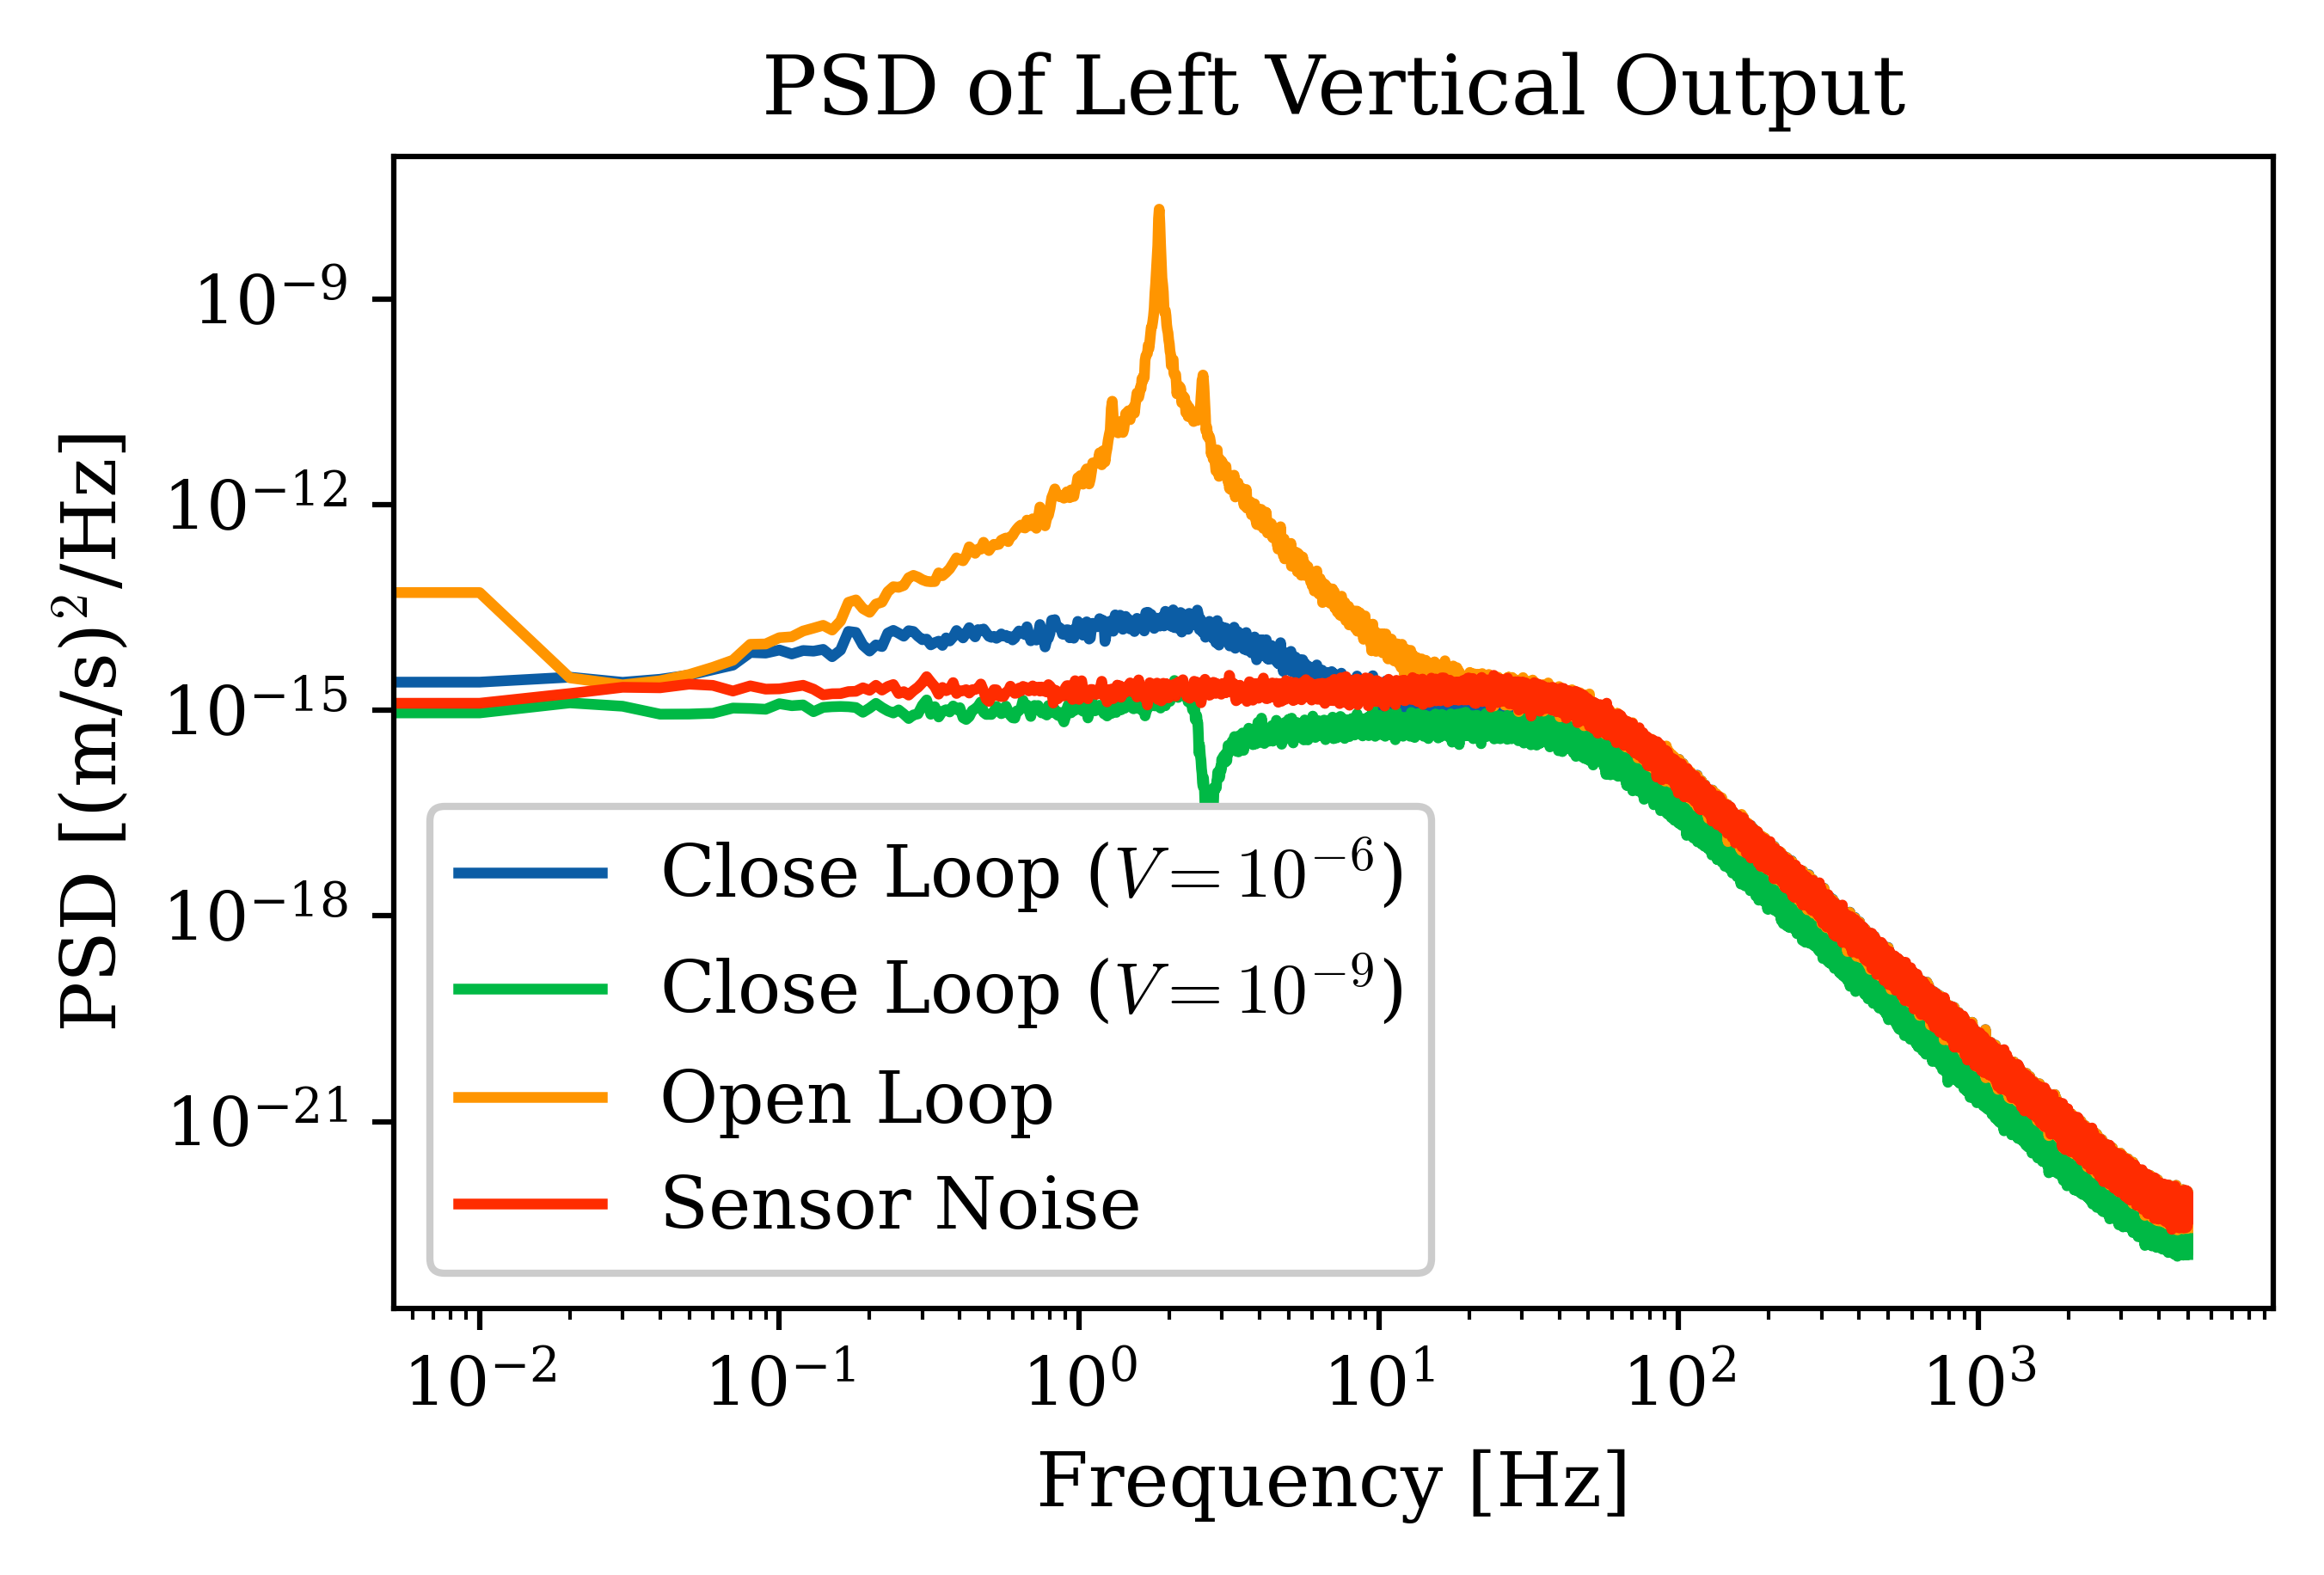

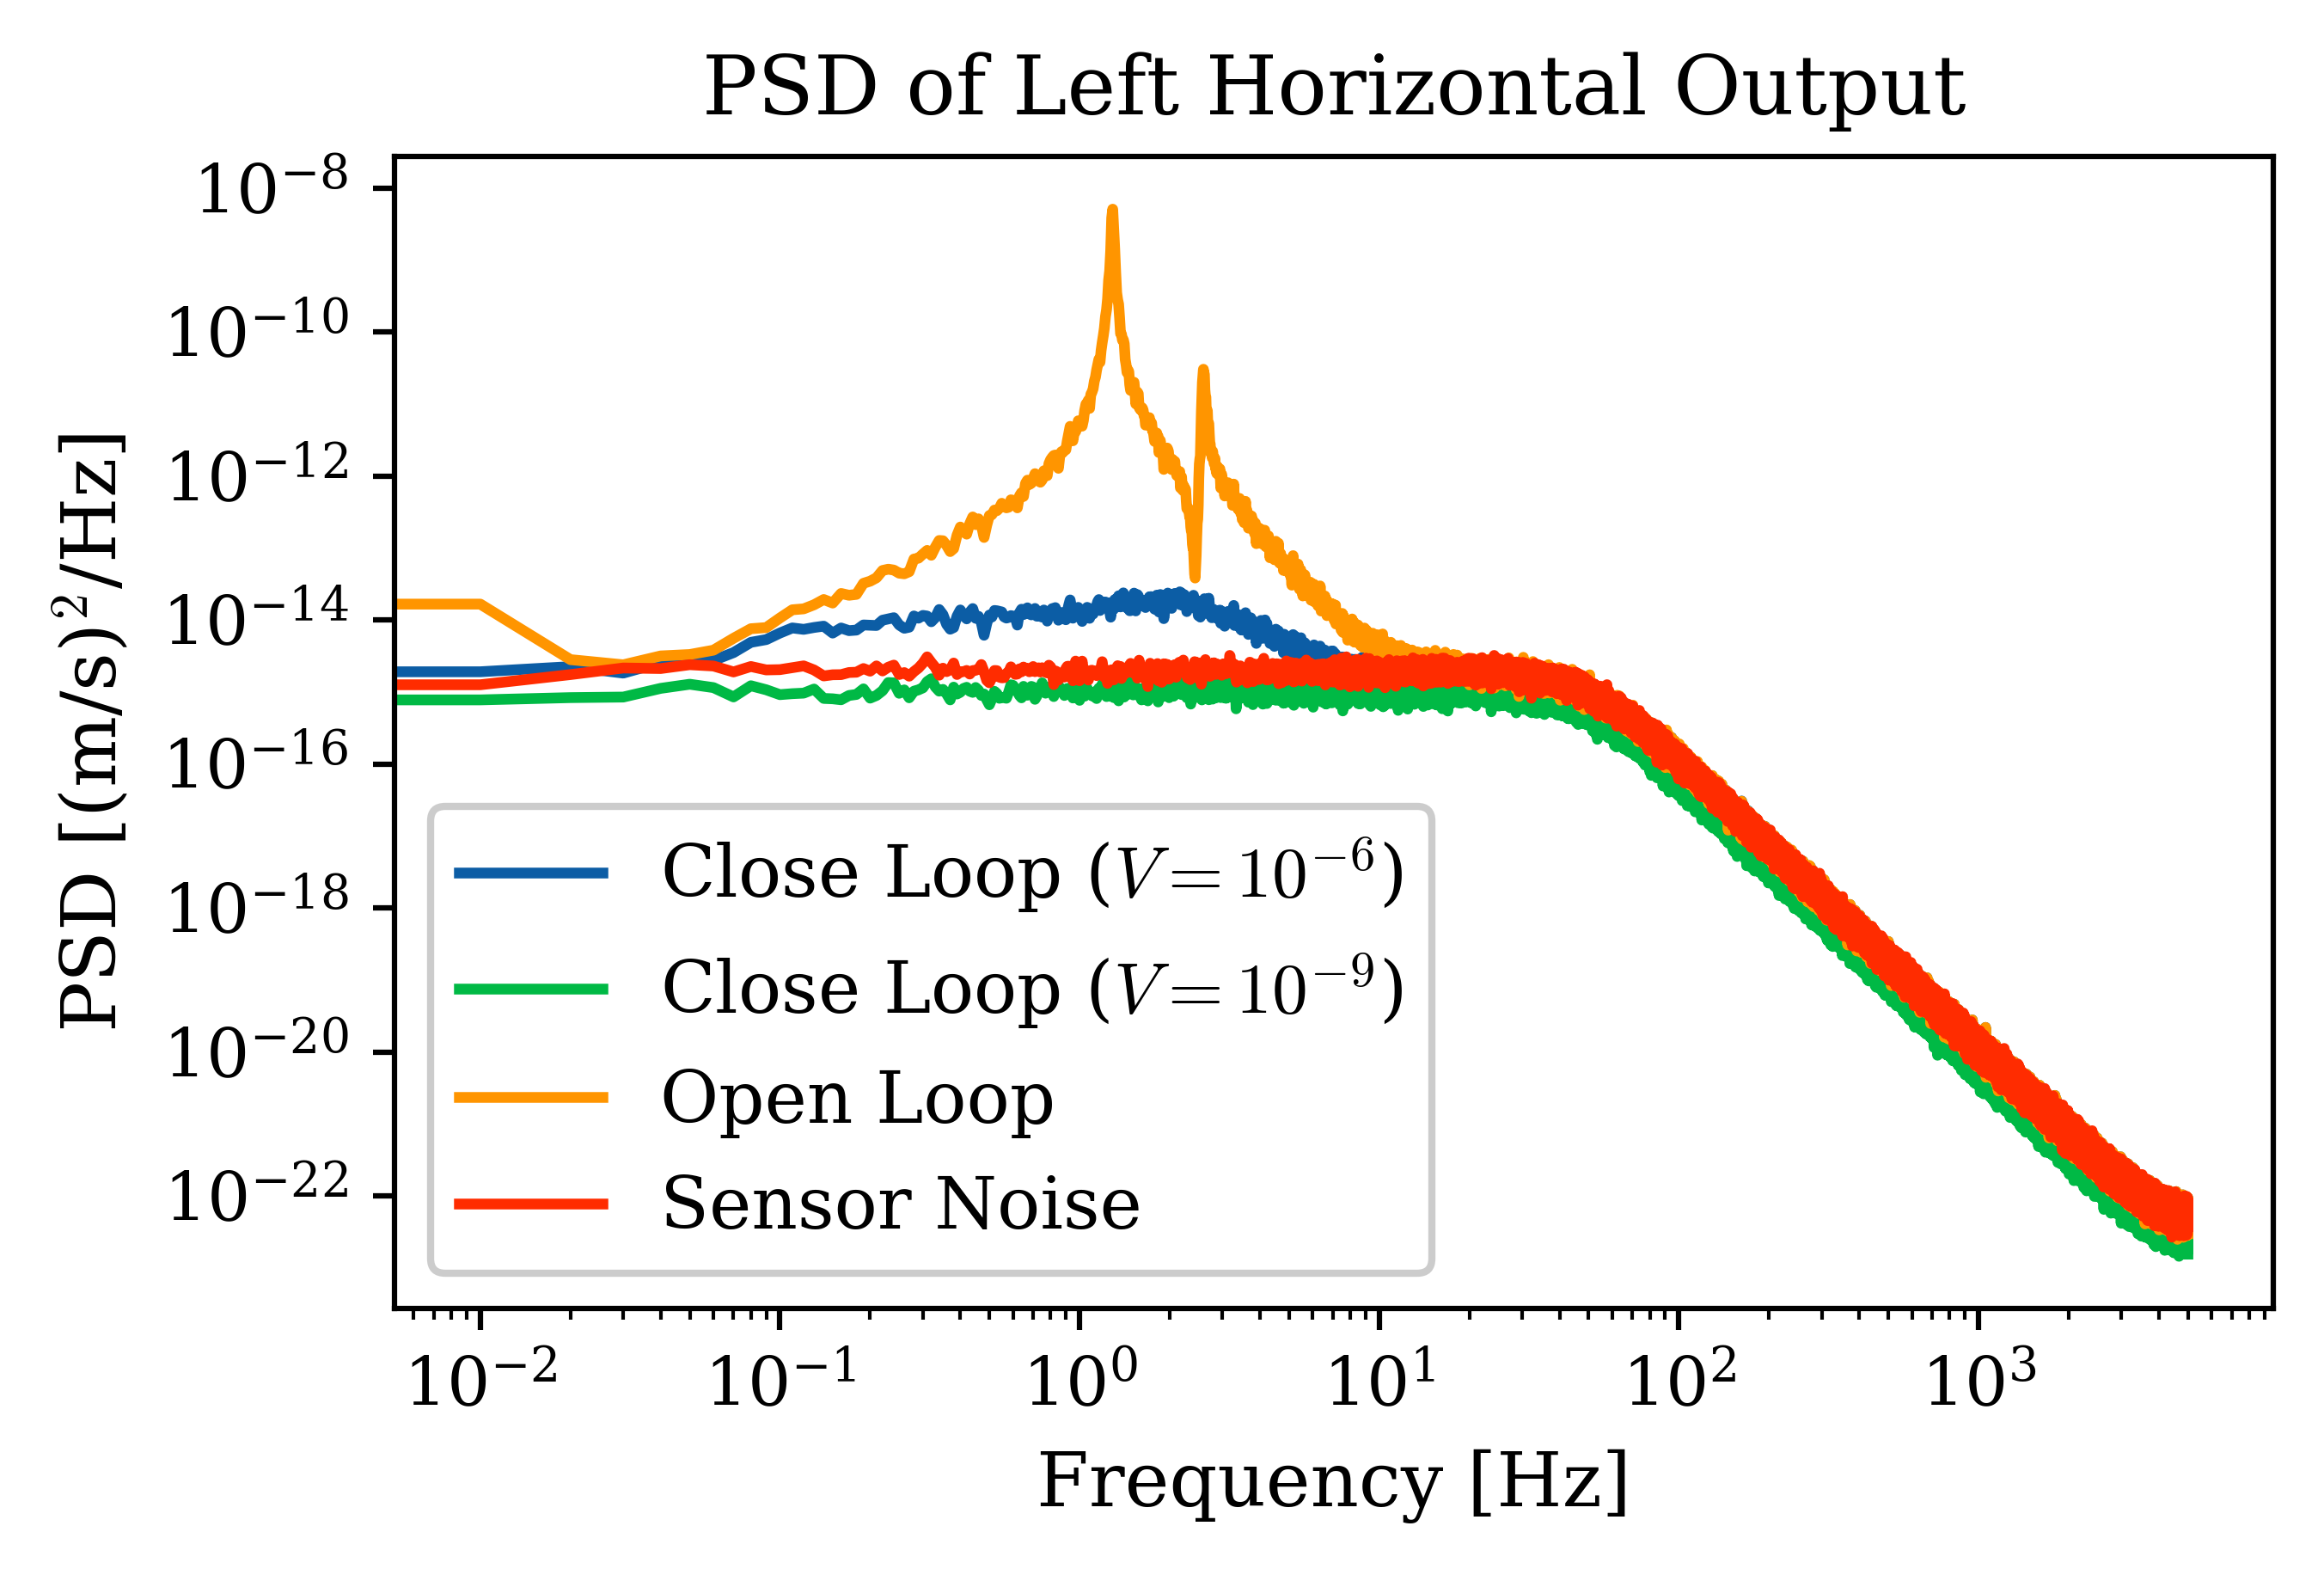

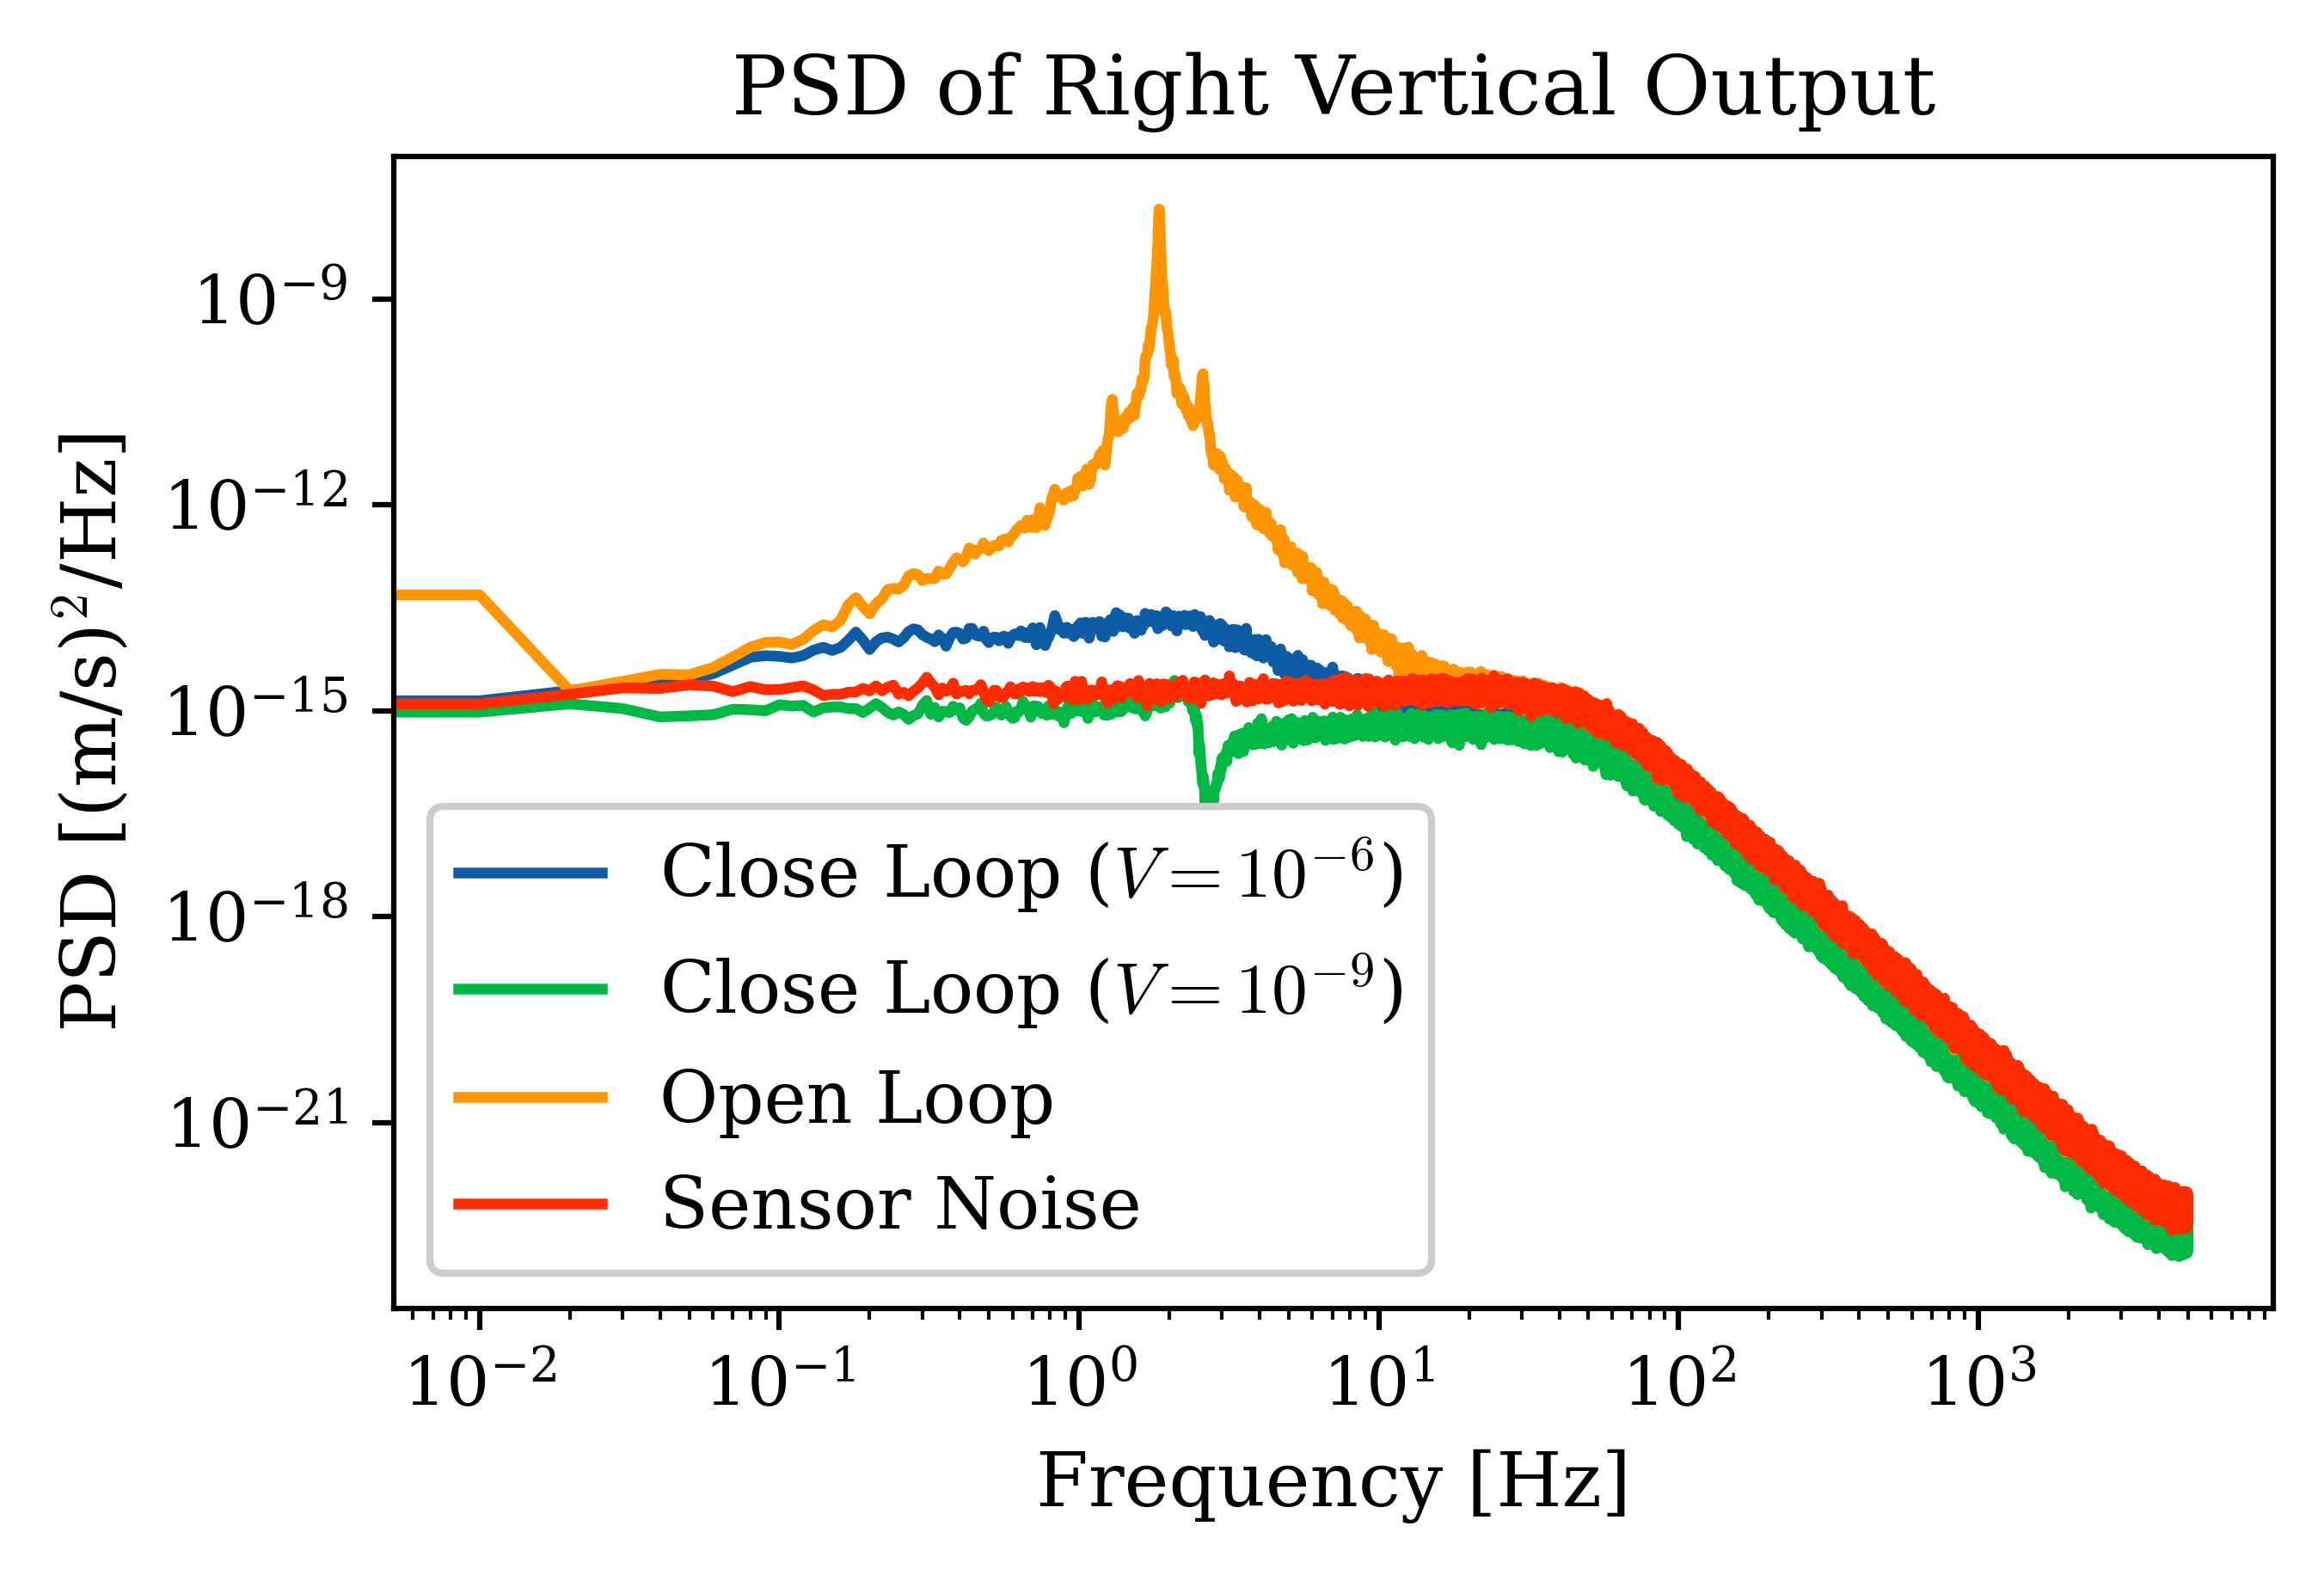

In [17]:
mb.mamplot(
    f, (P_VL_c1, P_VL_c2, P_VL_o, P_ns), 
    ('Close Loop ($V=10^{-6}$)', 'Close Loop ($V=10^{-9}$)', 'Open Loop', 'Sensor Noise'), 
    'PSD of Left Vertical Output',
    'Frequency [Hz]', 'PSD [(m/s)$^2$/Hz]',
    xlog=True, ylog=True, svg_save=True, legend_out=False
)

mb.mamplot(
    f, (P_HL_c1, P_HL_c2, P_HL_o, P_ns), 
    ('Close Loop ($V=10^{-6}$)', 'Close Loop ($V=10^{-9}$)', 'Open Loop', 'Sensor Noise'), 
    'PSD of Left Horizontal Output',
    'Frequency [Hz]', 'PSD [(m/s)$^2$/Hz]',
    xlog=True, ylog=True, svg_save=True, legend_out=False
)

mb.mamplot(
    f, (P_VR_c1, P_VR_c2, P_VR_o, P_ns), 
    ('Close Loop ($V=10^{-6}$)', 'Close Loop ($V=10^{-9}$)', 'Open Loop', 'Sensor Noise'), 
    'PSD of Right Vertical Output',
    'Frequency [Hz]', 'PSD [(m/s)$^2$/Hz]',
    xlog=True, ylog=True, svg_save=True, legend_out=False
)

### 解耦

In [9]:
z_sum_c1 = (y_VL_c1 + y_VR_c1) / 2
z_diff_c1 = (y_VL_c1 - y_VR_c1) / 2

z_sum_c2 = (y_VL_c2 + y_VR_c2) / 2
z_diff_c2 = (y_VL_c2 - y_VR_c2) / 2
x_c2 = y_HL_c2

z_sum_o = (y_VL_o + y_VR_o) / 2
z_diff_o = (y_VL_o - y_VR_o) / 2
x_o = y_HL_o

In [10]:
f, P_sum_c1 = welch(z_sum_c1, fs=fs, nperseg=M)
_, P_sum_c2 = welch(z_sum_c2, fs=fs, nperseg=M)
_, P_sum_o = welch(z_sum_o, fs=fs, nperseg=M)

_, P_diff_c1 = welch(z_diff_c1, fs=fs, nperseg=M)
_, P_diff_c2 = welch(z_diff_c2, fs=fs, nperseg=M)
_, P_diff_o = welch(z_diff_o, fs=fs, nperseg=M)

_, P_x_c2 = welch(x_c2, fs=fs, nperseg=M)
_, P_x_o = welch(x_o, fs=fs, nperseg=M)

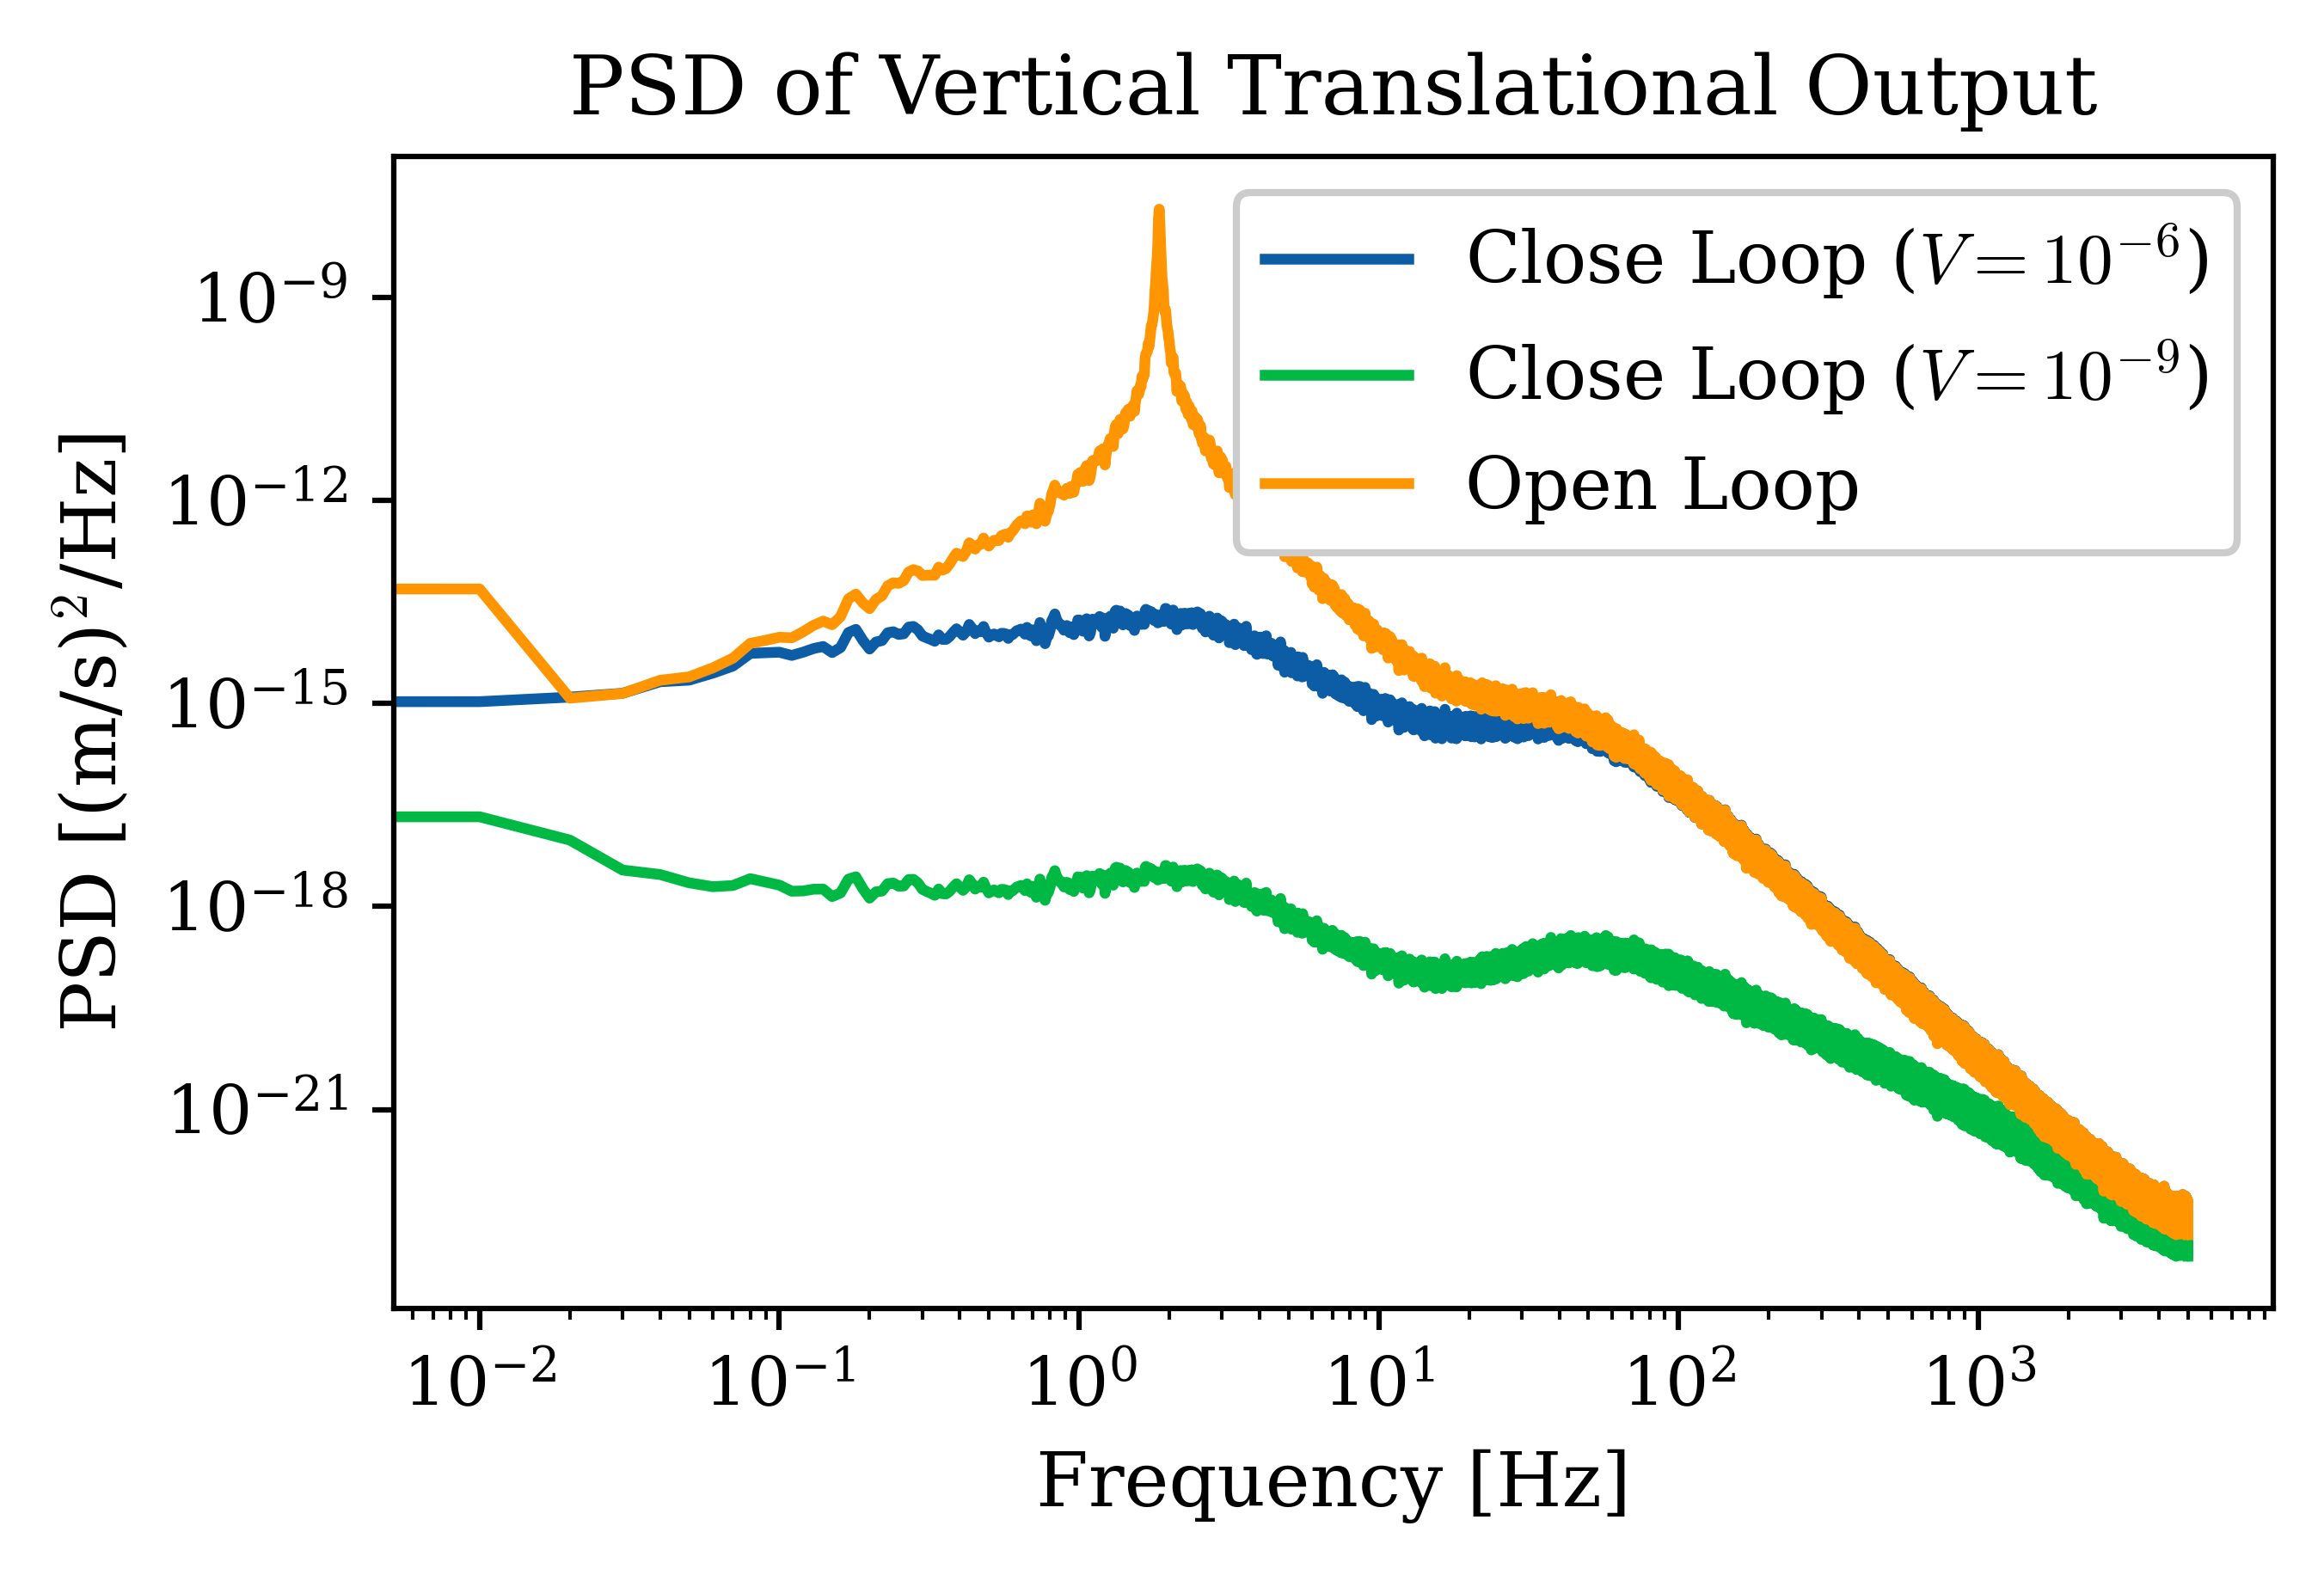

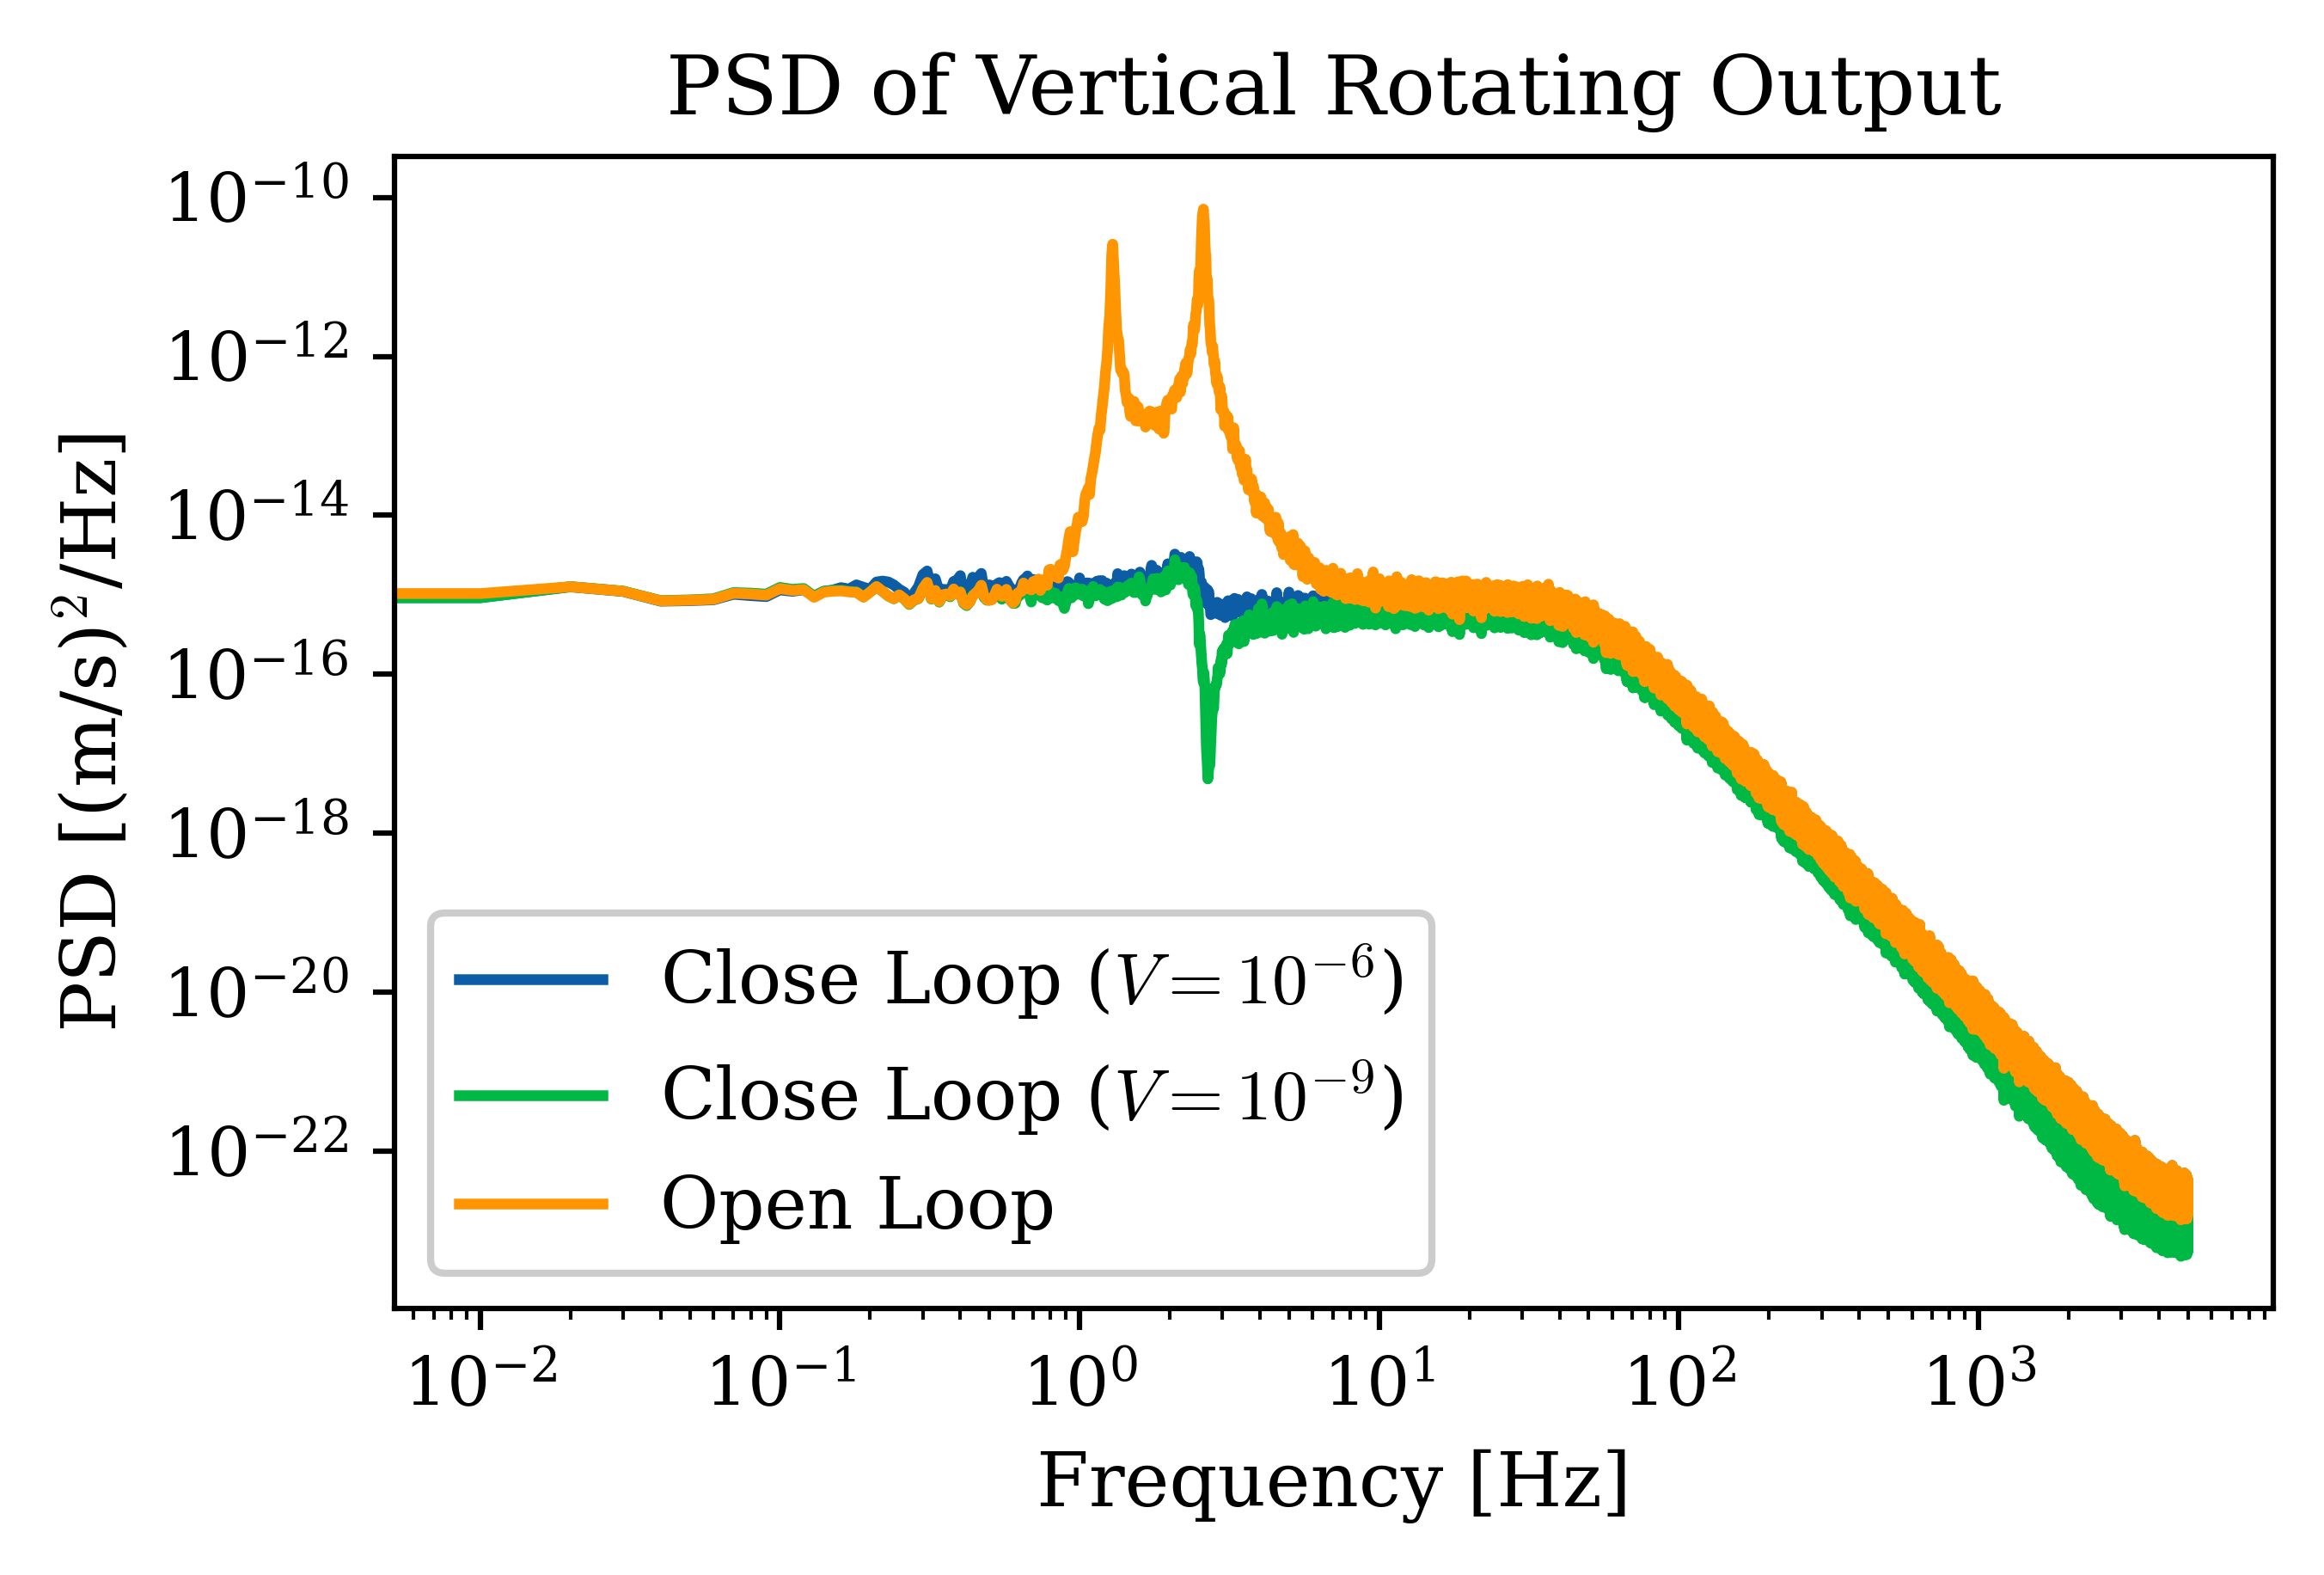

In [22]:
mb.mamplot(
    f, (P_sum_c1, P_sum_c2, P_sum_o), 
    ('Close Loop ($V=10^{-6}$)', 'Close Loop ($V=10^{-9}$)', 'Open Loop'), 
    'PSD of Vertical Translational Output',
    'Frequency [Hz]', 'PSD [(m/s)$^2$/Hz]',
    xlog=True, ylog=True, svg_save=True, legend_out=False
)

mb.mamplot(
    f, (P_diff_c1, P_diff_c2, P_diff_o), 
    ('Close Loop ($V=10^{-6}$)', 'Close Loop ($V=10^{-9}$)', 'Open Loop'), 
    'PSD of Vertical Rotating Output',
    'Frequency [Hz]', 'PSD [(m/s)$^2$/Hz]',
    xlog=True, ylog=True, svg_save=True, legend_out=False
)

### 驱动力

In [23]:
data_u = pd.read_csv('course_work_lqg_input_simulink_sim_output_data_202512031747.csv')
data_u

t      u_VL      u_HL      u_VR
0            0.0000  0.000000  0.000000  0.000000
1            0.0001 -0.000856  0.002037 -0.000135
2            0.0002 -0.000917  0.003988  0.000139
3            0.0003 -0.000744  0.003977 -0.000126
4            0.0004 -0.000511  0.004247  0.000094
...             ...       ...       ...       ...
19999996  1999.9996 -0.001470  0.000758 -0.001623
19999997  1999.9997 -0.001760  0.000264 -0.001883
19999998  1999.9998 -0.001628  0.000517 -0.001521
19999999  1999.9999 -0.001661  0.000538 -0.001556
20000000  2000.0000 -0.001329  0.000266 -0.001326

[20000001 rows x 4 columns]

In [24]:
t = data_u['t'].values

u_VL = data_u['u_VL'].values
u_HL = data_u['u_HL'].values
u_VR = data_u['u_VR'].values

dt = t[1] - t[0]
fs = 1/dt
T = np.max(t)
L = len(t)
Delta_f = 0.01
T_eff = 1/Delta_f
M = fs * T_eff
print('The Welch K: ', L/M)

The Welch K:  20.000001


In [25]:
f, P_VL_u = welch(u_VL, fs=fs, nperseg=M)
_, P_HL_u = welch(u_HL, fs=fs, nperseg=M)
_, P_VR_u = welch(u_VR, fs=fs, nperseg=M)

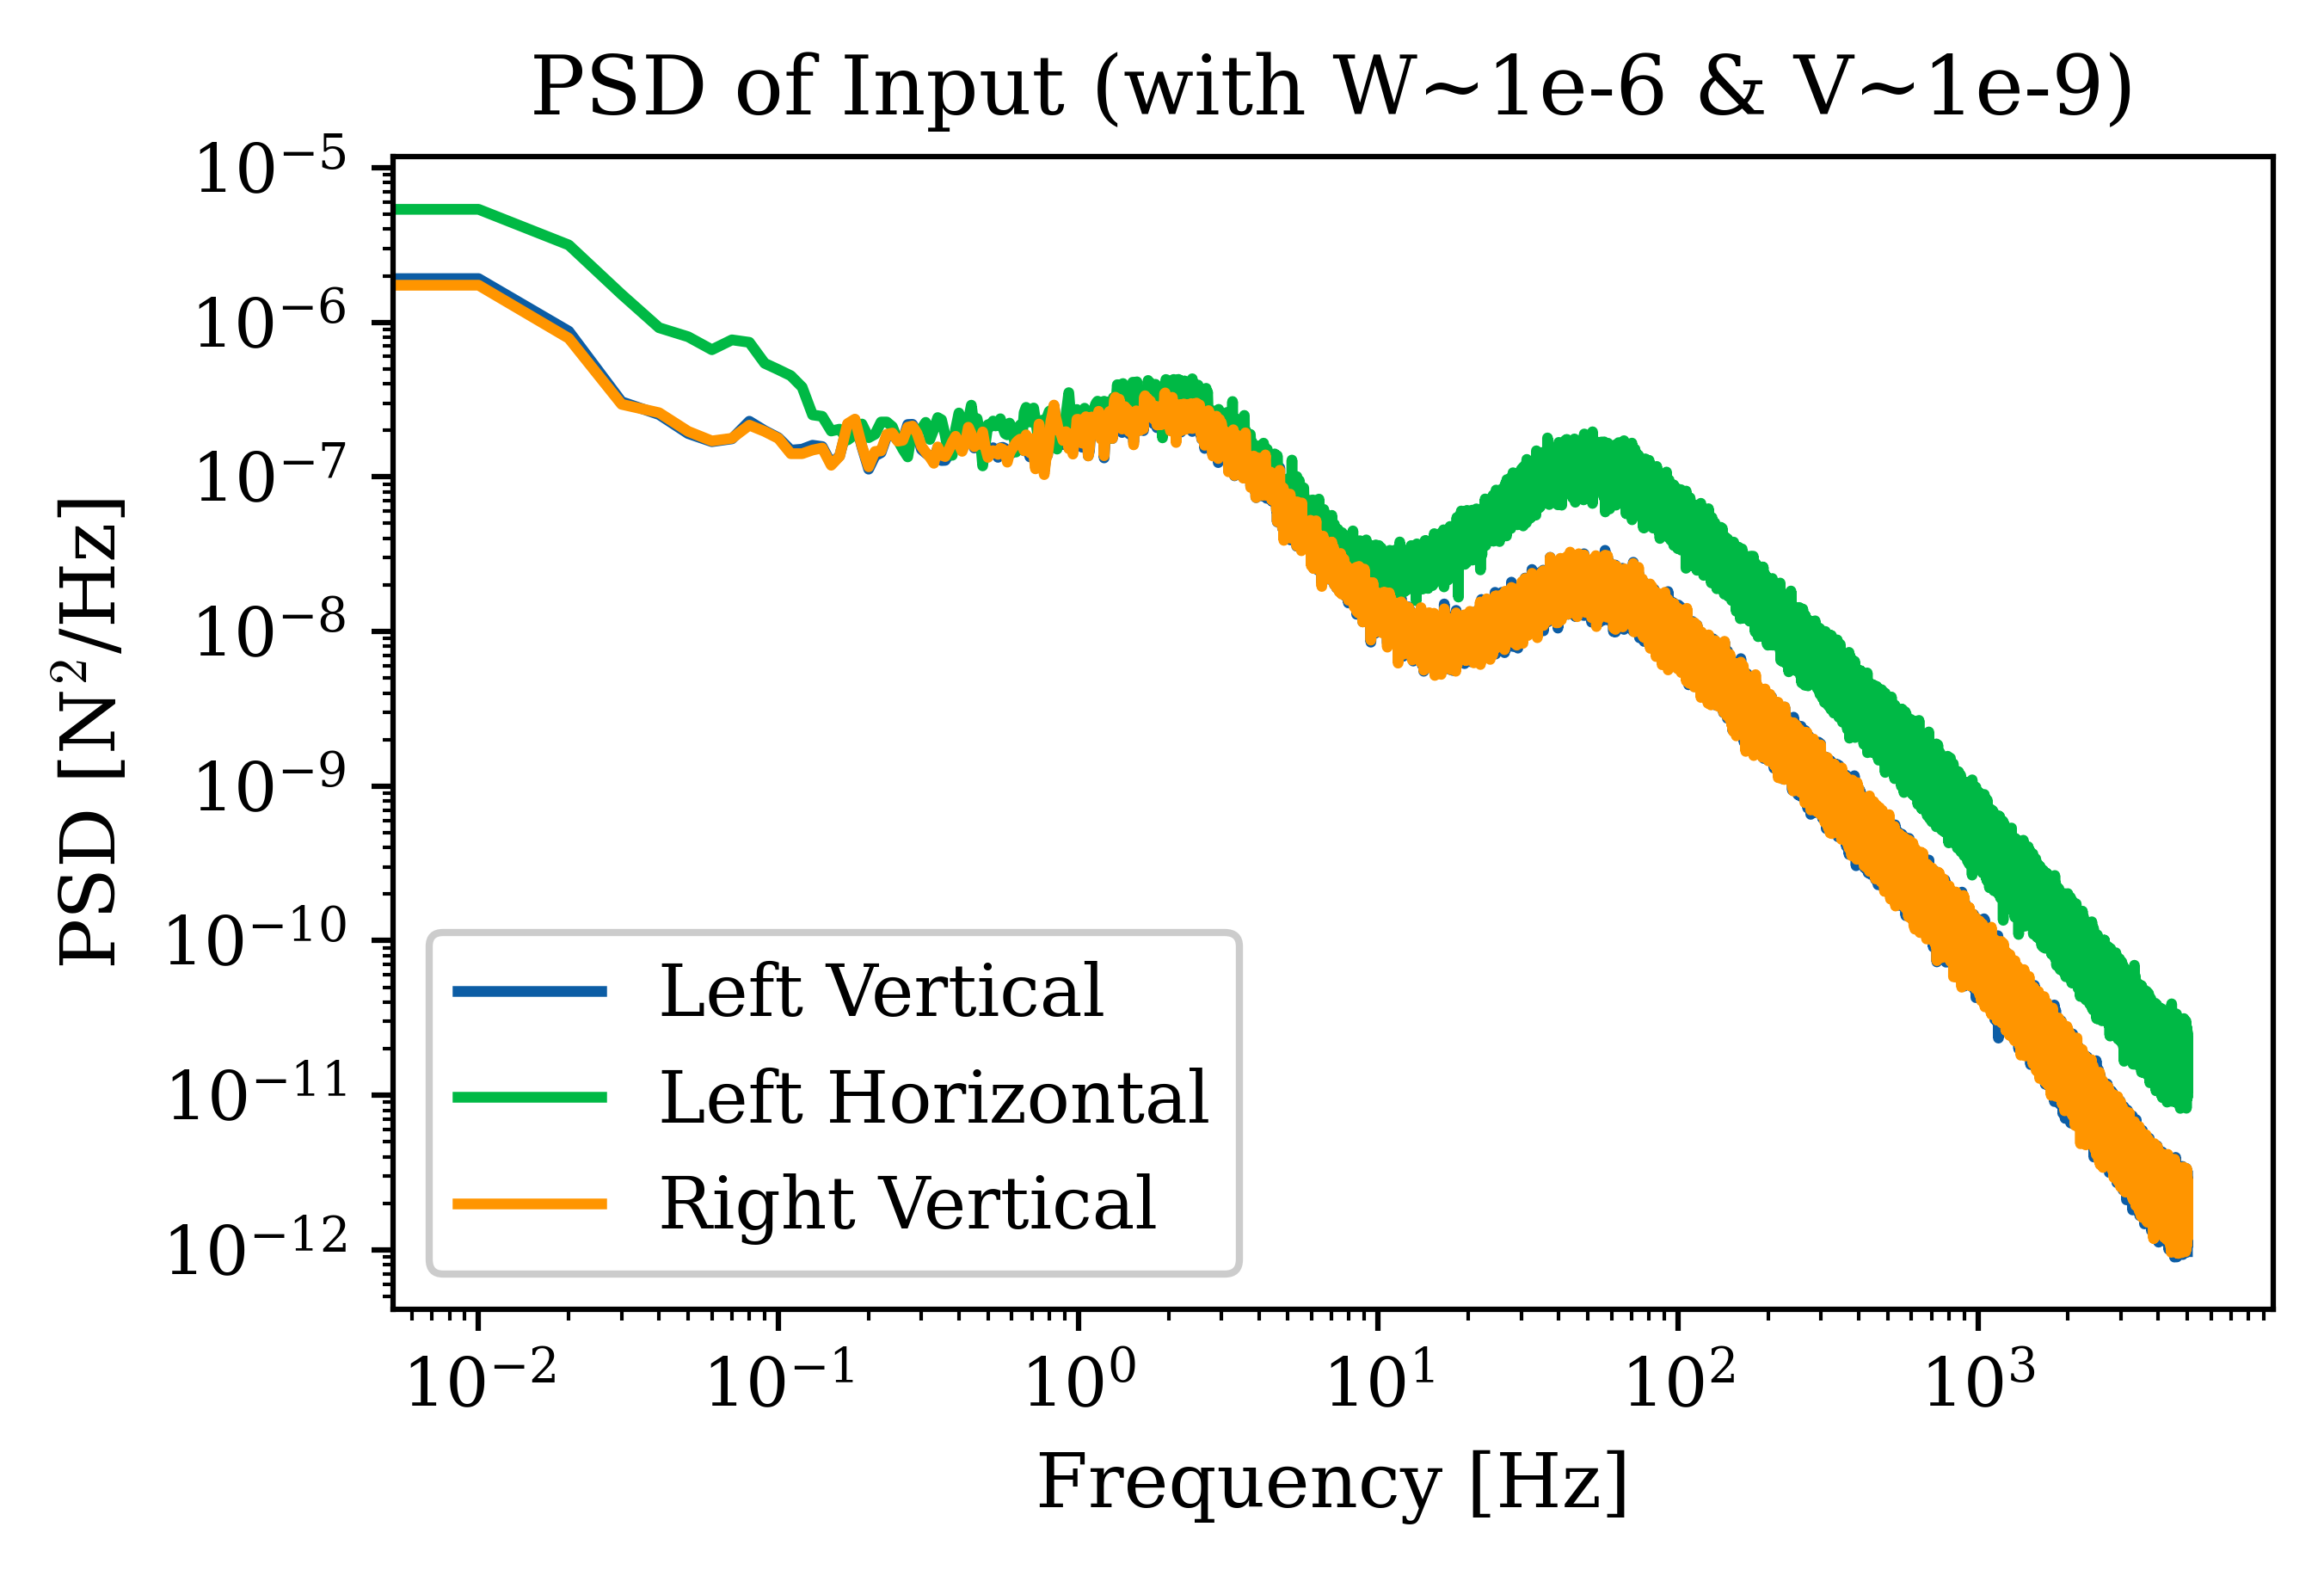

In [26]:
mb.mamplot(
    f, (P_VL_u, P_HL_u, P_VR_u), 
    ('Left Vertical', 'Left Horizontal', 'Right Vertical'), 
    'PSD of Input (with W~1e-6 & V~1e-9)',
    'Frequency [Hz]', 'PSD [N$^2$/Hz]',
    xlog=True, ylog=True, svg_save=True, legend_out=False
)

## SISO + IMC

In [11]:
data_si = pd.read_csv('course_work_siso_closeloop_simulink_sim_output_data_202512101318.csv')
data_si

t          y_VL          y_HL          y_VR          y_HR  \
0            0.000000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
1            0.000041 -7.527069e-10 -7.250981e-10  1.941527e-10 -4.560987e-11   
2            0.000073 -2.266610e-09 -1.926885e-09  6.791857e-10 -4.883684e-10   
3            0.000100 -4.225370e-09 -3.302980e-09  1.331379e-09 -1.270624e-09   
4            0.000129 -6.369608e-09 -4.687305e-09  2.689019e-09 -2.226670e-09   
...               ...           ...           ...           ...           ...   
79584863  1999.999900  2.107756e-07  2.015006e-08 -2.201822e-07  1.840779e-08   
79584864  1999.999927  2.115605e-07  2.061337e-08 -2.211984e-07  1.887187e-08   
79584865  1999.999954  2.126594e-07  2.131002e-08 -2.220258e-07  1.953814e-08   
79584866  1999.999982  2.140842e-07  2.227245e-08 -2.227548e-07  2.047062e-08   
79584867  2000.000000  2.149704e-07  2.302314e-08 -2.233416e-07  2.120578e-08   

                    ns  
0         0.000000e+00  
1         9.238550e-11  
2         2.895187e-10  
3         5.482423e-10  
4         1.178416e-09  
...                ...  
79584863  5.434470e-07  
79584864  5.438217e-07  
79584865  5.443487e-07  
79584866  5.450640e-07  
79584867  5.456178e-07  

[79584868 rows x 6 columns]

In [12]:
# 重采样
from scipy.interpolate import interp1d
fs = 10000
dt = 1.0 / fs
t_new = np.arange(0, 2000+dt, dt)

In [13]:
t = data_si['t'].values

f1 = interp1d(t, data_si['y_VL'].values, kind='linear')
y_VL_si = f1(t_new)
f2 = interp1d(t, data_si['y_HL'].values, kind='linear')
y_HL_si = f2(t_new)
f3 = interp1d(t, data_si['y_VR'].values, kind='linear')
y_VR_si = f3(t_new)

In [7]:
data_ol = pd.read_csv('course_work_openloop_simulink_sim_output_data_202512030037.csv')
data_ol

t          y_VL          y_HL          y_VR          y_HR  \
0            0.0000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
1            0.0001 -8.562659e-09 -8.451461e-09  7.943767e-10  9.035270e-10   
2            0.0002 -1.870825e-08 -1.859401e-08  7.884192e-09  7.987160e-09   
3            0.0003 -2.904982e-08 -2.891912e-08  1.351649e-08  1.382199e-08   
4            0.0004 -3.796819e-08 -3.778554e-08  2.168040e-08  2.230876e-08   
...             ...           ...           ...           ...           ...   
19999996  1999.9996  4.410560e-06  5.045117e-06  5.552312e-06 -5.009782e-06   
19999997  1999.9997  4.482603e-06  5.063770e-06  5.626089e-06 -5.028940e-06   
19999998  1999.9998  4.556683e-06  5.084712e-06  5.703382e-06 -5.044367e-06   
19999999  1999.9999  4.629687e-06  5.104475e-06  5.779531e-06 -5.060959e-06   
20000000  2000.0000  4.705823e-06  5.126992e-06  5.857306e-06 -5.075983e-06   

                    ns  
0         0.000000e+00  
1         9.047781e-10  
2         7.994047e-09  
3         1.371517e-08  
4         2.203640e-08  
...                ...  
19999996  5.372490e-07  
19999997  5.362259e-07  
19999998  5.389573e-07  
19999999  5.404724e-07  
20000000  5.433618e-07  

[20000001 rows x 6 columns]

In [8]:
y_VL_o = data_ol['y_VL'].values
y_HL_o = data_ol['y_HL'].values
y_VR_o = data_ol['y_VR'].values
y_HR_o = data_ol['y_HR'].values

ns = data_ol['ns'].values

### 解耦

In [14]:
z_sum_si = (y_VL_si + y_VR_si) / 2
z_diff_si = (y_VL_si - y_VR_si) / 2
x_si = y_HL_si

# z_sum_o = (y_VL_o + y_VR_o) / 2
# z_diff_o = (y_VL_o - y_VR_o) / 2
# x_o = y_HL_o

In [10]:
L = len(t_new)
Delta_f = 0.01
T_eff = 1/Delta_f
M = fs * T_eff
print('The Welch K: ', L/M)

The Welch K:  20.000001


In [15]:
f, P_sum_si = welch(z_sum_si, fs=fs, nperseg=M)
# _, P_sum_o = welch(z_sum_o, fs=fs, nperseg=M)

_, P_diff_si = welch(z_diff_si, fs=fs, nperseg=M)
# _, P_diff_o = welch(z_diff_o, fs=fs, nperseg=M)

_, P_x_si = welch(x_si, fs=fs, nperseg=M)
# _, P_x_o = welch(x_o, fs=fs, nperseg=M)

# _, P_ns = welch(ns, fs=fs, nperseg=M)

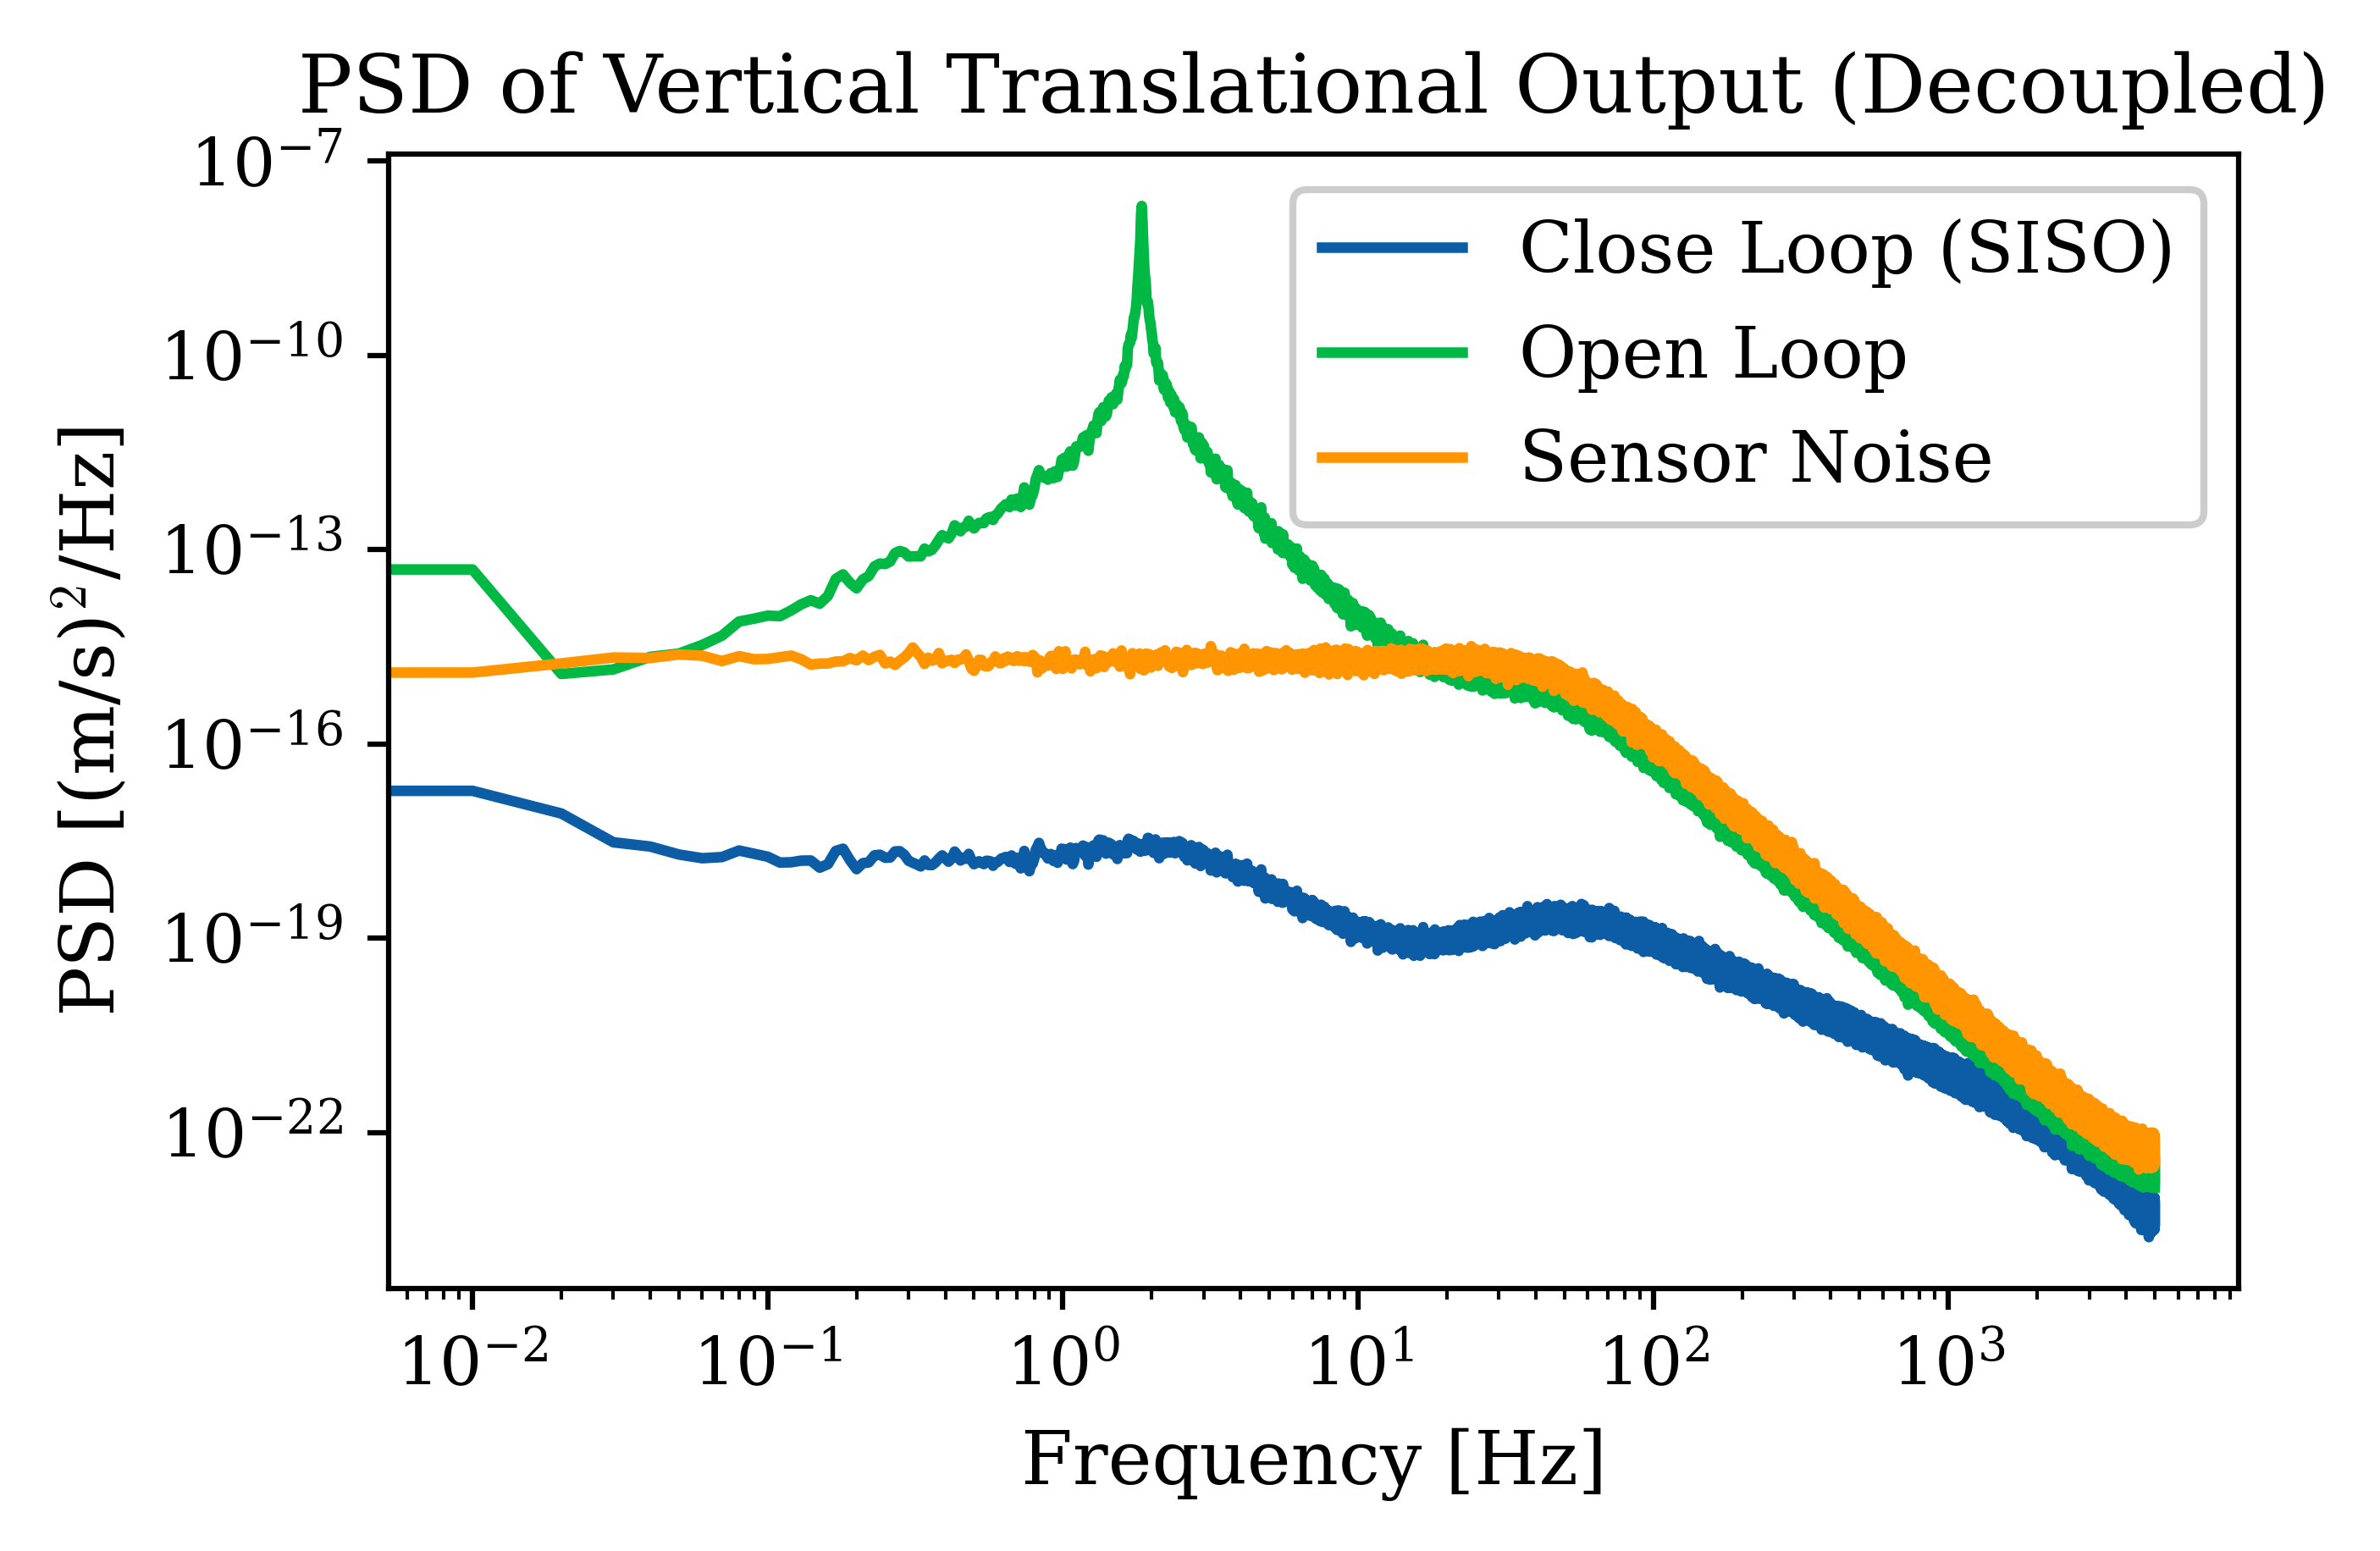

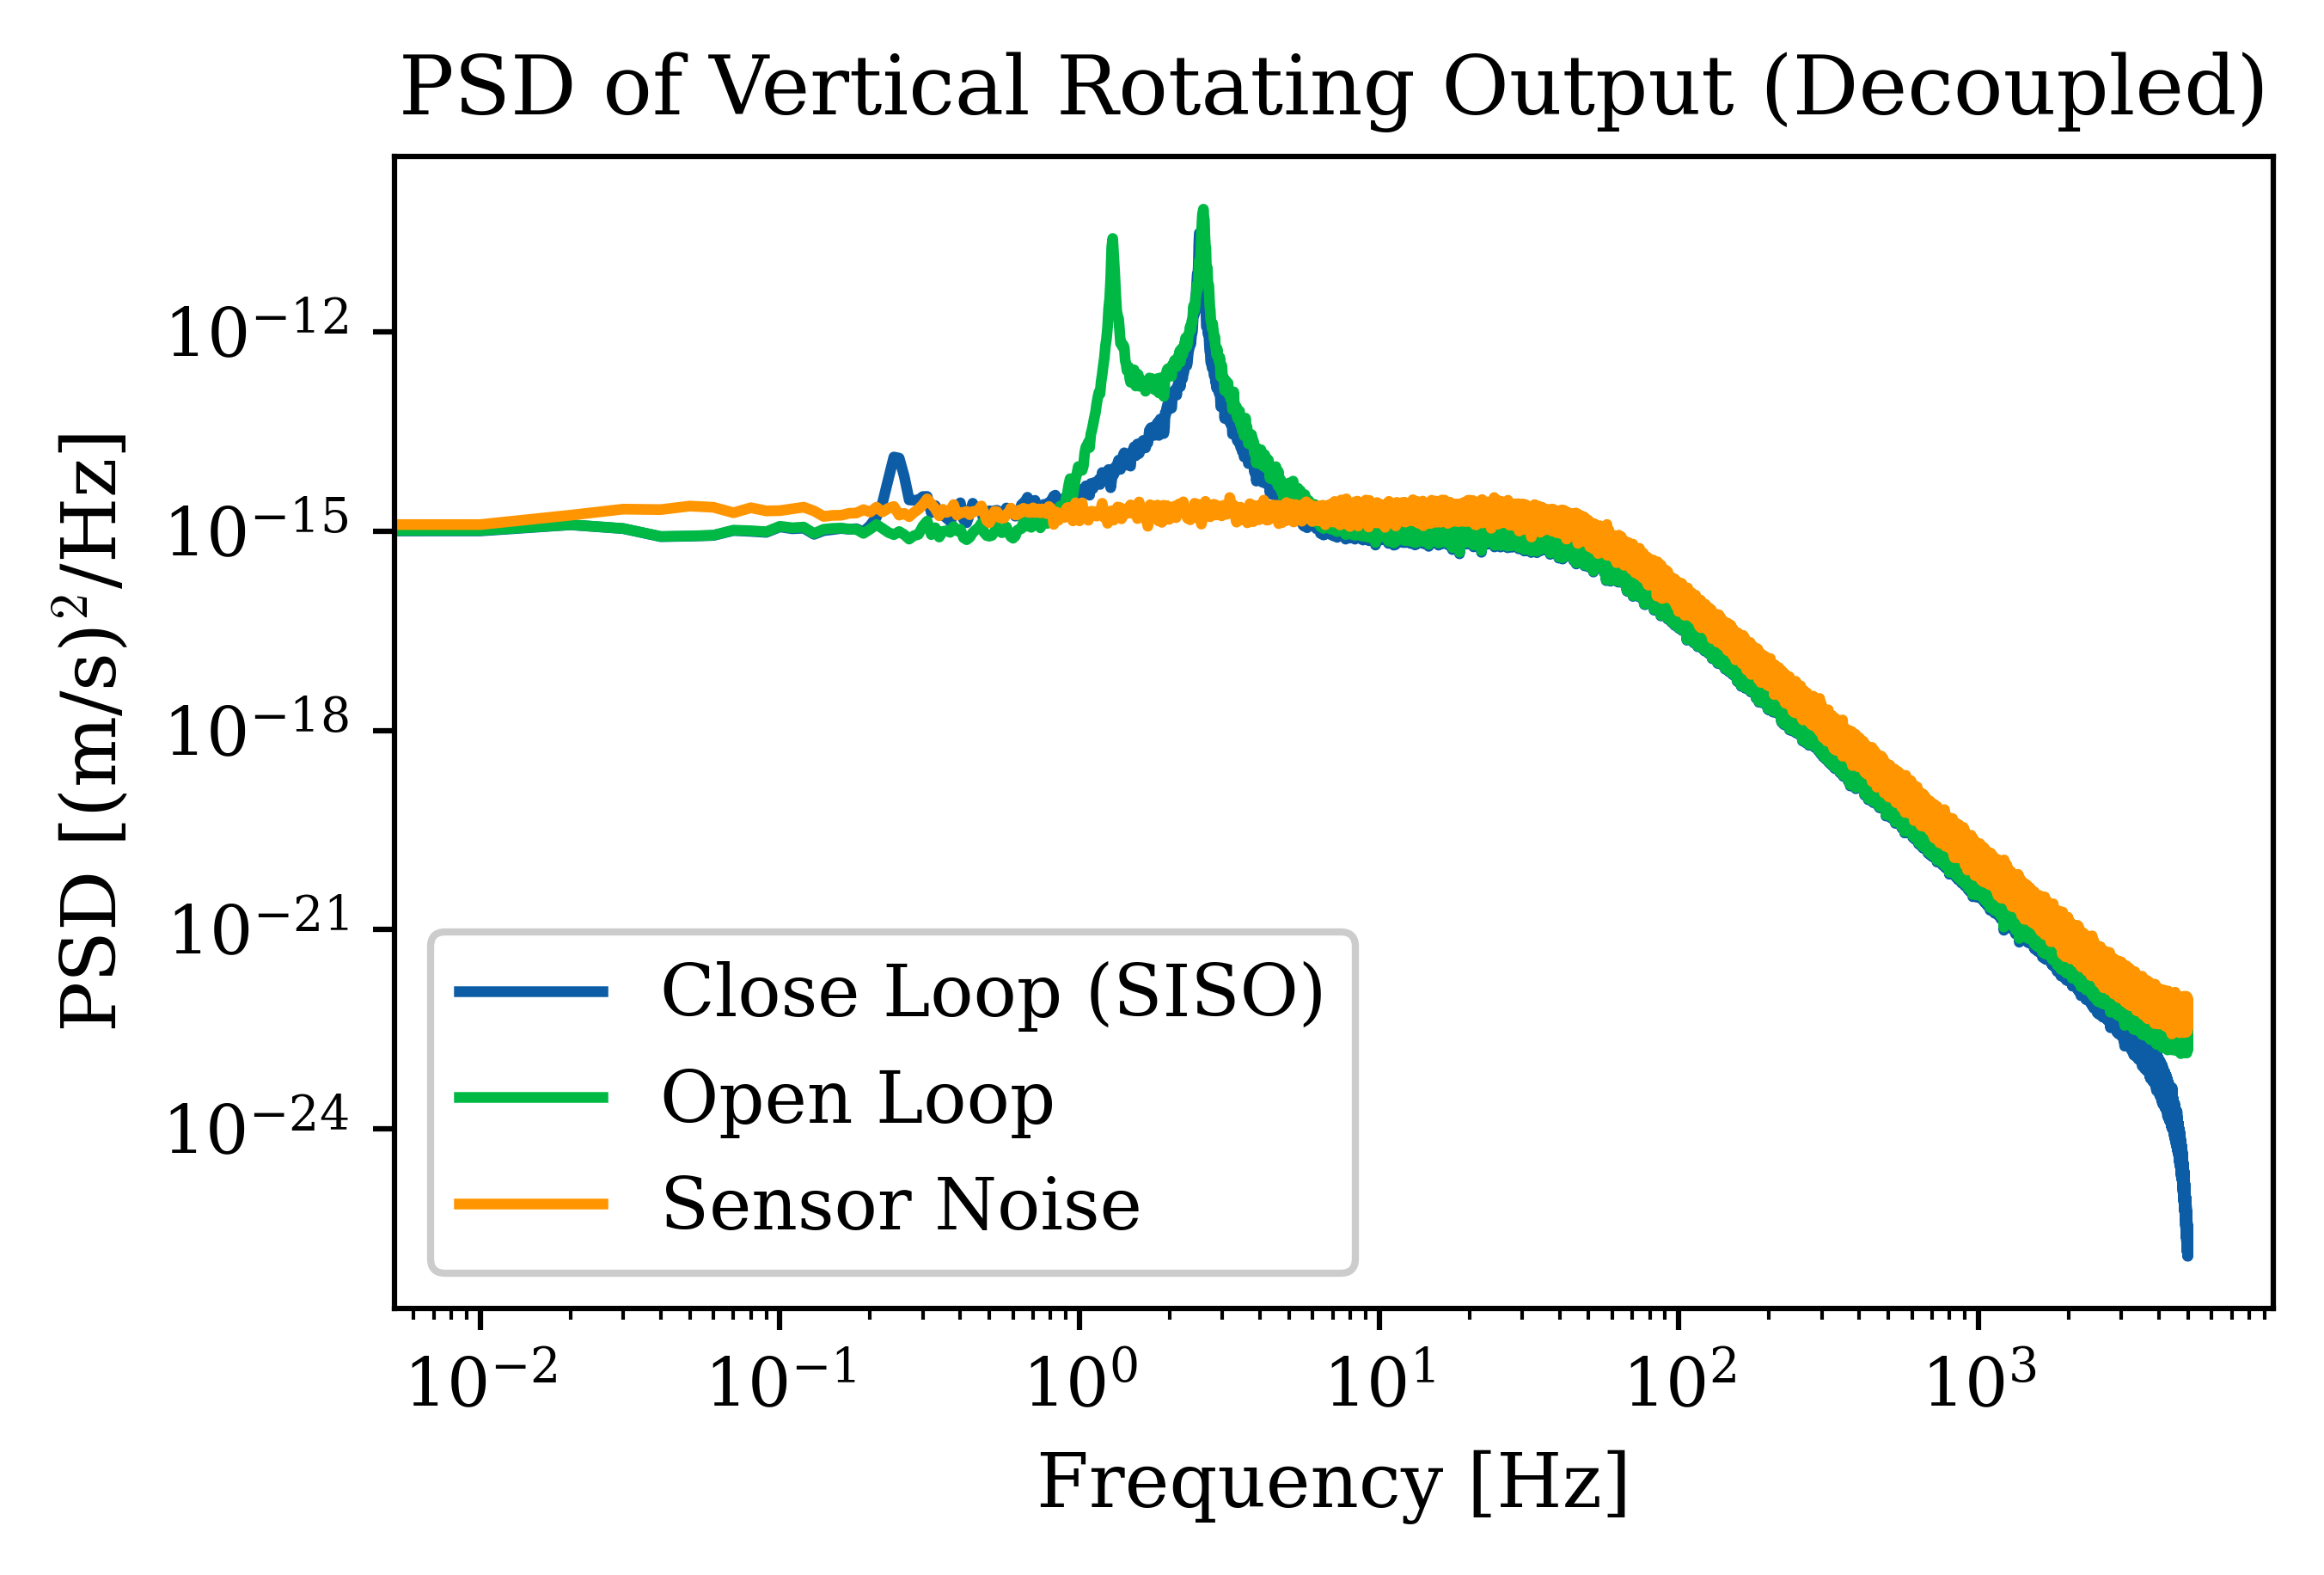

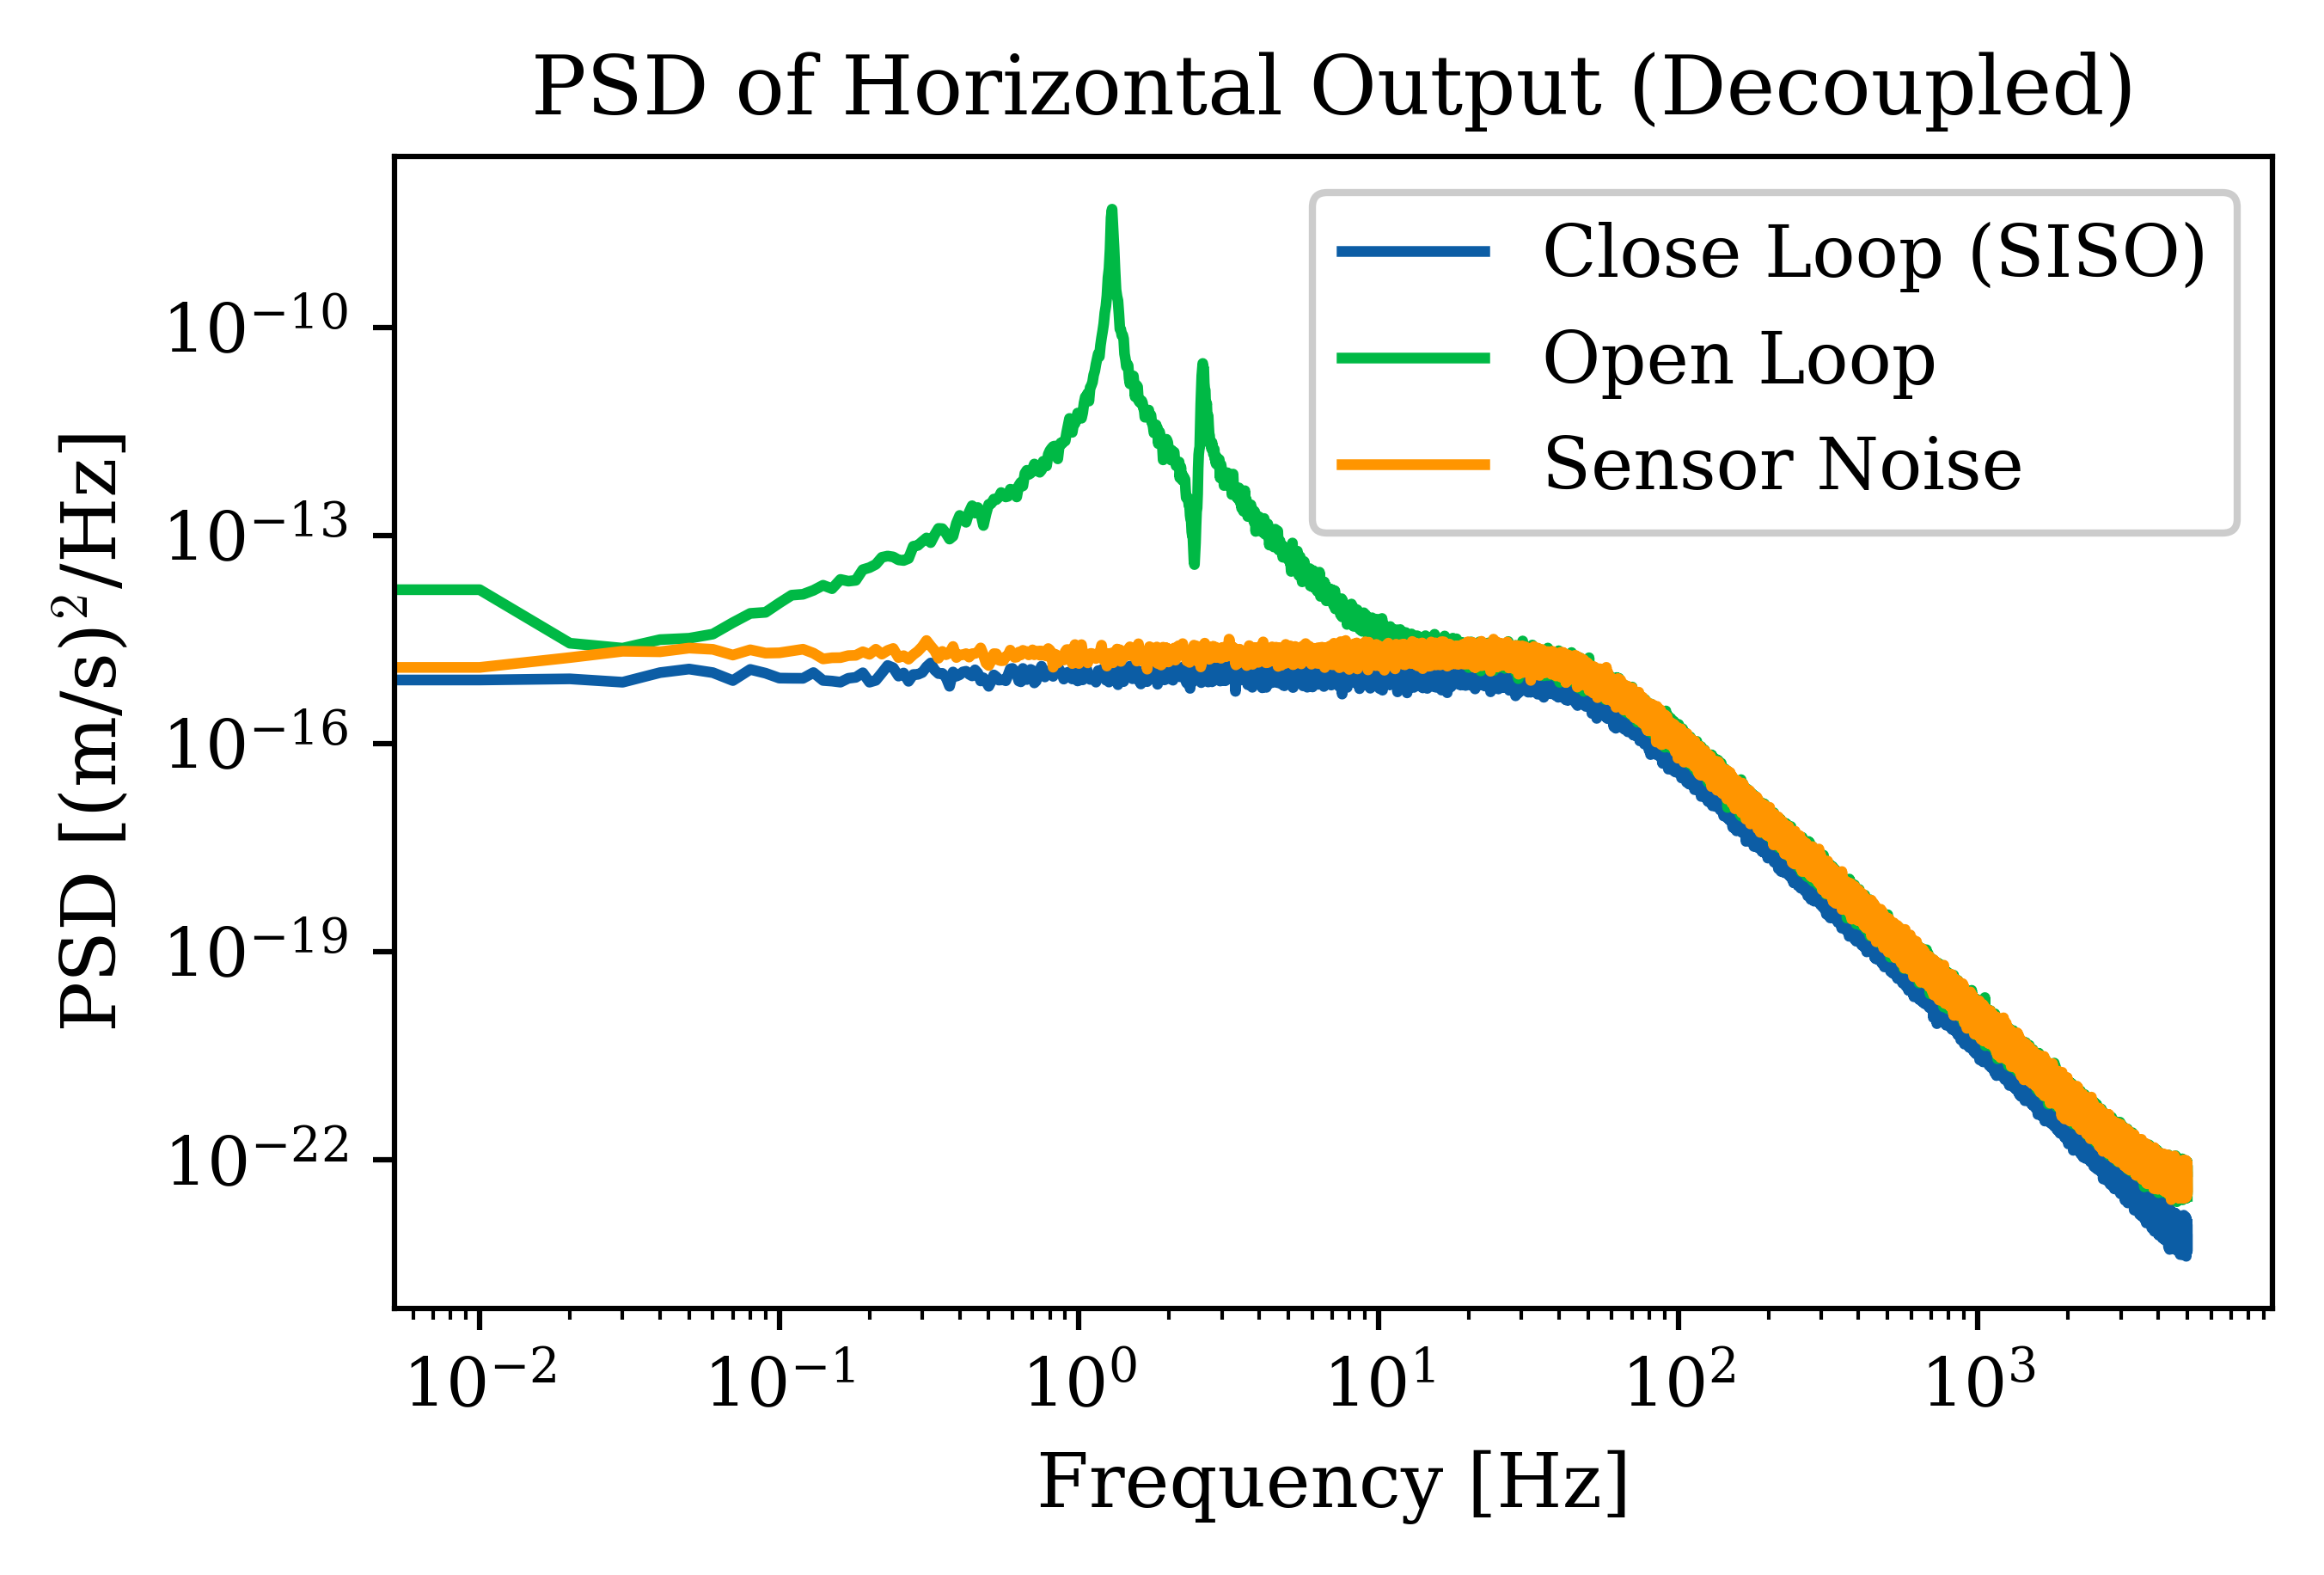

In [15]:
mb.mamplot(
    f, (P_sum_si, P_sum_o, P_ns), 
    ('Close Loop (SISO)', 'Open Loop', 'Sensor Noise'), 
    'PSD of Vertical Translational Output (Decoupled)',
    'Frequency [Hz]', 'PSD [(m/s)$^2$/Hz]',
    xlog=True, ylog=True, svg_save=True, legend_out=False
)

mb.mamplot(
    f, (P_diff_si, P_diff_o, P_ns), 
    ('Close Loop (SISO)', 'Open Loop', 'Sensor Noise'), 
    'PSD of Vertical Rotating Output (Decoupled)',
    'Frequency [Hz]', 'PSD [(m/s)$^2$/Hz]',
    xlog=True, ylog=True, svg_save=True, legend_out=False
)

mb.mamplot(
    f, (P_x_si, P_x_o, P_ns), 
    ('Close Loop (SISO)', 'Open Loop', 'Sensor Noise'), 
    'PSD of Horizontal Output (Decoupled)',
    'Frequency [Hz]', 'PSD [(m/s)$^2$/Hz]',
    xlog=True, ylog=True, svg_save=True, legend_out=False
)

### 驱动力

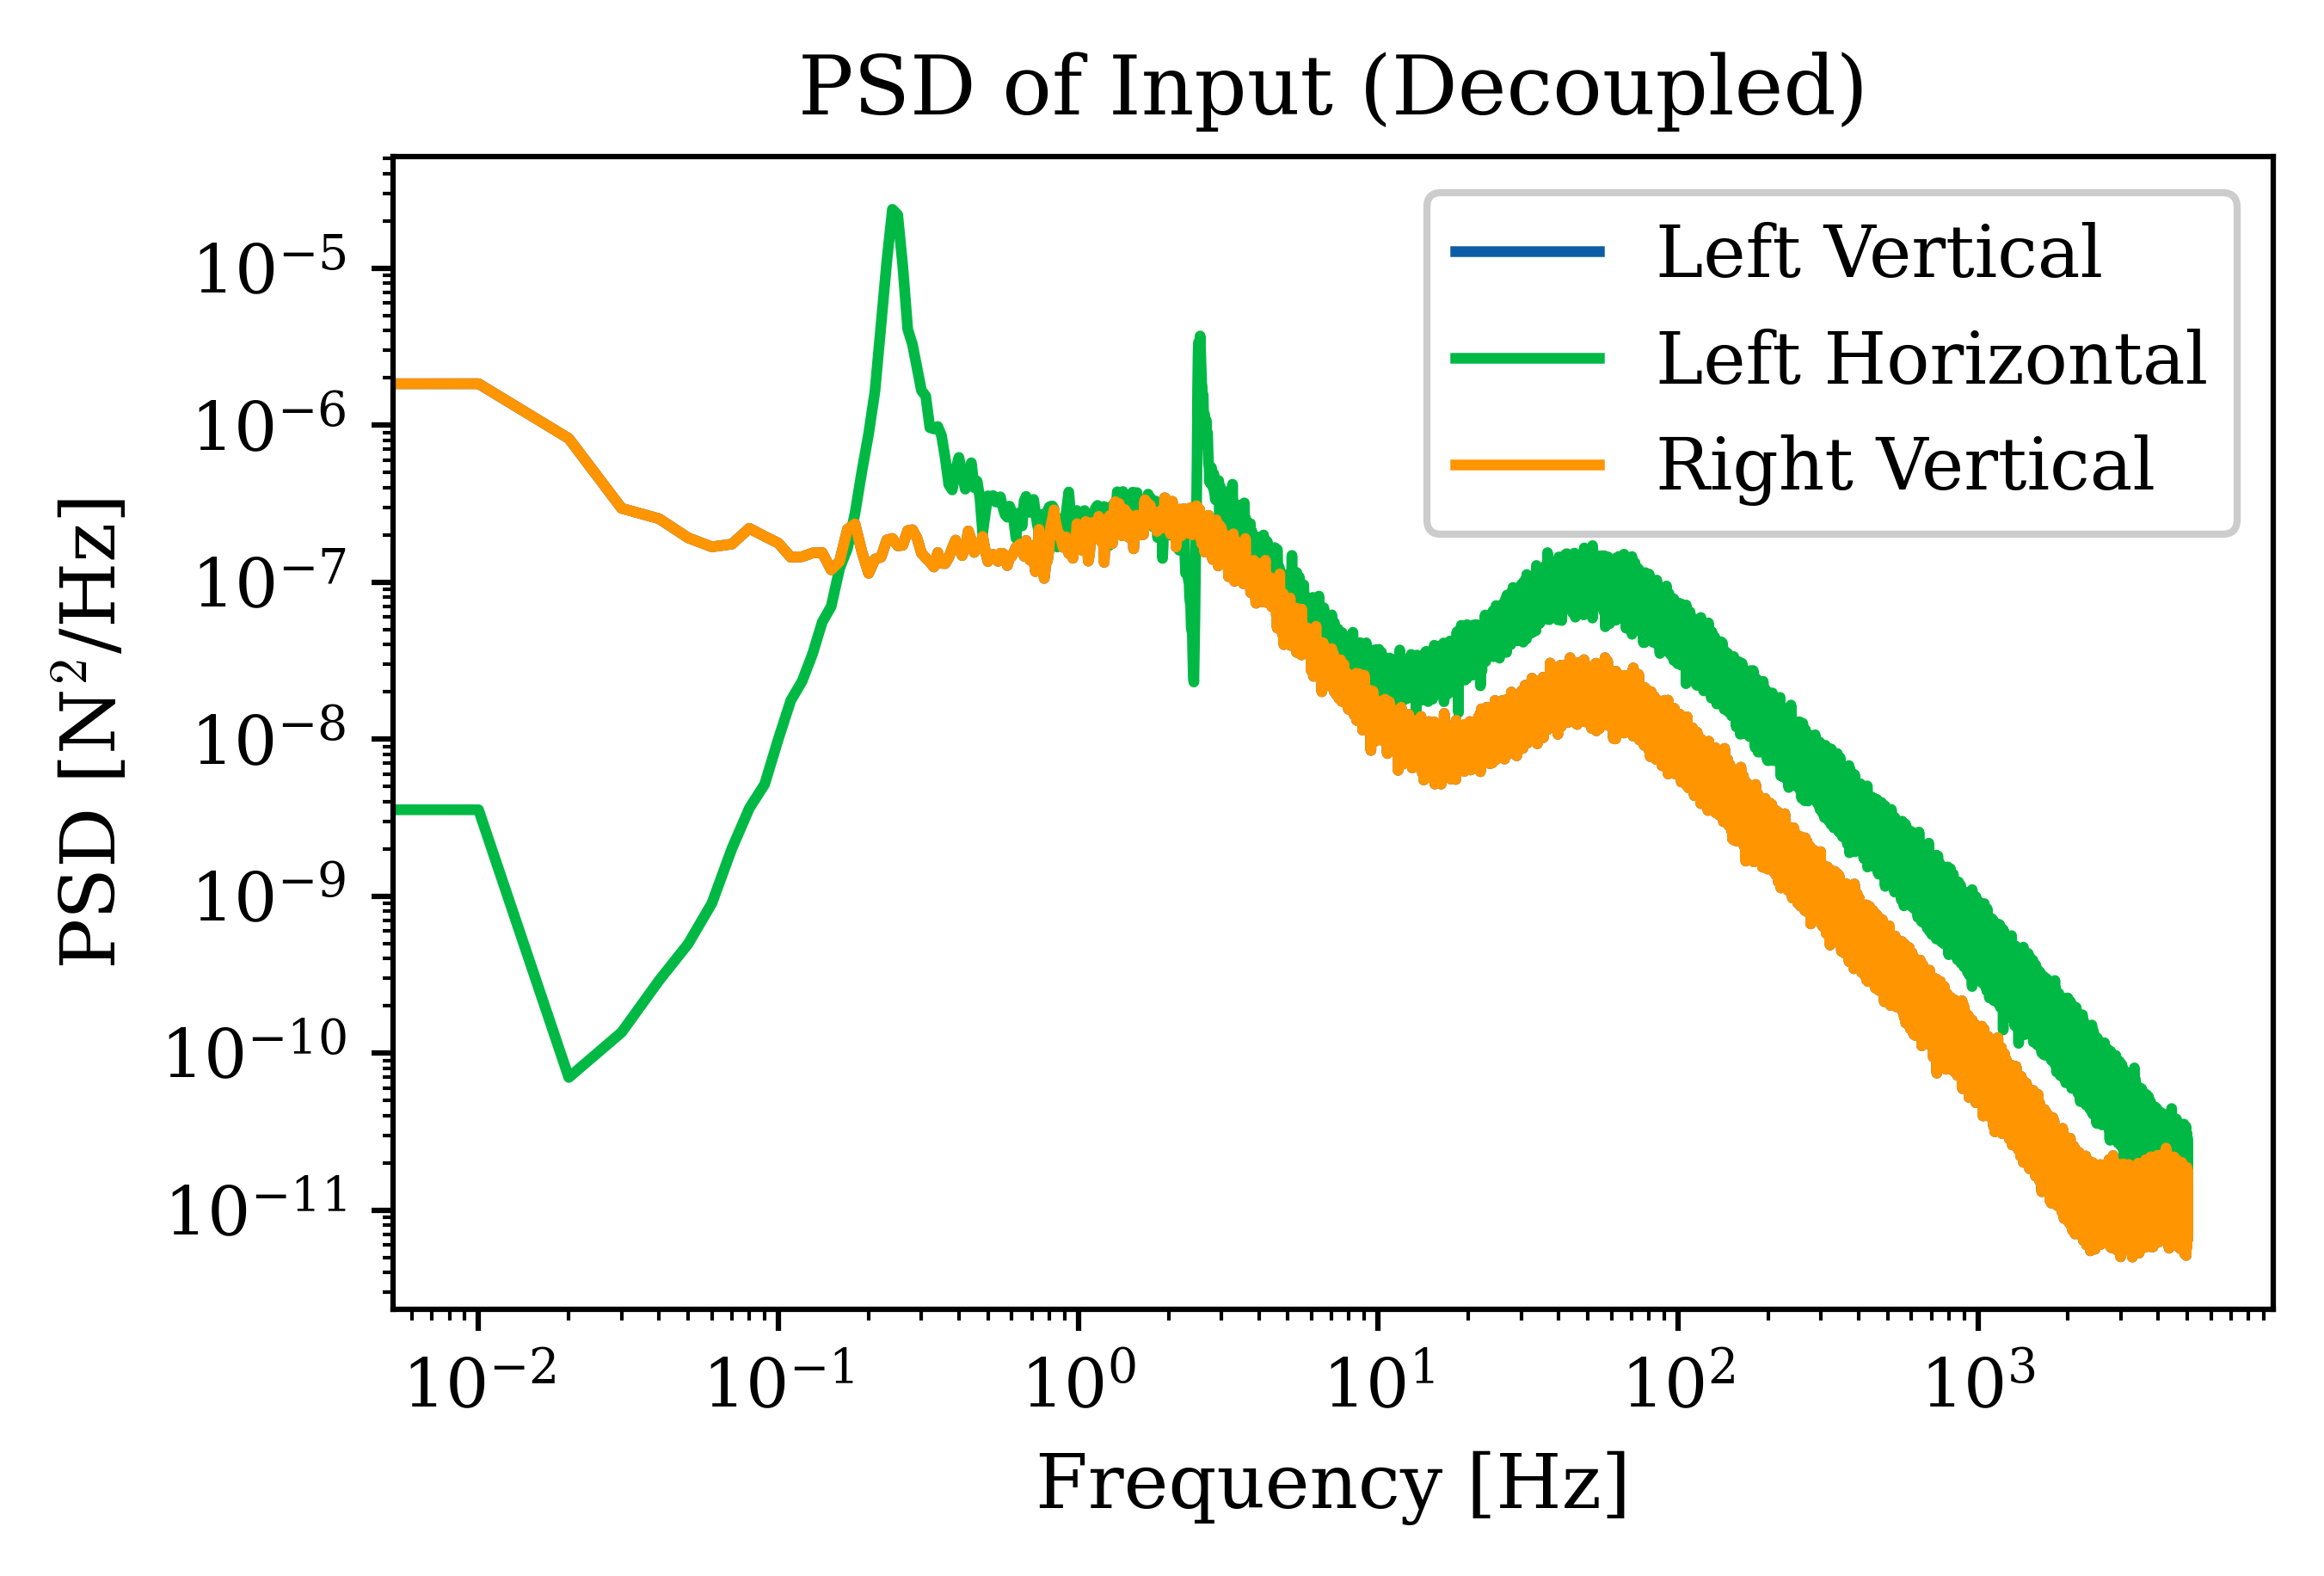

In [17]:
data_u2 = pd.read_csv('course_work_siso_input_simulink_sim_output_data_202512101318.csv')

# 重采样
from scipy.interpolate import interp1d
fs = 10_000
dt = 1.0 / fs
t_new = np.arange(0, 2000+dt, dt)

t = data_u2['t'].values

f4 = interp1d(t, data_u2['u_VL'].values, kind='linear')
u_VL_si = f4(t_new)
f5 = interp1d(t, data_u2['u_HL'].values, kind='linear')
u_HL_si = f5(t_new)
f6 = interp1d(t, data_u2['u_VR'].values, kind='linear')
u_VR_si = f6(t_new)

Delta_f = 0.01
T_eff = 1/Delta_f
M = fs * T_eff

f, P_VL_u = welch(u_VL_si, fs=fs, nperseg=M)
_, P_HL_u = welch(u_HL_si, fs=fs, nperseg=M)
_, P_VR_u = welch(u_VR_si, fs=fs, nperseg=M)

mb.mamplot(
    f, (P_VL_u, P_HL_u, P_VR_u), 
    ('Left Vertical', 'Left Horizontal', 'Right Vertical'), 
    'PSD of Input (Decoupled)',
    'Frequency [Hz]', 'PSD [N$^2$/Hz]',
    xlog=True, ylog=True, svg_save=True, legend_out=False
)

## Decoupled LQG

In [16]:
data_cl3 = pd.read_csv('course_work_delqg_closeloop_simulink_sim_output_data_202512101400.csv')
data_cl3

t          y_VL          y_HL          y_VR          y_HR  \
0            0.000000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
1            0.000100  1.021587e-09 -1.984091e-09 -9.223199e-10 -2.589513e-09   
2            0.000121 -4.321381e-09 -5.694037e-09  1.538579e-10 -6.385861e-10   
3            0.000142 -6.809286e-09 -7.690037e-09  2.476979e-10 -8.098335e-11   
4            0.000176 -6.075942e-09 -9.890171e-09  3.471467e-09  4.944563e-10   
...               ...           ...           ...           ...           ...   
83921452  1999.999900 -3.923378e-07  8.723218e-08  3.065010e-07 -4.867432e-08   
83921453  1999.999920 -3.953271e-07  8.760161e-08  3.054516e-07 -4.837403e-08   
83921454  1999.999947 -3.955598e-07  8.831268e-08  3.075792e-07 -4.782492e-08   
83921455  1999.999979 -3.892188e-07  8.945590e-08  3.164594e-07 -4.694793e-08   
83921456  2000.000000 -3.944224e-07  9.042430e-08  3.128766e-07 -4.619538e-08   

                    ns  
0         0.000000e+00  
1         5.482423e-10  
2         9.434194e-10  
3         1.666522e-09  
4         3.467185e-09  
...                ...  
83921452  5.434470e-07  
83921453  5.437198e-07  
83921454  5.442108e-07  
83921455  5.449759e-07  
83921456  5.456178e-07  

[83921457 rows x 6 columns]

In [5]:
# 重采样
from scipy.interpolate import interp1d
fs = 10000
dt = 1.0 / fs
t_new = np.arange(0, 2000+dt, dt)

In [17]:
t = data_cl3['t'].values

f7 = interp1d(t, data_cl3['y_VL'].values, kind='linear')
y_VL_cl3 = f7(t_new)
f8 = interp1d(t, data_cl3['y_HL'].values, kind='linear')
y_HL_cl3 = f8(t_new)
f9 = interp1d(t, data_cl3['y_VR'].values, kind='linear')
y_VR_cl3 = f9(t_new)

In [7]:
data_ol = pd.read_csv('course_work_openloop_simulink_sim_output_data_202512030037.csv')
data_ol

t          y_VL          y_HL          y_VR          y_HR  \
0            0.0000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
1            0.0001 -8.562659e-09 -8.451461e-09  7.943767e-10  9.035270e-10   
2            0.0002 -1.870825e-08 -1.859401e-08  7.884192e-09  7.987160e-09   
3            0.0003 -2.904982e-08 -2.891912e-08  1.351649e-08  1.382199e-08   
4            0.0004 -3.796819e-08 -3.778554e-08  2.168040e-08  2.230876e-08   
...             ...           ...           ...           ...           ...   
19999996  1999.9996  4.410560e-06  5.045117e-06  5.552312e-06 -5.009782e-06   
19999997  1999.9997  4.482603e-06  5.063770e-06  5.626089e-06 -5.028940e-06   
19999998  1999.9998  4.556683e-06  5.084712e-06  5.703382e-06 -5.044367e-06   
19999999  1999.9999  4.629687e-06  5.104475e-06  5.779531e-06 -5.060959e-06   
20000000  2000.0000  4.705823e-06  5.126992e-06  5.857306e-06 -5.075983e-06   

                    ns  
0         0.000000e+00  
1         9.047781e-10  
2         7.994047e-09  
3         1.371517e-08  
4         2.203640e-08  
...                ...  
19999996  5.372490e-07  
19999997  5.362259e-07  
19999998  5.389573e-07  
19999999  5.404724e-07  
20000000  5.433618e-07  

[20000001 rows x 6 columns]

In [8]:
y_VL_o = data_ol['y_VL'].values
y_HL_o = data_ol['y_HL'].values
y_VR_o = data_ol['y_VR'].values
y_HR_o = data_ol['y_HR'].values

ns = data_ol['ns'].values

In [18]:
z_sum_cl3 = (y_VL_cl3 + y_VR_cl3) / 2
z_diff_cl3 = (y_VL_cl3 - y_VR_cl3) / 2
x_cl3 = y_HL_cl3

# z_sum_o = (y_VL_o + y_VR_o) / 2
# z_diff_o = (y_VL_o - y_VR_o) / 2
# x_o = y_HL_o

In [ ]:
L = len(t_new)
Delta_f = 0.01
T_eff = 1/Delta_f
M = fs * T_eff
print('The Welch K: ', L/M)

In [19]:
f, P_sum_cl3 = welch(z_sum_cl3, fs=fs, nperseg=M)
# _, P_sum_o = welch(z_sum_o, fs=fs, nperseg=M)

_, P_diff_cl3 = welch(z_diff_cl3, fs=fs, nperseg=M)
# _, P_diff_o = welch(z_diff_o, fs=fs, nperseg=M)

_, P_x_cl3 = welch(x_cl3, fs=fs, nperseg=M)
# _, P_x_o = welch(x_o, fs=fs, nperseg=M)

# _, P_ns = welch(ns, fs=fs, nperseg=M)

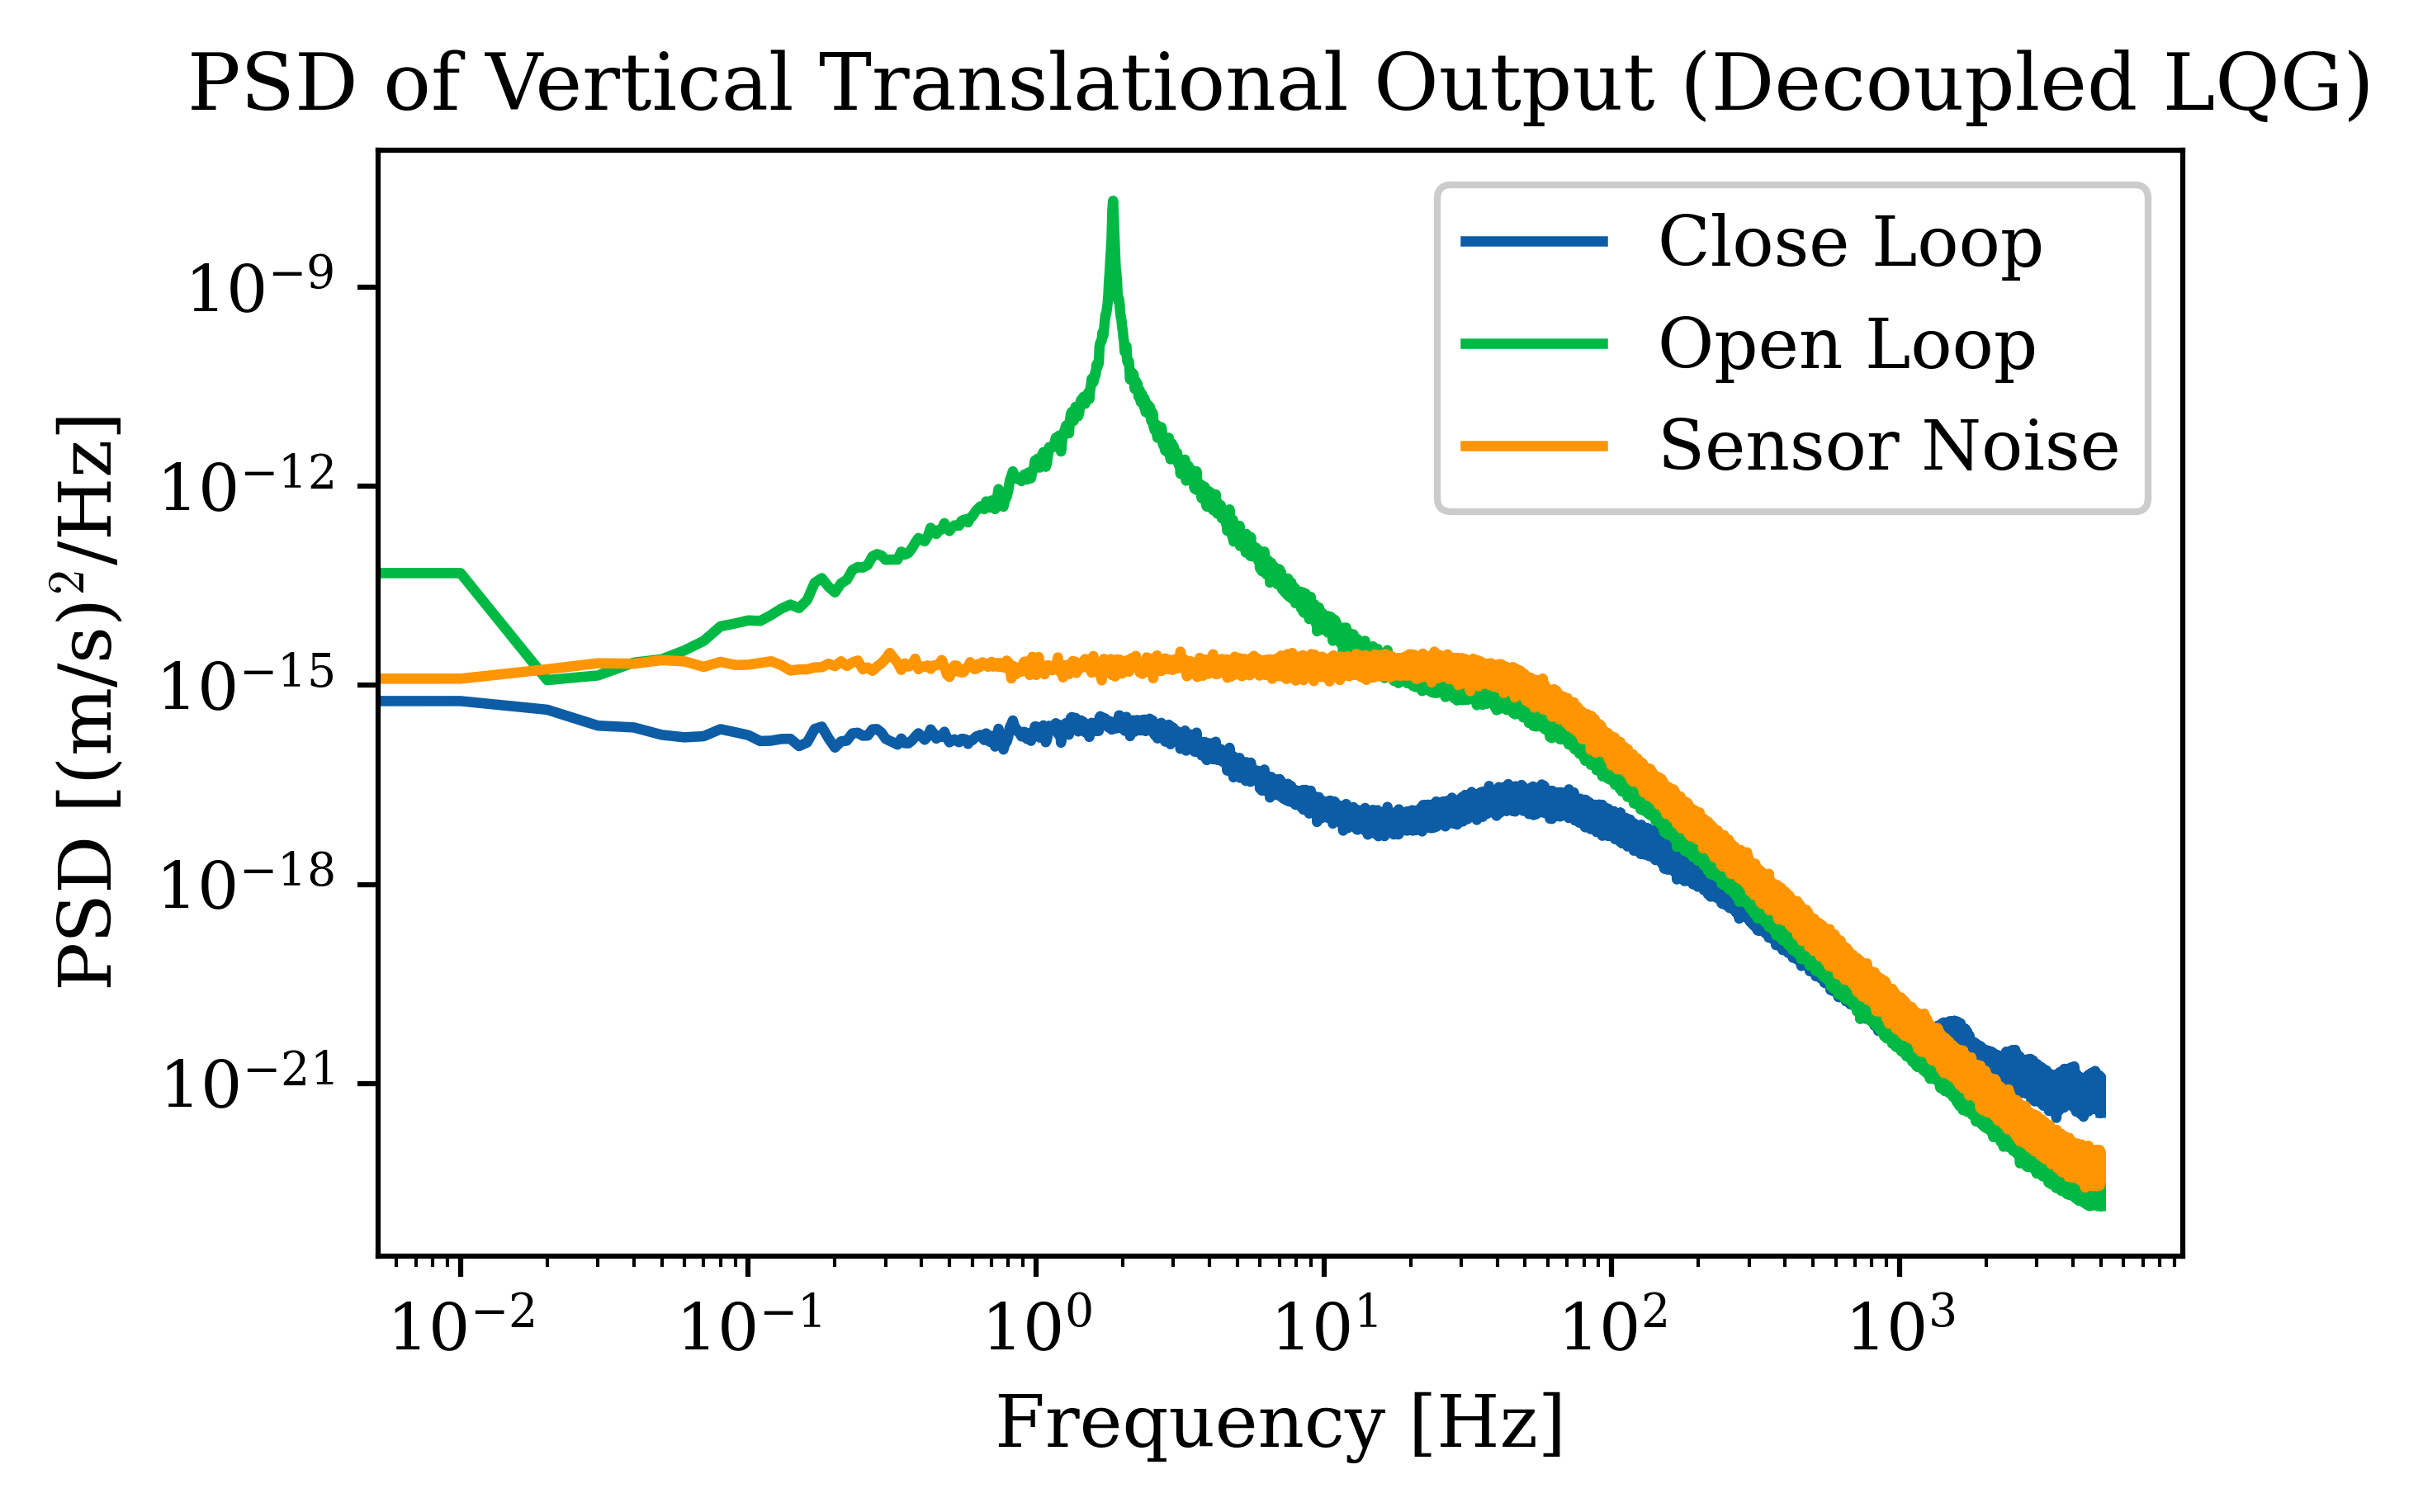

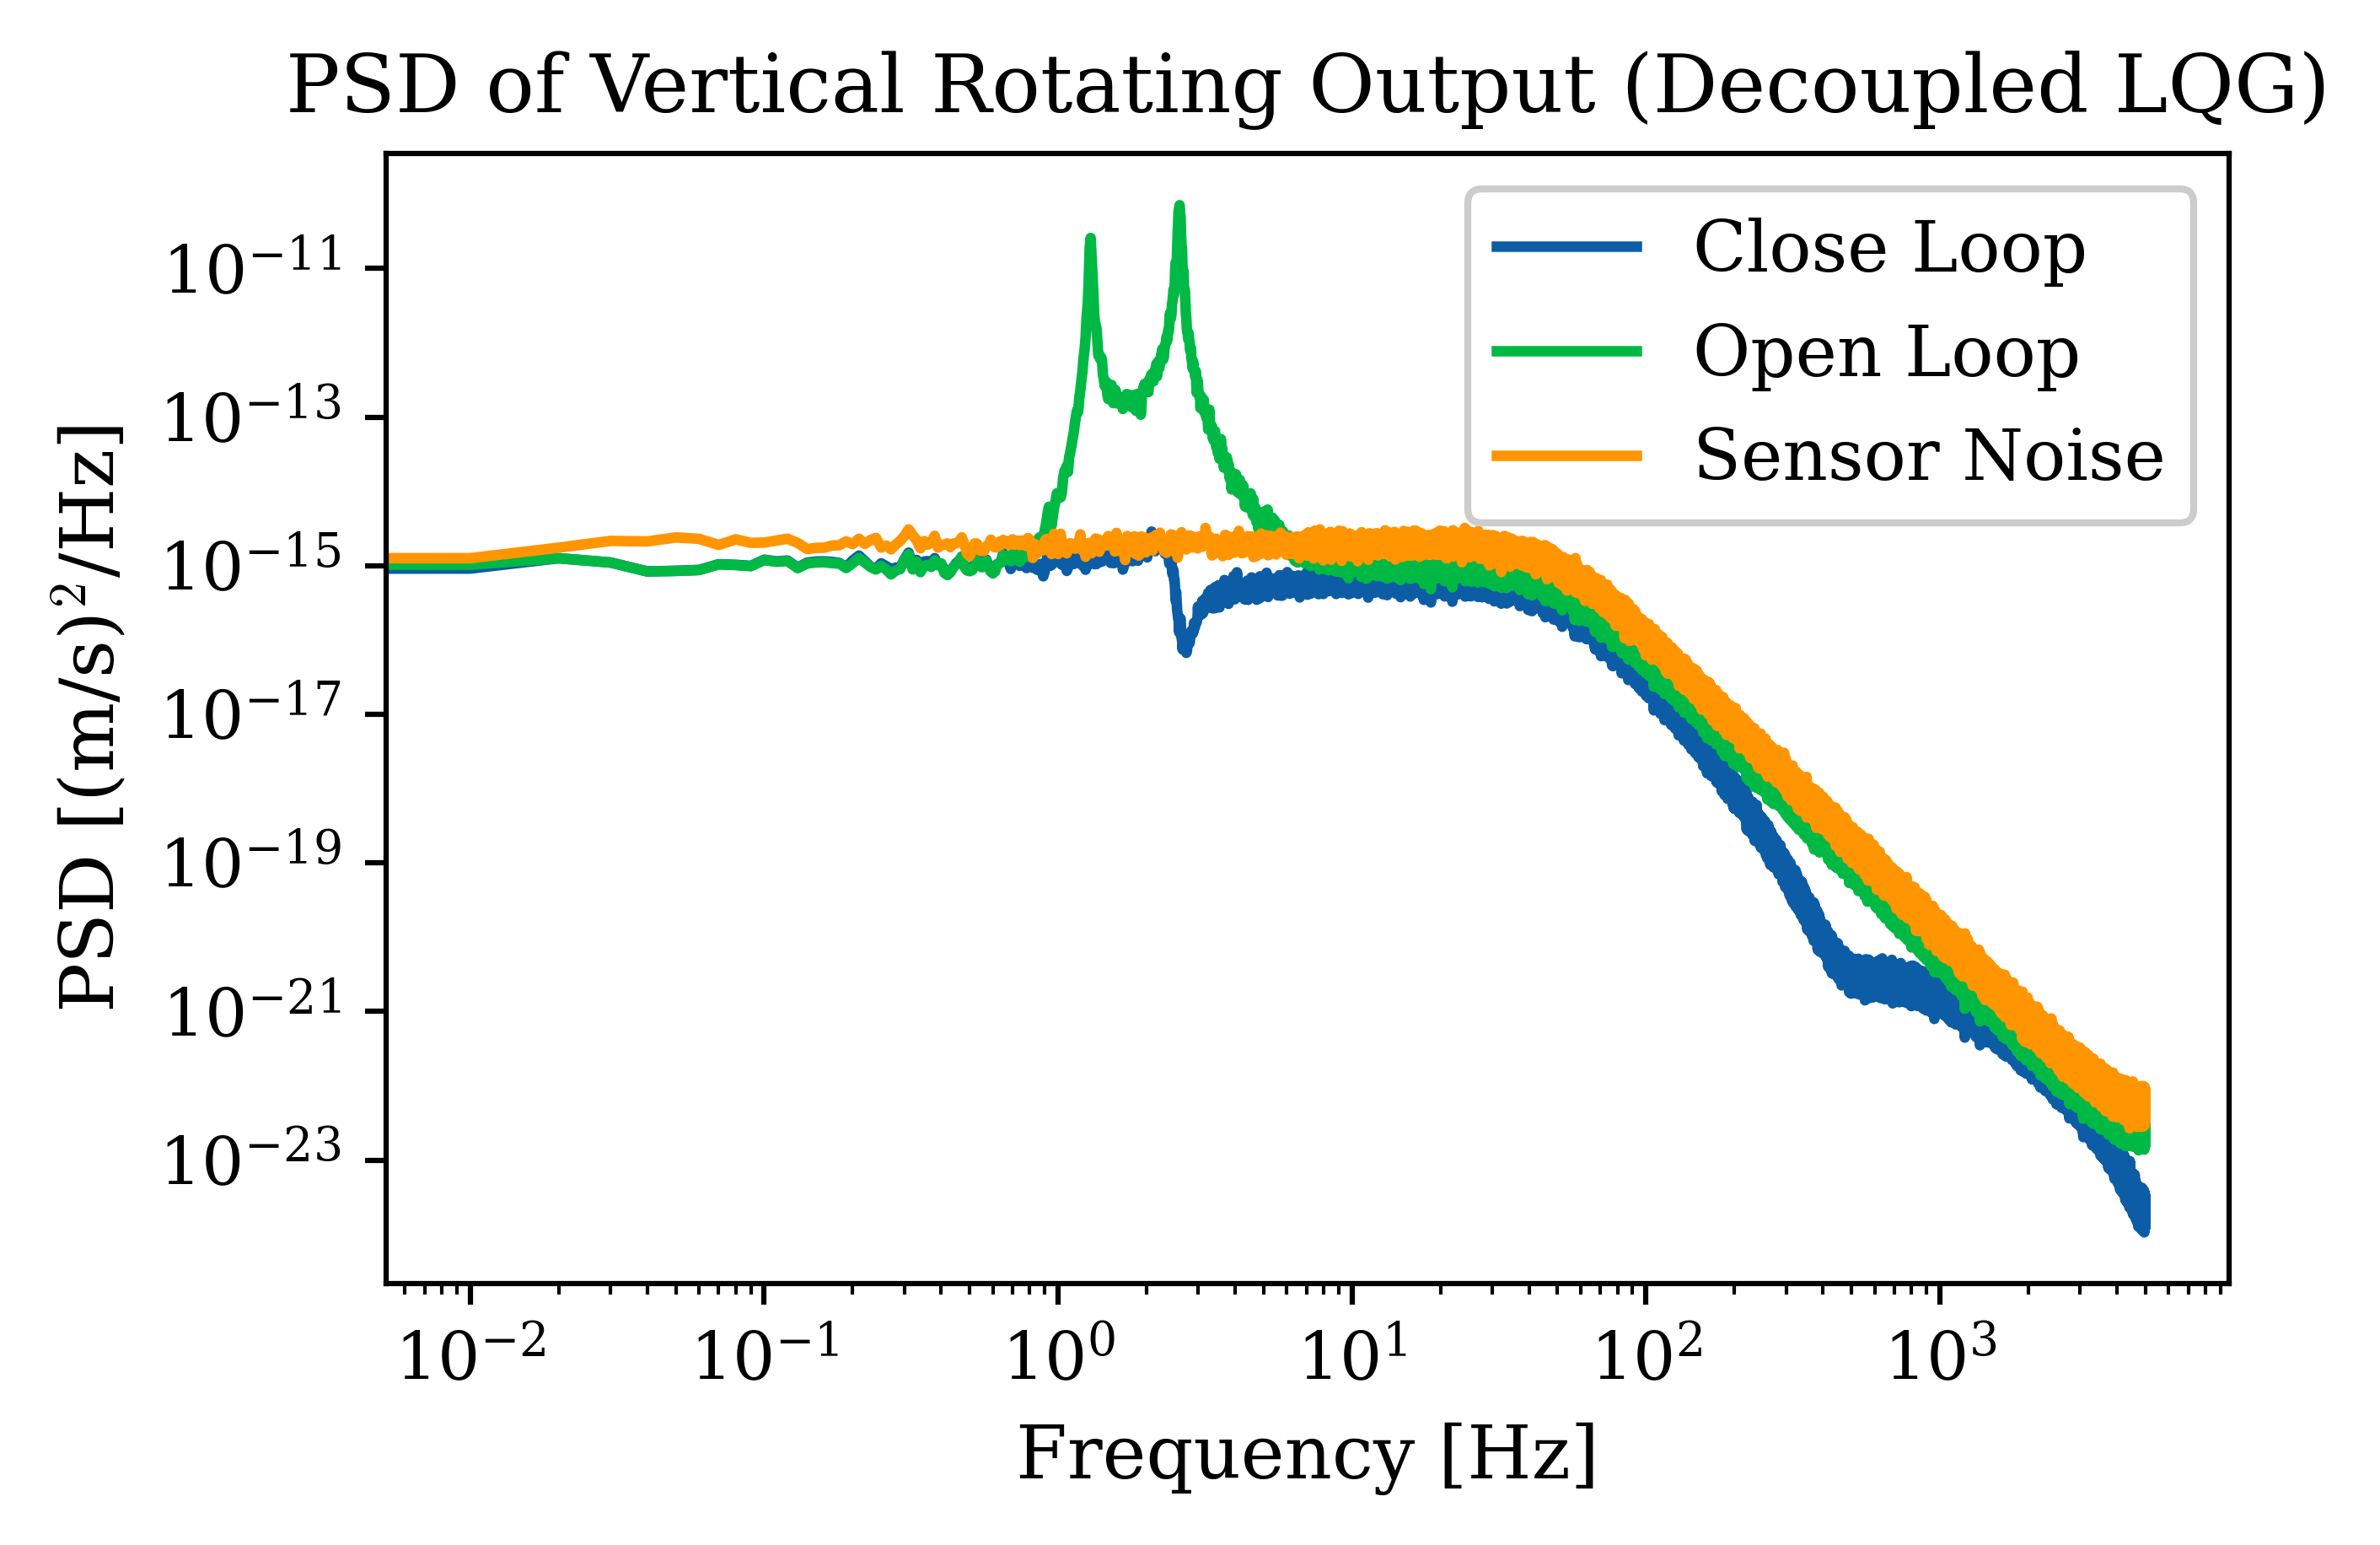

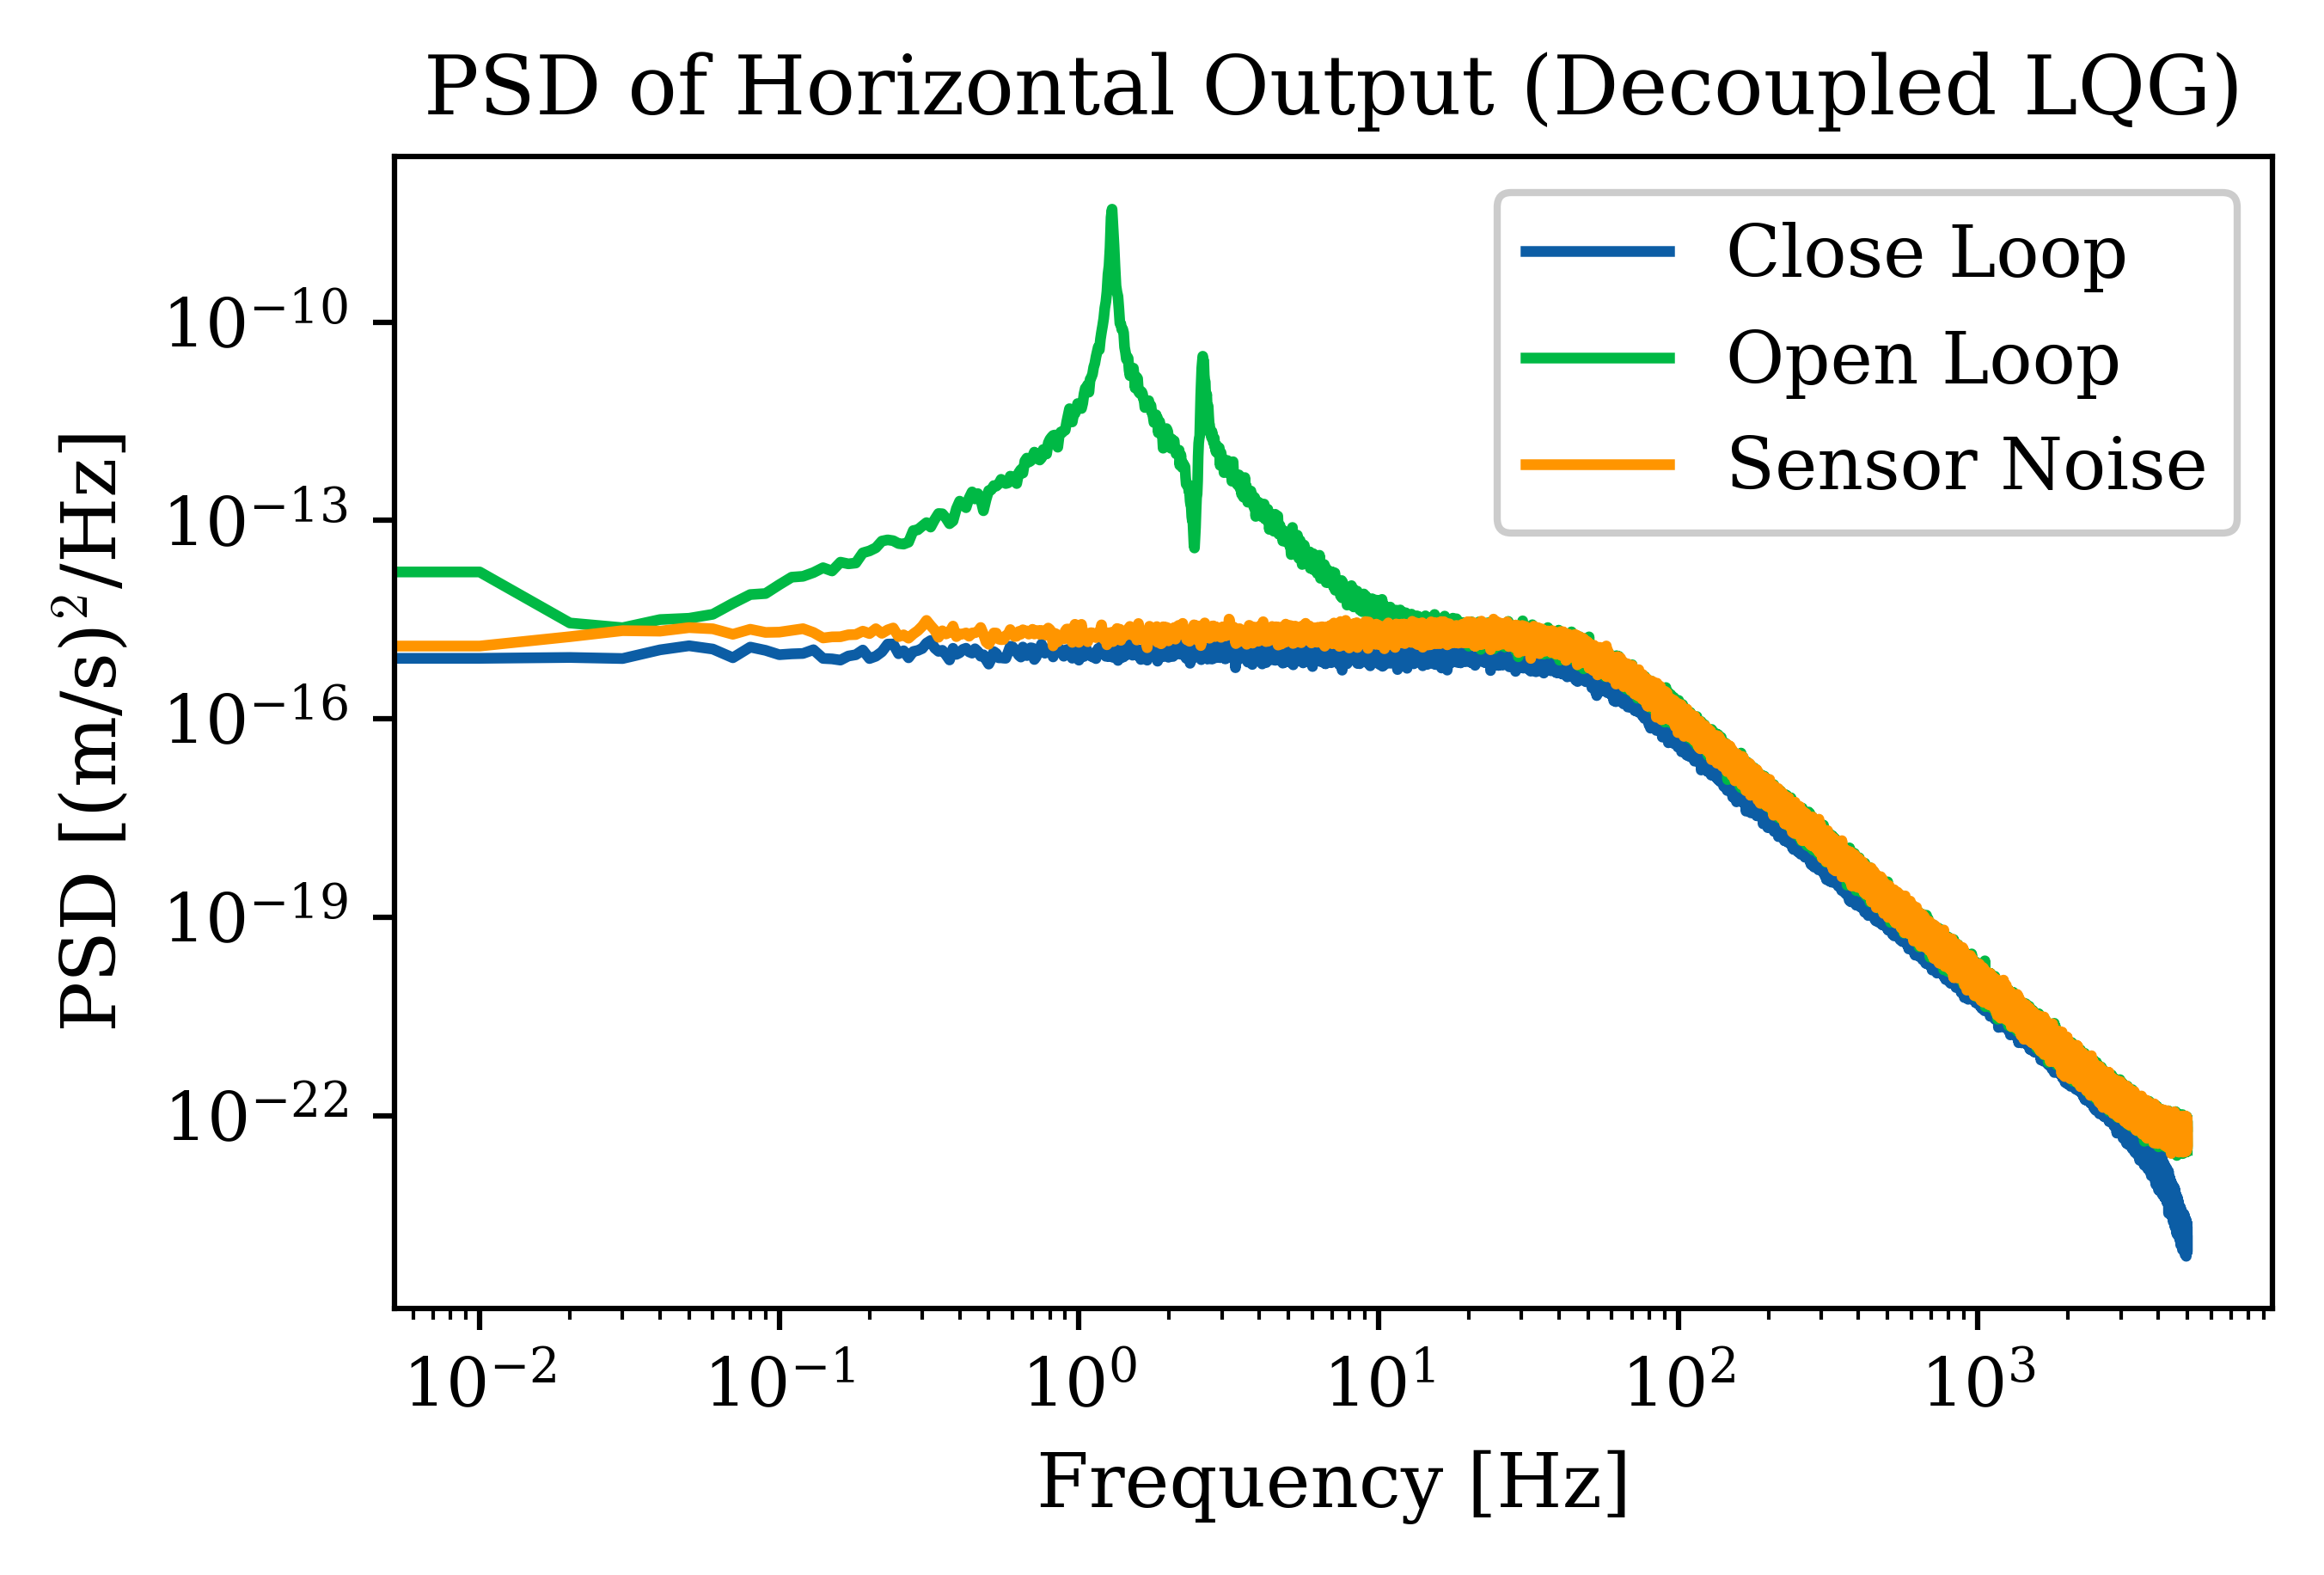

In [12]:
mb.mamplot(
    f, (P_sum_cl3, P_sum_o, P_ns), 
    ('Close Loop', 'Open Loop', 'Sensor Noise'), 
    'PSD of Vertical Translational Output (Decoupled LQG)',
    'Frequency [Hz]', 'PSD [(m/s)$^2$/Hz]',
    xlog=True, ylog=True, svg_save=True, legend_out=False
)

mb.mamplot(
    f, (P_diff_cl3, P_diff_o, P_ns), 
    ('Close Loop', 'Open Loop', 'Sensor Noise'), 
    'PSD of Vertical Rotating Output (Decoupled LQG)',
    'Frequency [Hz]', 'PSD [(m/s)$^2$/Hz]',
    xlog=True, ylog=True, svg_save=True, legend_out=False
)

mb.mamplot(
    f, (P_x_cl3, P_x_o, P_ns), 
    ('Close Loop', 'Open Loop', 'Sensor Noise'), 
    'PSD of Horizontal Output (Decoupled LQG)',
    'Frequency [Hz]', 'PSD [(m/s)$^2$/Hz]',
    xlog=True, ylog=True, svg_save=True, legend_out=False
)

## iKF + LQR

In [5]:
data_ikf = pd.read_csv('course_work_kflqg_data.csv')
data_ikf

t          y_VL          y_HL          y_VR          y_HR  \
0          0.0000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
1          0.0001 -4.585341e-09 -4.583258e-09  1.027502e-10  9.654087e-12   
2          0.0002 -1.160615e-08 -1.184118e-08  2.588177e-09  1.753173e-09   
3          0.0003 -1.606030e-08 -1.656563e-08  4.847024e-09  2.950566e-09   
4          0.0004 -1.835271e-08 -1.918105e-08  6.314103e-09  3.307568e-09   
...           ...           ...           ...           ...           ...   
4999995  499.9996  6.951126e-09 -1.195427e-07 -1.260856e-07 -1.305545e-07   
4999996  499.9997  7.462338e-09 -1.229524e-07 -1.255485e-07 -1.322691e-07   
4999997  499.9998  4.066526e-09 -1.302355e-07 -1.282603e-07 -1.375785e-07   
4999998  499.9999 -3.669152e-09 -1.423421e-07 -1.343523e-07 -1.473717e-07   
4999999  500.0000 -1.179908e-08 -1.559578e-07 -1.408990e-07 -1.589343e-07   

                   ns  
0        0.000000e+00  
1        5.482423e-10  
2        5.282755e-09  
3        1.210663e-08  
4        1.930239e-08  
...               ...  
4999995 -4.961503e-07  
4999996 -5.006419e-07  
4999997 -5.080608e-07  
4999998 -5.189946e-07  
4999999 -5.309664e-07  

[5000000 rows x 6 columns]

In [6]:
t = data_ikf['t'].values

y_VL_ikf = data_ikf['y_VL'].values
y_HL_ikf = data_ikf['y_HL'].values

y_VR_ikf = data_ikf['y_VR'].values
y_HR_ikf = data_ikf['y_HR'].values

ns = data_ikf['ns'].values

In [11]:
dt = t[1] - t[0]
fs = 1/dt
T = np.max(t)
L = len(t)
Delta_f = 0.05
T_eff = 1/Delta_f
M = fs * T_eff
print('The Welch K: ', L/M)

The Welch K:  25.000005


In [12]:
f, P_VL_ikf = welch(y_VL_ikf, fs=fs, nperseg=M)
_, P_HL_ikf = welch(y_HL_ikf, fs=fs, nperseg=M)
_, P_VR_ikf = welch(y_VR_ikf, fs=fs, nperseg=M)
_, P_ns = welch(ns, fs=fs, nperseg=M)

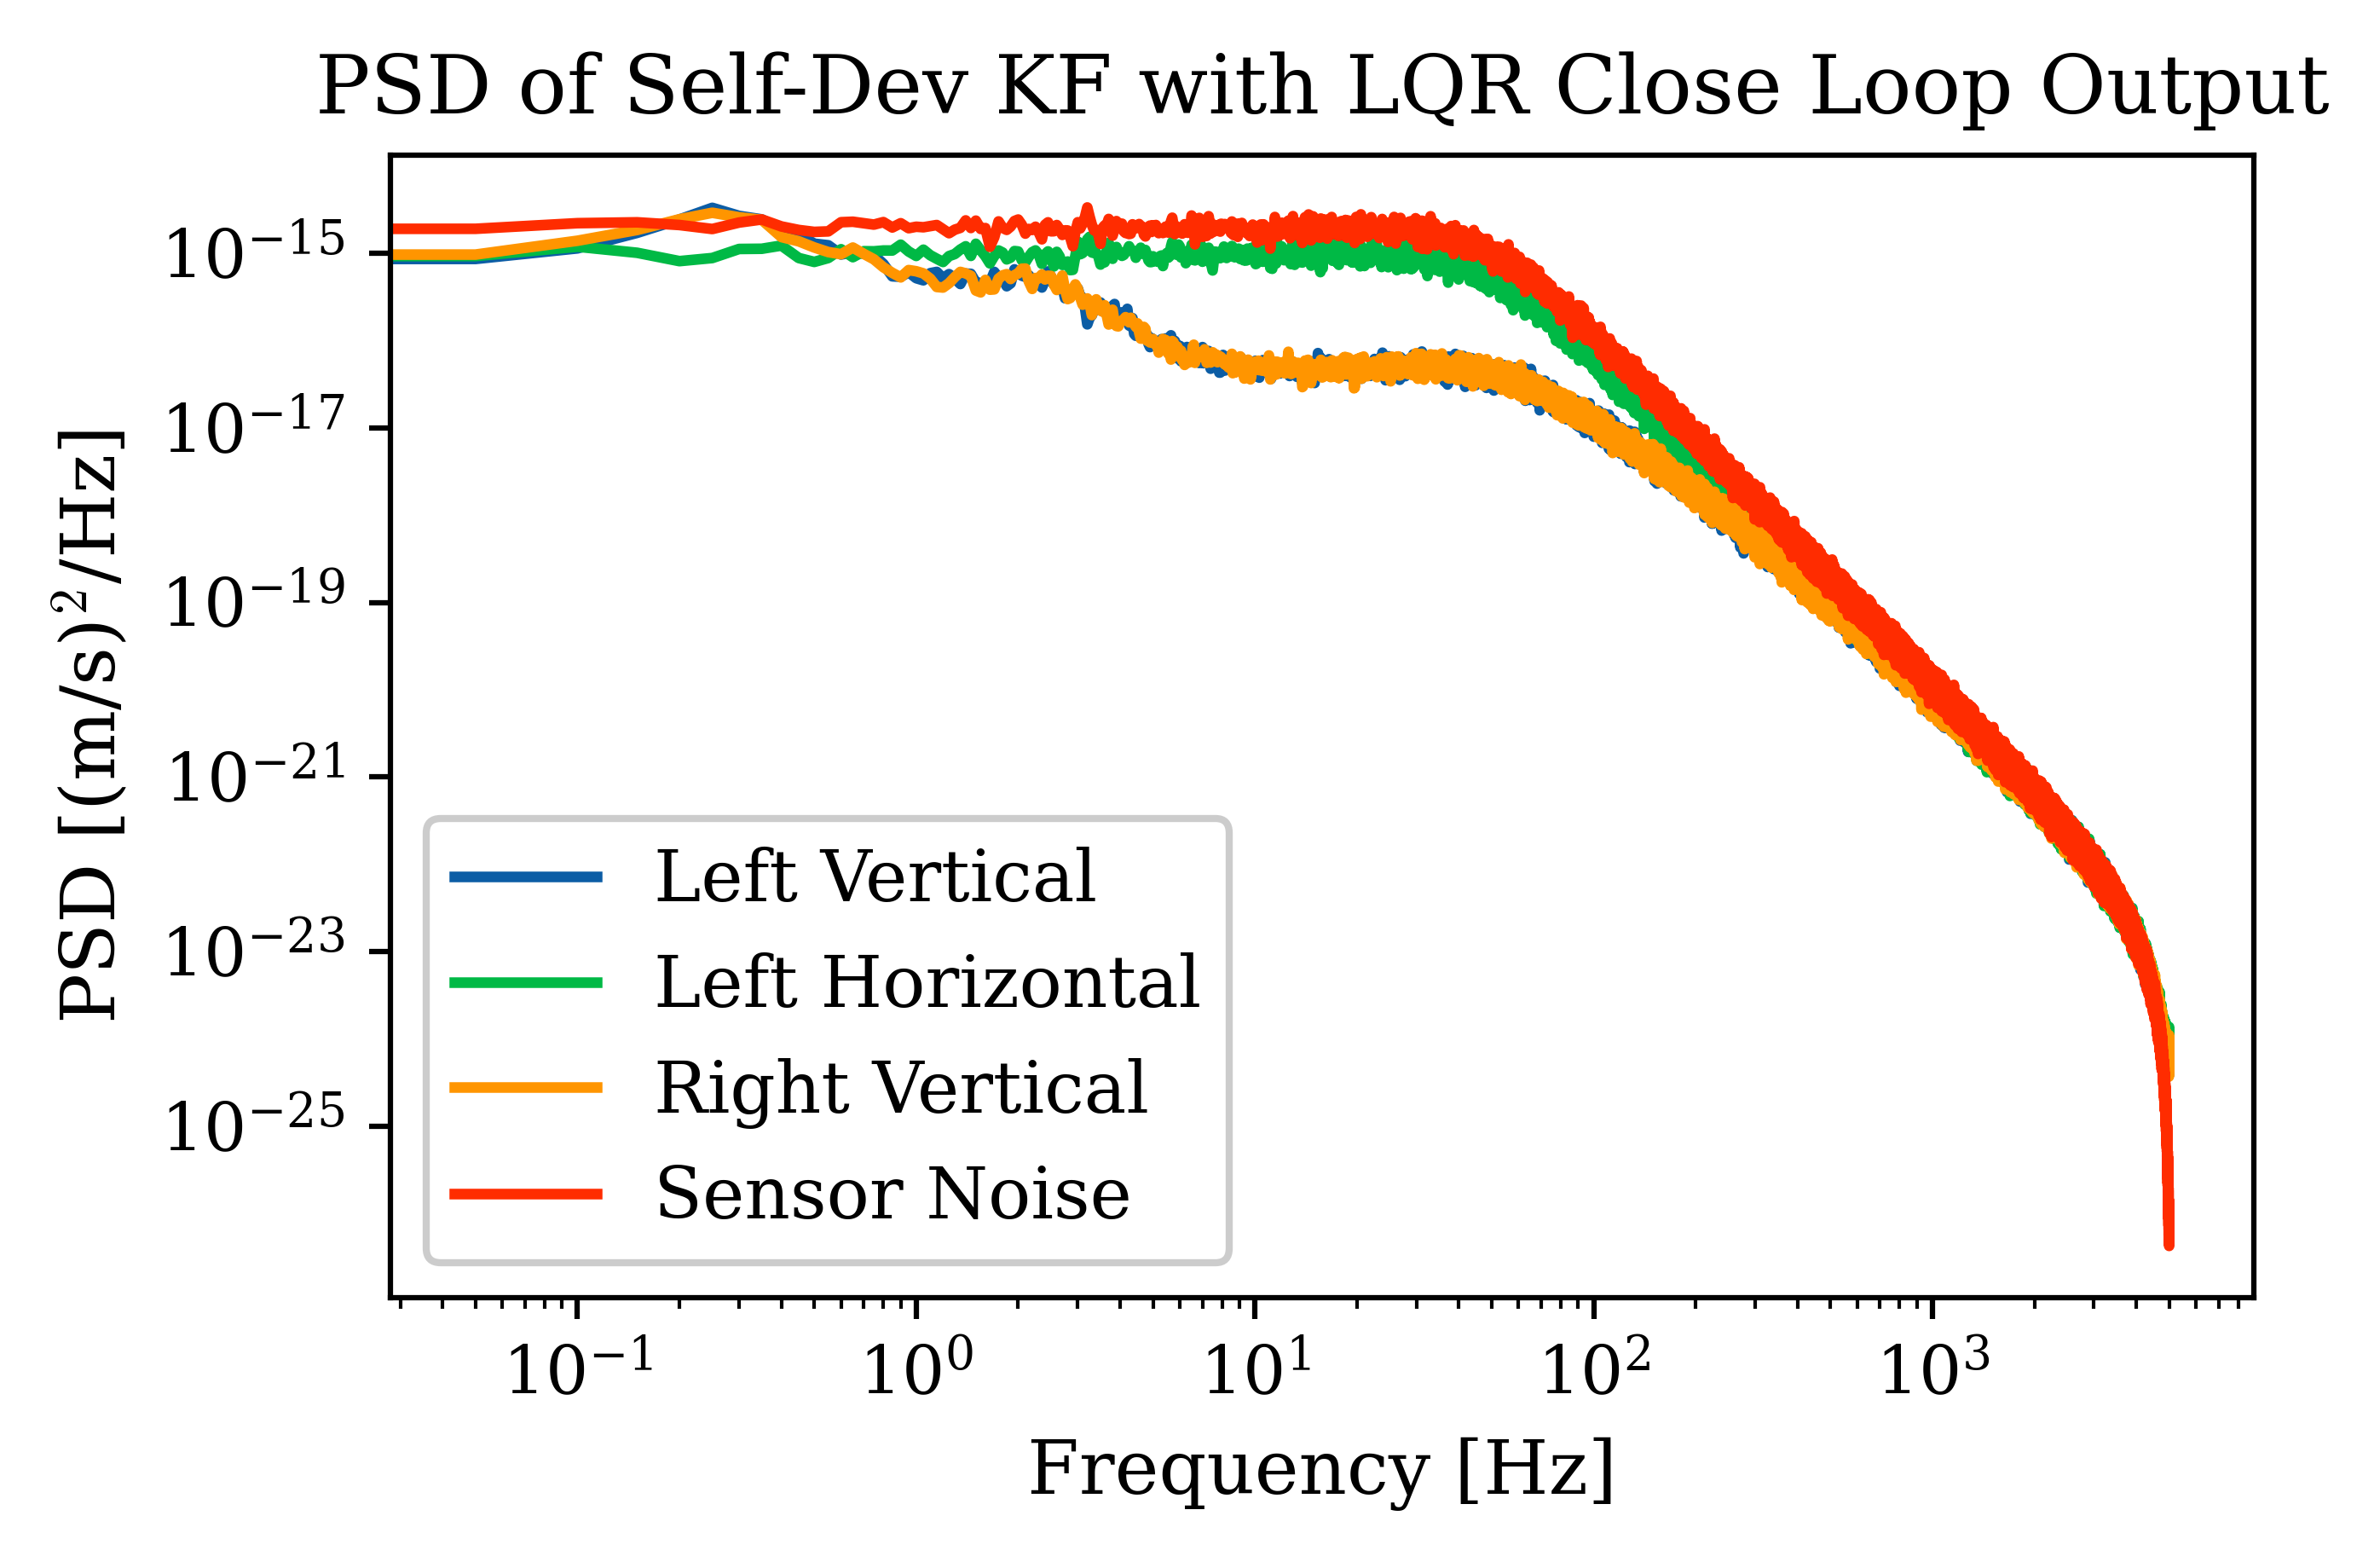

In [13]:
mb.mamplot(
    f, (P_VL_ikf, P_HL_ikf, P_VR_ikf, P_ns), 
    ('Left Vertical', 'Left Horizontal', 'Right Vertical', 'Sensor Noise'), 
    'PSD of Self-Dev KF with LQR Close Loop Output',
    'Frequency [Hz]', 'PSD [(m/s)$^2$/Hz]',
    xlog=True, ylog=True, svg_save=True, legend_out=False
)

### iKF Eval

In [3]:
data_ikfpsd = pd.read_csv('PSD_of_true_output_and_estimated_output.csv')
data_ikfpsd

f1          pxx1          pxx2          pxx3          pxx4  \
0       0.020000  5.501042e-17  2.074612e-15  7.031252e-15  2.074612e-15   
1       0.040000  1.491241e-15  2.233474e-15  3.953226e-15  2.233474e-15   
2       0.062490  9.590321e-16  3.483373e-16  2.175106e-16  3.483373e-16   
3       0.090599  5.554208e-16  4.027100e-16  6.586797e-16  4.027100e-16   
4       0.124446  1.430264e-15  6.288270e-16  8.390162e-16  6.288270e-16   
..           ...           ...           ...           ...           ...   
486  4725.429445  9.363006e-25  4.758943e-25  9.355733e-25  4.758943e-25   
487  4784.601043  5.809177e-25  2.966276e-25  5.843253e-25  2.966276e-25   
488  4844.842007  3.099871e-25  1.567282e-25  3.151198e-25  1.567282e-25   
489  4905.817617  1.260417e-25  6.277983e-26  1.269966e-25  6.277983e-26   
490  4967.546012  3.472678e-26  1.738612e-26  3.380695e-26  1.738612e-26   

             pxx5          pxx6          pxx7          pxx8  
0    2.659403e-13  4.557441e-14  4.461420e-13  6.466252e-14  
1    3.018428e-14  6.499665e-15  2.467199e-14  1.179786e-14  
2    6.806664e-14  1.161475e-15  7.916283e-14  1.376289e-15  
3    5.848417e-15  1.035608e-16  1.484087e-14  6.296332e-16  
4    2.503607e-10  8.902266e-14  4.960542e-10  9.517316e-14  
..            ...           ...           ...           ...  
486  1.600931e-24  1.721157e-24  1.597353e-24  1.707489e-24  
487  1.249054e-24  1.369029e-24  1.253862e-24  1.366521e-24  
488  9.679047e-25  1.083835e-24  9.842441e-25  1.096058e-24  
489  7.772946e-25  8.877516e-25  7.826596e-25  8.966540e-25  
490  6.916737e-25  8.024629e-25  6.865144e-25  8.009079e-25  

[491 rows x 9 columns]

In [4]:
f1 = data_ikfpsd['f1'].values

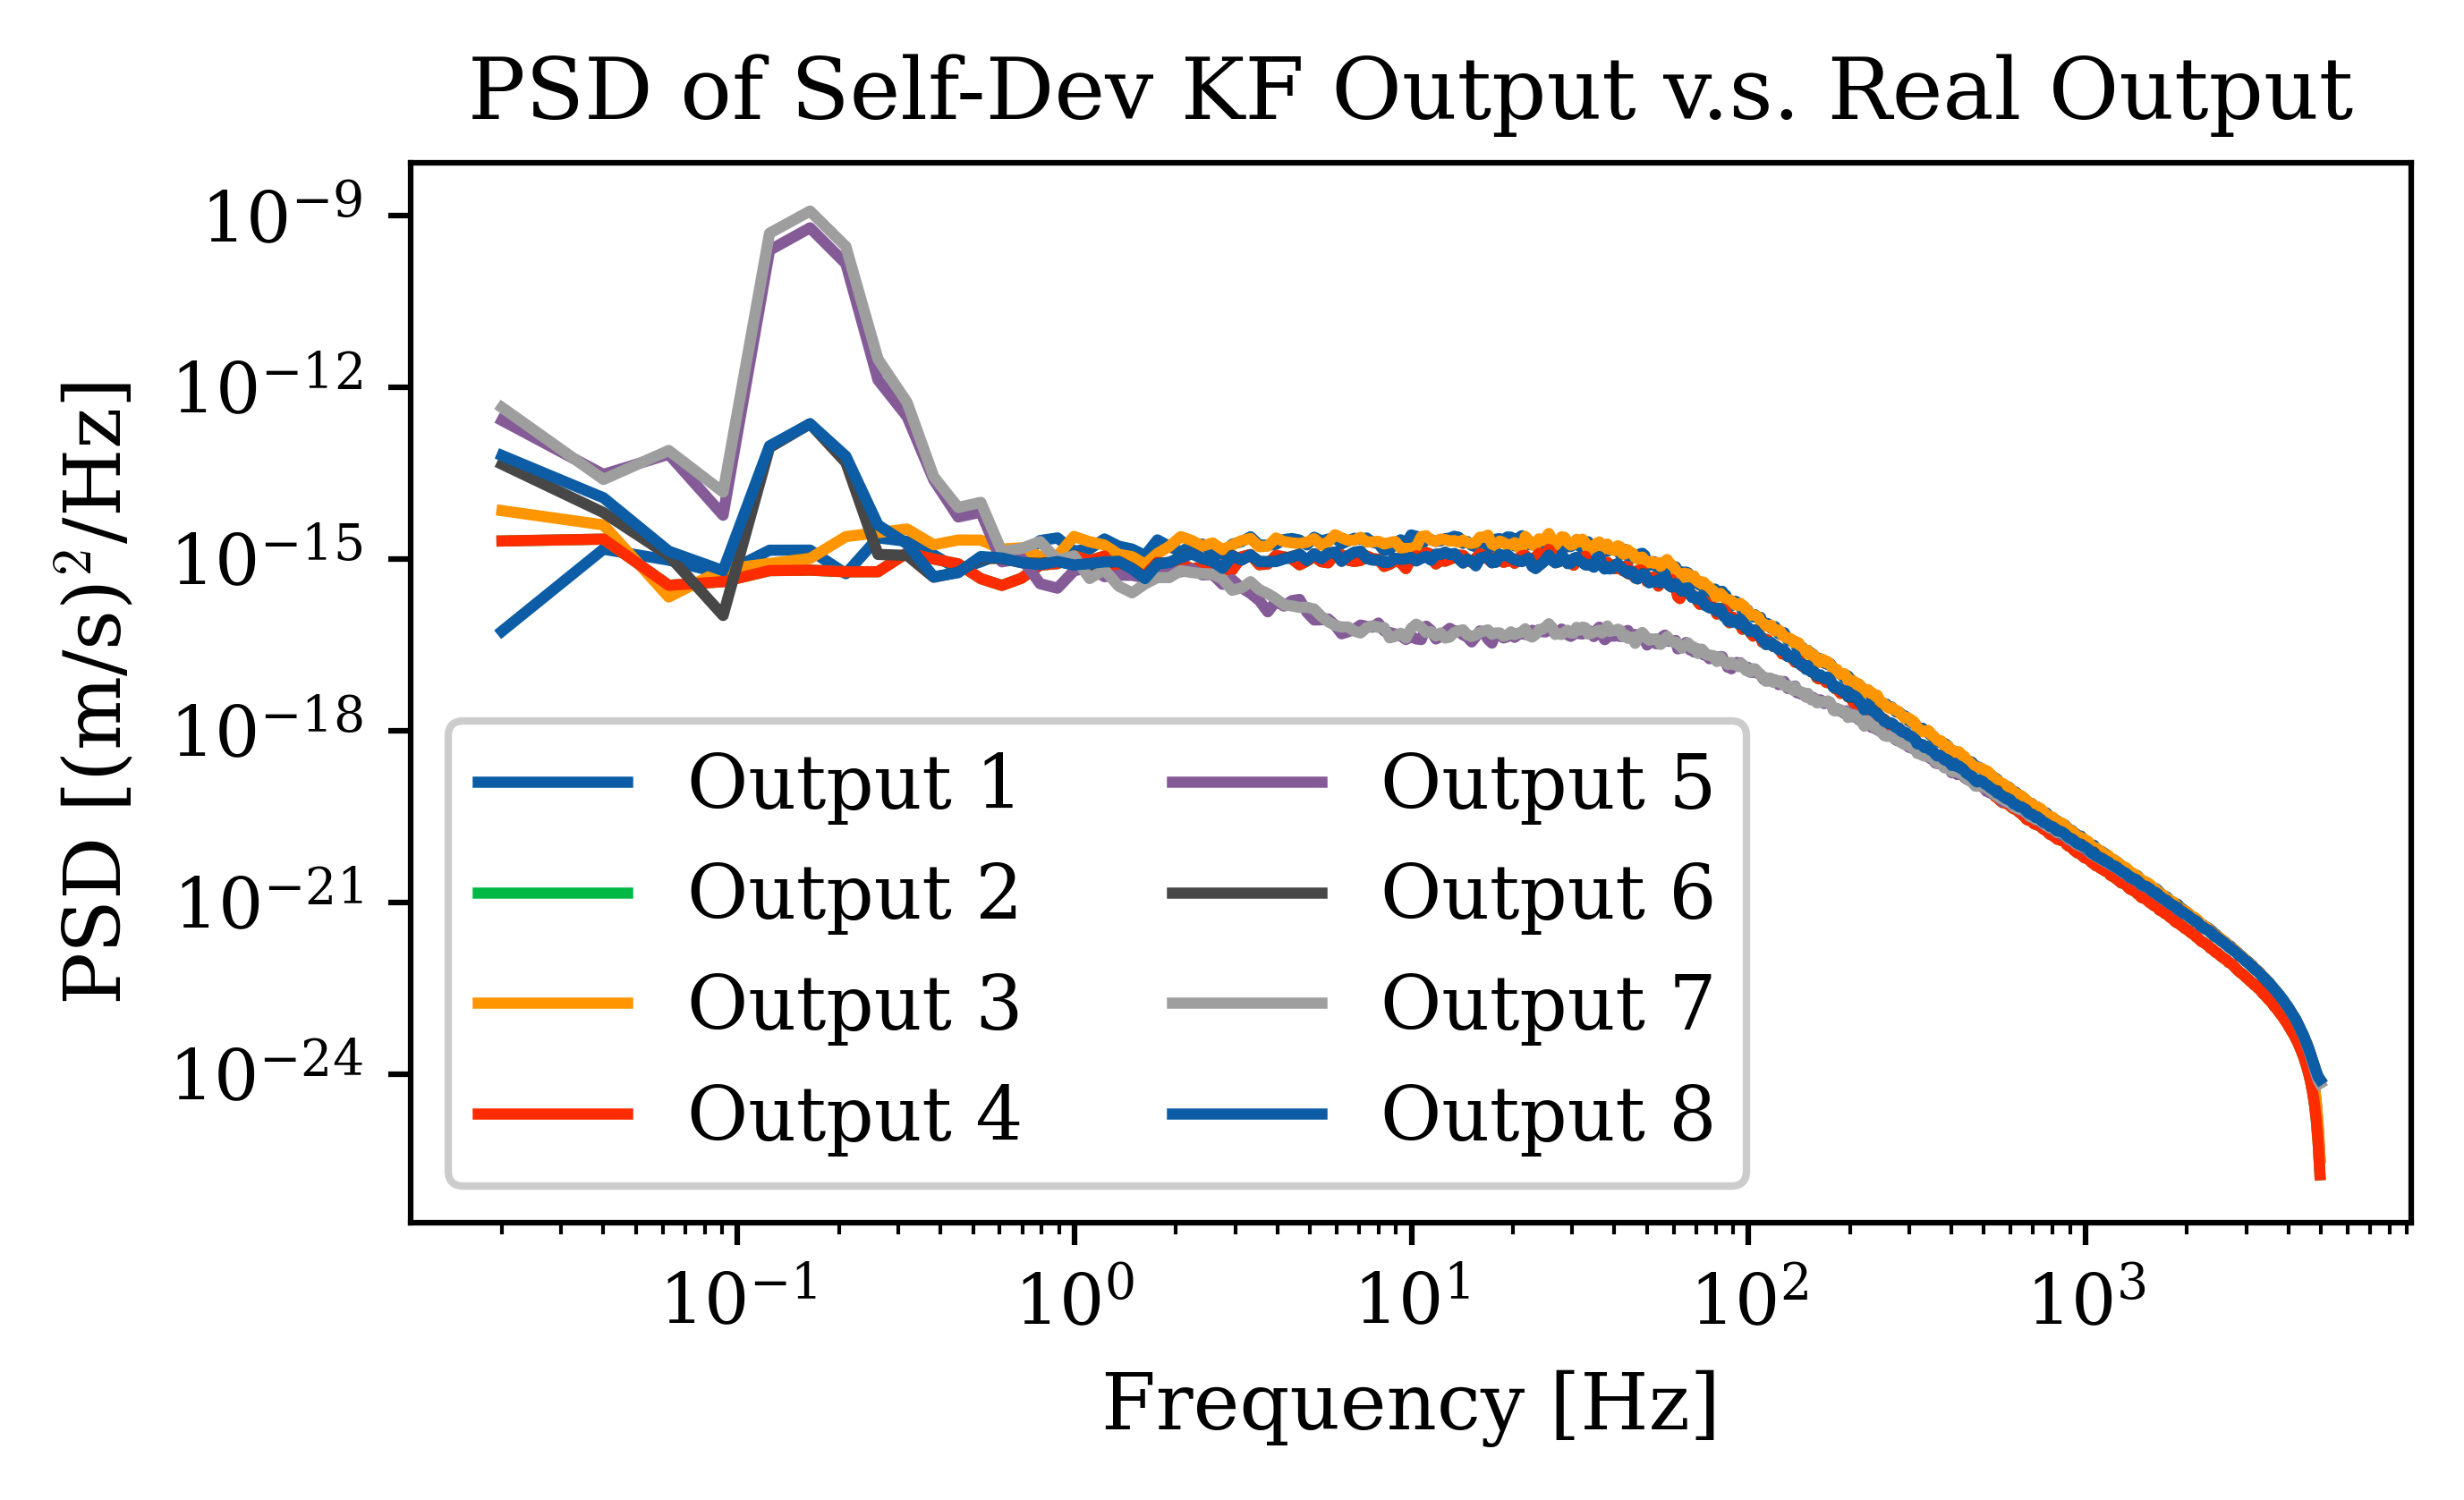

In [32]:
p_list = []
with mb.temp_style(['ysy_academic','science_color']):    
    plt.figure()
    for i in range(8):
        p = data_ikfpsd['pxx'+str(i+1)].values
        p_list.append(p)
        plt.plot(f1, p, label='Output '+str(i+1), linewidth=1.5)
    plt.legend(ncol=2)
    plt.title('PSD of Self-Dev KF Output v.s. Real Output')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('PSD [(m/s)$^2$/Hz]')
    plt.tight_layout()
    plt.savefig('ikf_result.pdf')
    plt.show()

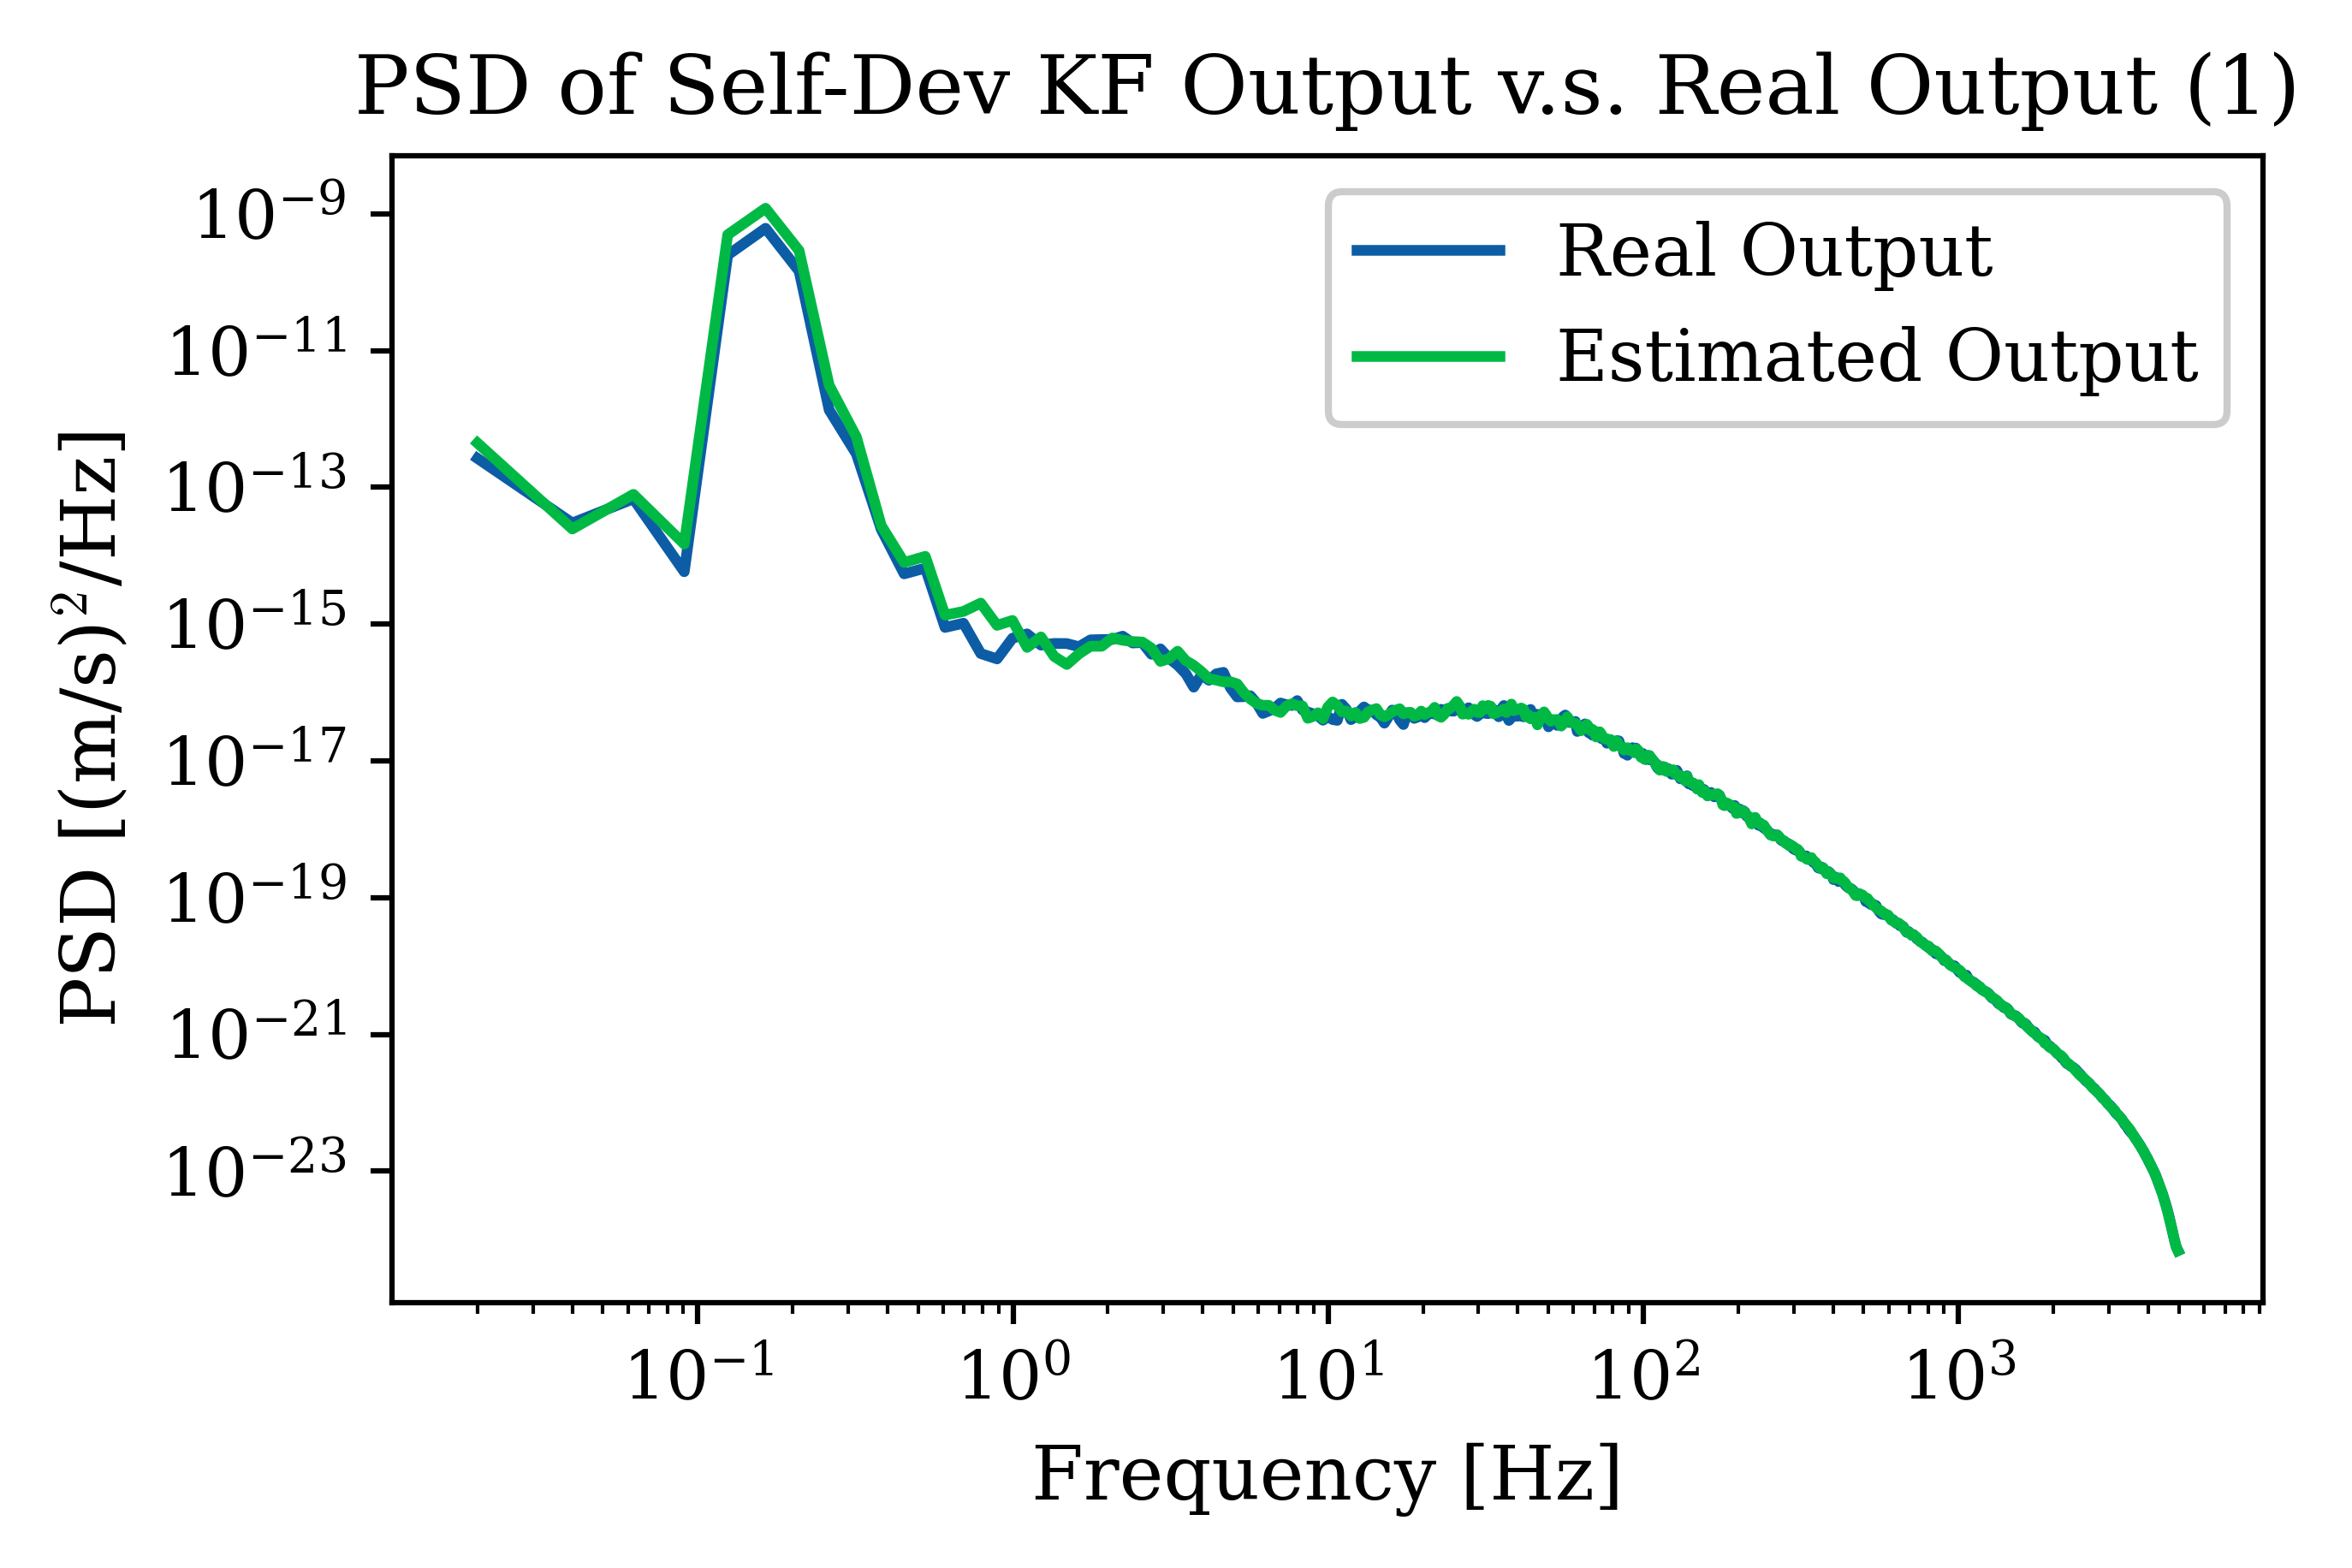

In [24]:
mb.mamplot(
    f1, (p_list[4], p_list[6]), 
    ('Real Output', 'Estimated Output'), 
    'PSD of Self-Dev KF Output v.s. Real Output (1)',
    'Frequency [Hz]', 'PSD [(m/s)$^2$/Hz]',
    xlog=True, ylog=True, svg_save=False, legend_out=False
)

In [4]:
data_nis = pd.read_csv('NIS15s.csv')
data_nis

t       nis
0        0.0001  0.000000
1        0.0002  0.000383
2        0.0003  0.001864
3        0.0004  0.003395
4        0.0005  0.004615
...         ...       ...
149995  14.9996  0.133564
149996  14.9997  0.128909
149997  14.9998  0.128250
149998  14.9999  0.133901
149999  15.0000  0.145361

[150000 rows x 2 columns]

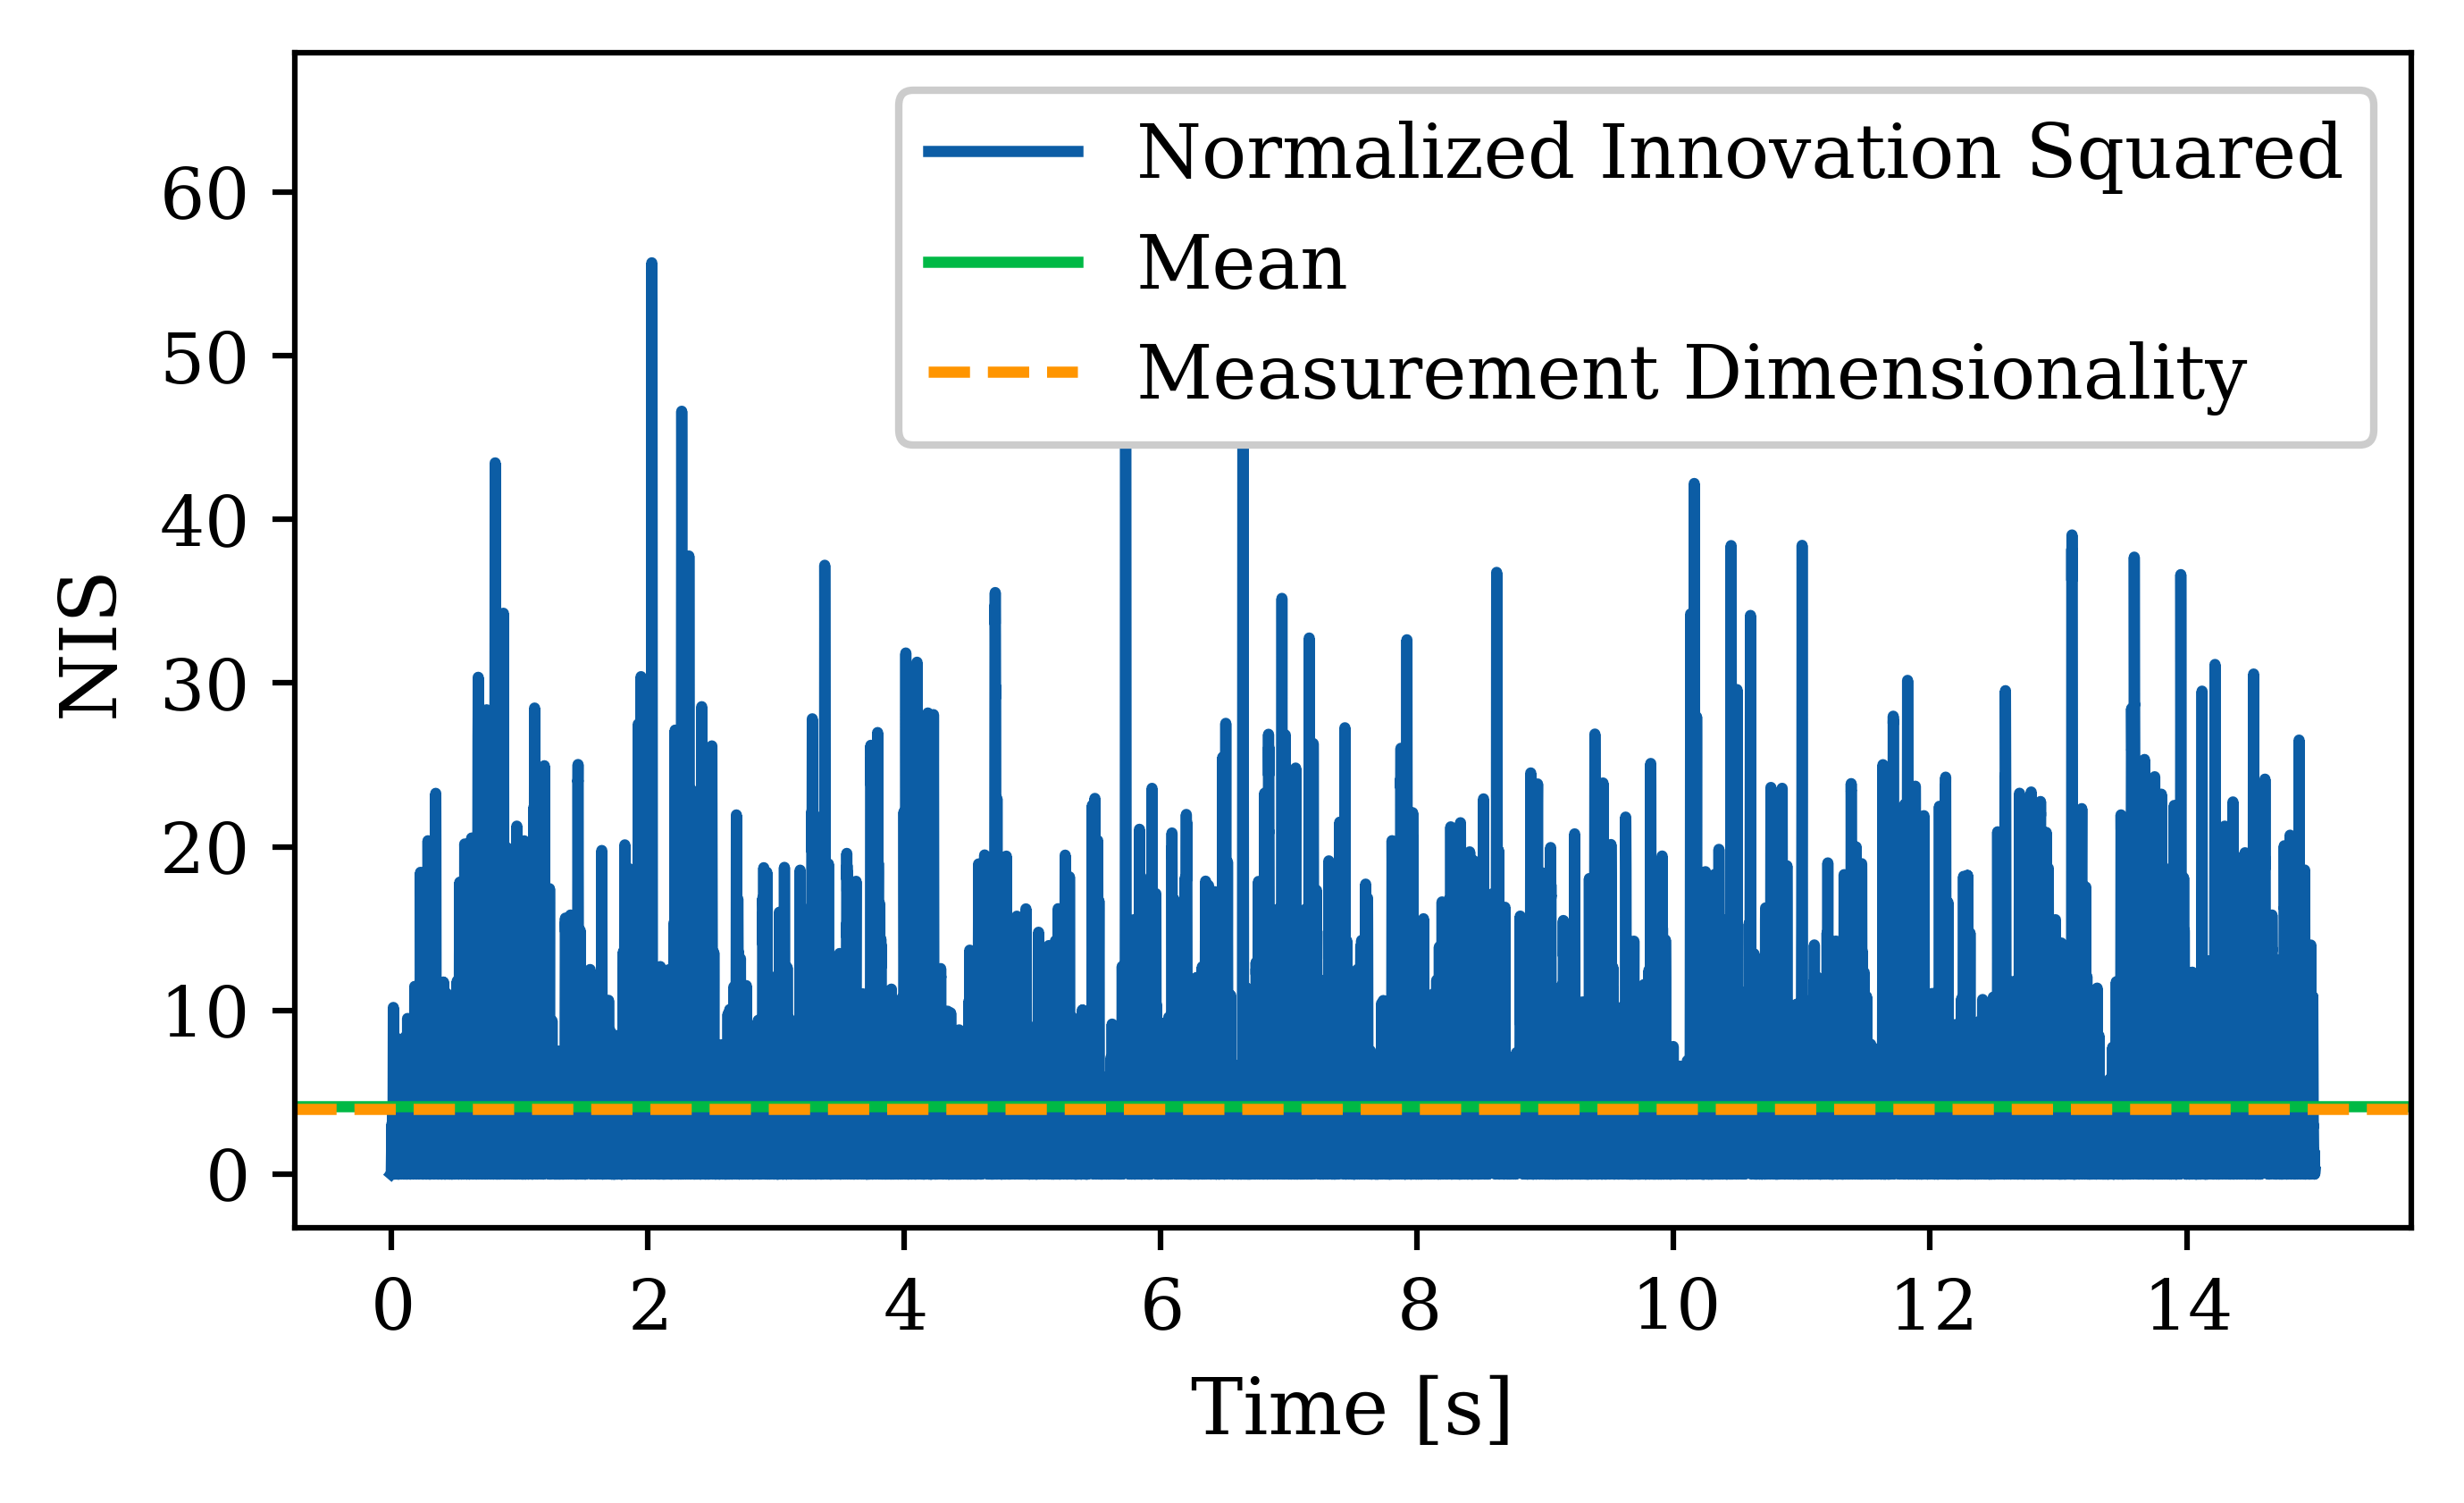

In [17]:
t = data_nis['t'].values
nis = data_nis['nis'].values

with mb.temp_style(['ysy_academic', 'science_color']):
    plt.figure()
    plt.plot(t, nis, label='Normalized Innovation Squared')
    plt.axhline(y=4.120, color='C1', label='Mean')
    plt.axhline(y=4, color='C2', label='Measurement Dimensionality', linestyle='--')
    plt.xlabel('Time [s]')
    plt.ylabel('NIS')
    plt.legend()
    plt.tight_layout()
    plt.savefig('nis.pdf')
    plt.show()

In [18]:
data_innov = pd.read_csv('innov_psd.csv')
data_innov

f      VL_innov      HL_innov      VR_innov      HR_innov
0       0.050000  4.729372e-22  2.474122e-15  5.636556e-22  2.473278e-15
1       0.100000  6.560779e-21  1.761803e-15  6.698370e-21  1.760904e-15
2       0.154099  4.261352e-21  2.528715e-16  4.435440e-21  2.530556e-16
3       0.221256  2.198764e-19  2.129106e-15  2.162799e-19  2.125925e-15
4       0.301727  1.514449e-19  8.181725e-16  1.508869e-19  8.166544e-16
..           ...           ...           ...           ...           ...
439  4751.975903  1.041149e-23  8.400139e-23  1.073995e-23  8.410165e-23
440  4807.224522  9.405470e-24  8.275114e-23  9.515673e-24  8.274576e-23
441  4863.090443  8.538420e-24  8.016978e-23  8.752701e-24  8.025819e-23
442  4919.587619  8.147284e-24  8.047967e-23  8.190751e-24  8.049463e-23
443  4976.730476  7.988259e-24  8.046733e-23  7.956141e-24  8.041998e-23

[444 rows x 5 columns]

In [19]:
f3 = data_innov['f']
VL_innov = data_innov['VL_innov']
HL_innov = data_innov['HL_innov']
VR_innov = data_innov['VR_innov']
HR_innov = data_innov['HR_innov']

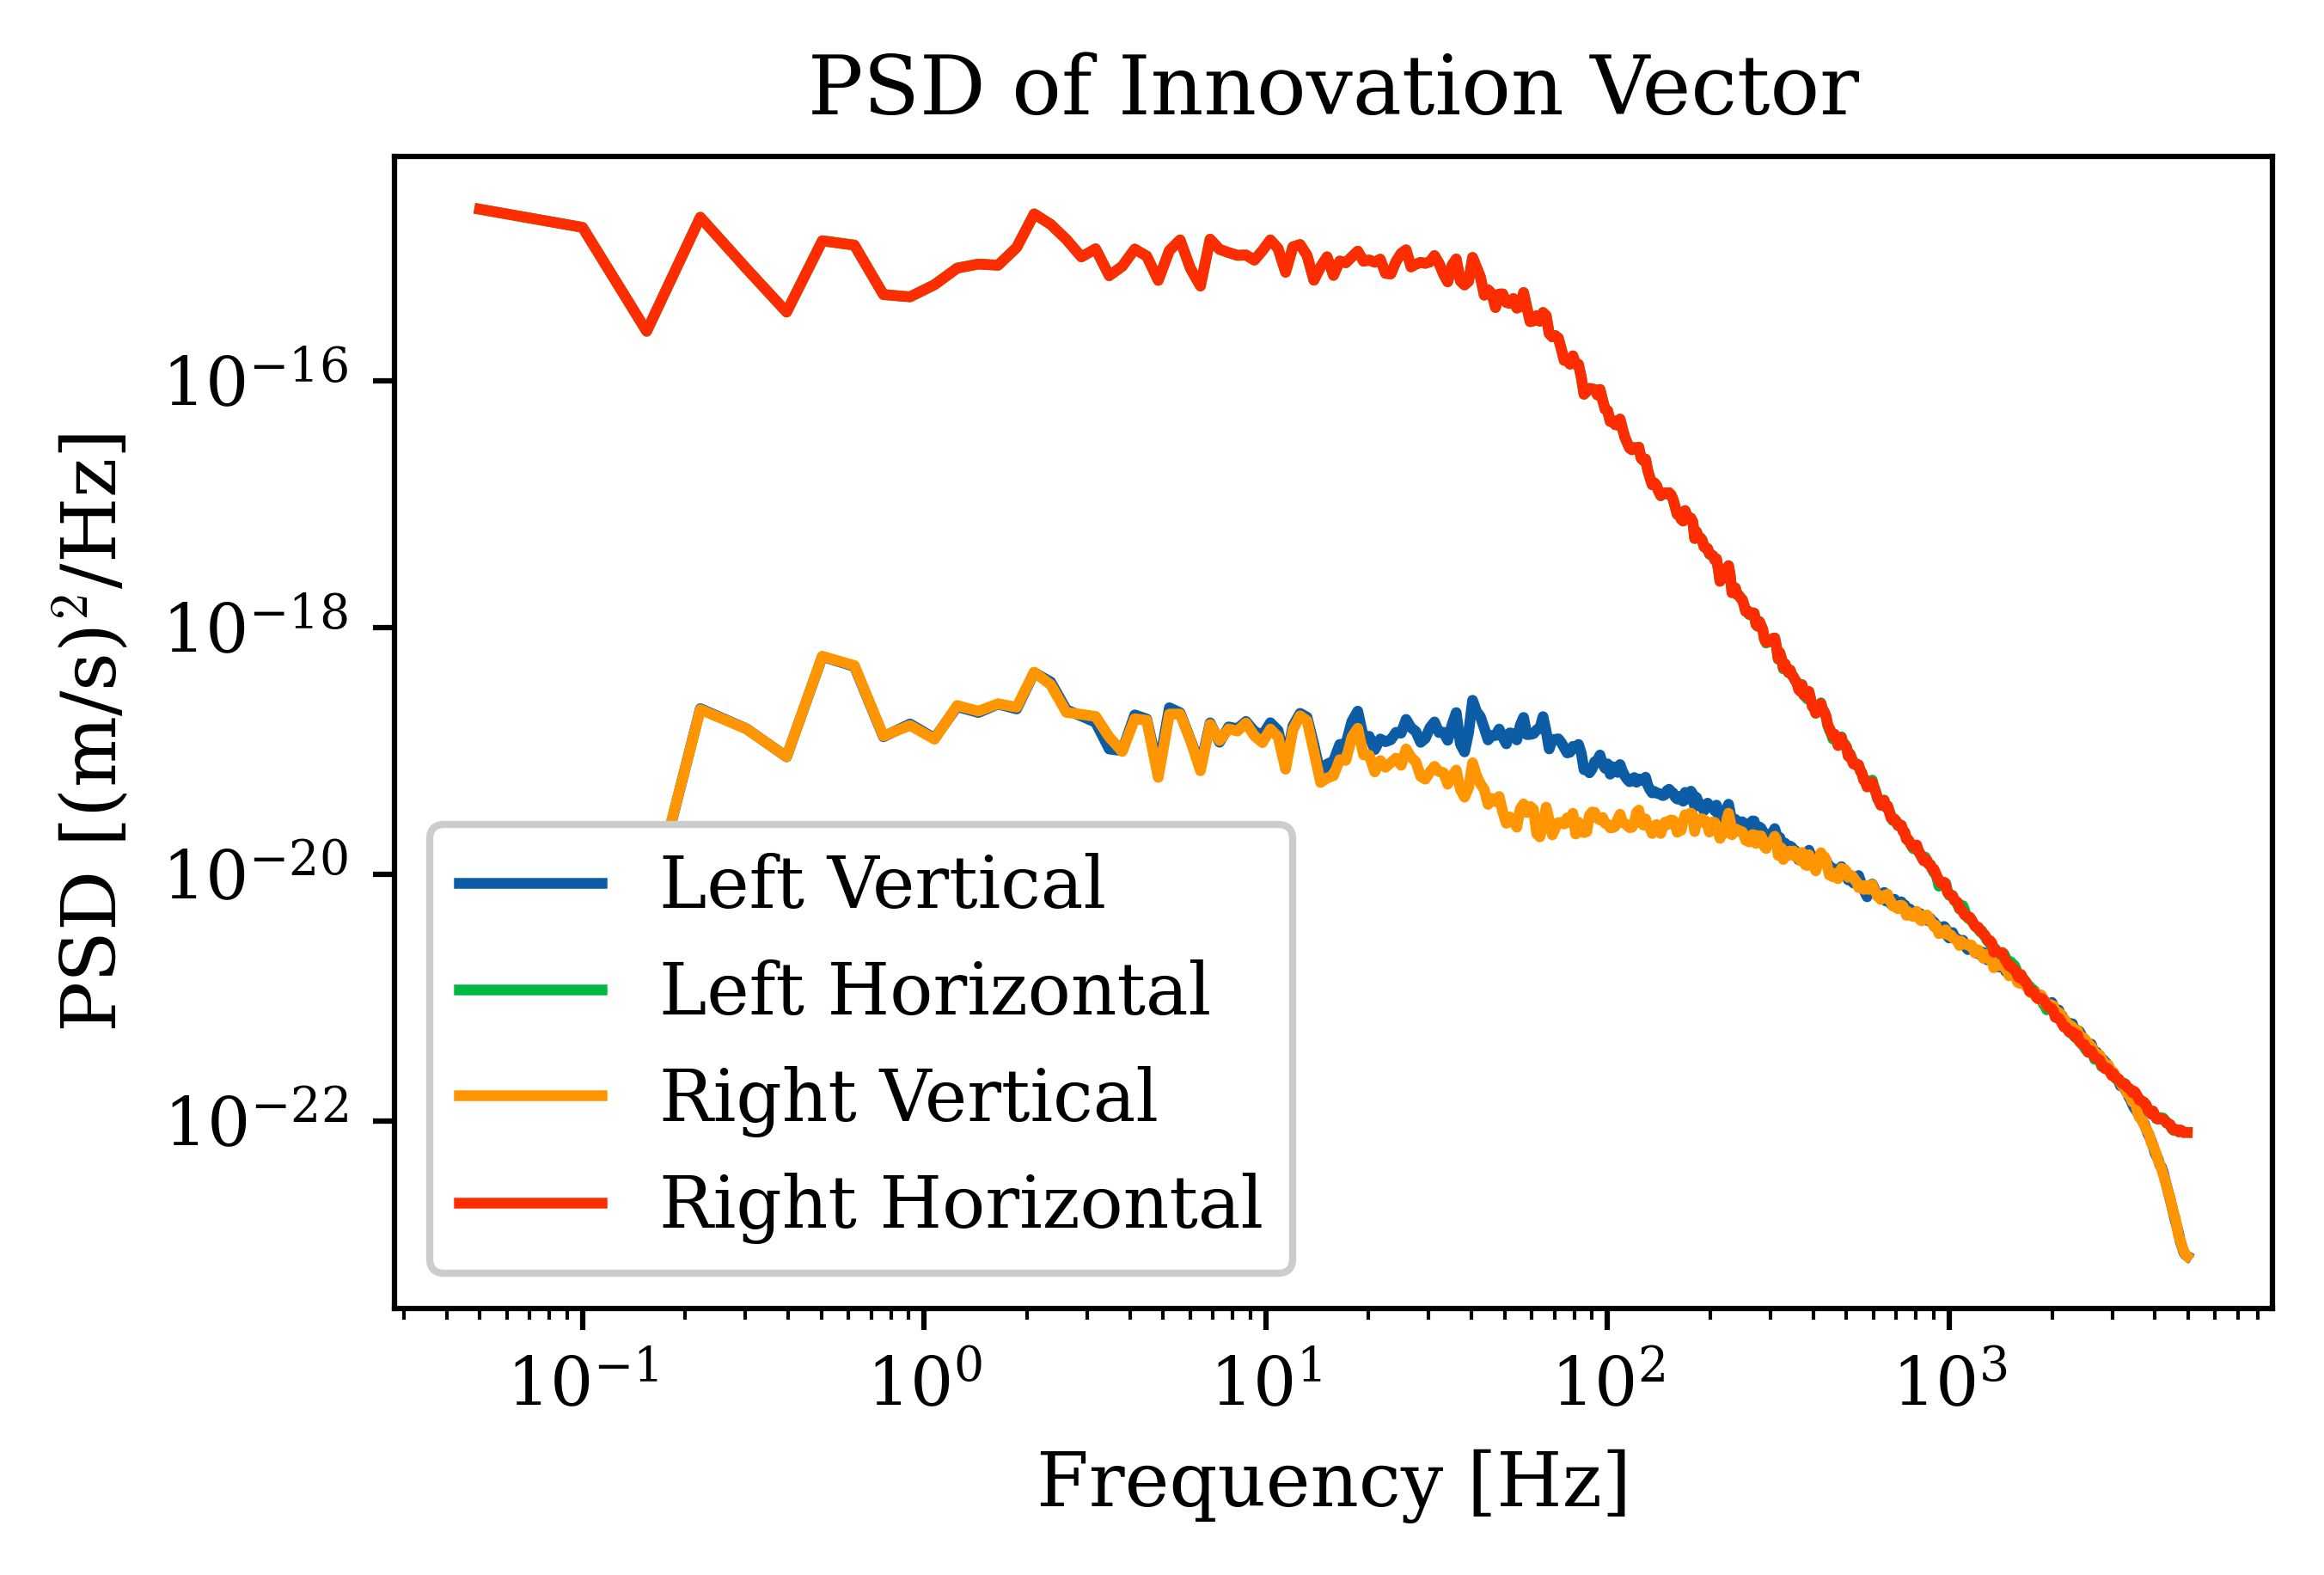

In [21]:
mb.mamplot(
    f3, (VL_innov, HL_innov, VR_innov, HR_innov), 
    ('Left Vertical', 'Left Horizontal', 'Right Vertical', 'Right Horizontal'), 
    'PSD of Innovation Vector',
    'Frequency [Hz]', 'PSD [(m/s)$^2$/Hz]',
    xlog=True, ylog=True, svg_save=True, legend_out=False
)

## SISO LQG

In [3]:
data_sl = pd.read_csv('course_work_real_delqg_closeloop_simulink_sim_output_data_202512191915.csv')
data_sl

t          y_Vc          y_Vd           y_H            ns
0          0.0000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
1          0.0001 -2.348762e-09 -2.834342e-09 -2.815845e-09 -5.121846e-09
2          0.0002 -5.117125e-09 -1.031837e-08 -1.007655e-08 -1.537076e-08
3          0.0003 -6.823620e-09 -1.889427e-08 -1.796819e-08 -2.572169e-08
4          0.0004 -7.925644e-09 -2.720209e-08 -2.497101e-08 -3.517586e-08
...           ...           ...           ...           ...           ...
2999996  299.9996  2.038339e-08 -2.033149e-08 -2.447394e-08 -7.842654e-08
2999997  299.9997  2.436440e-08 -2.064941e-08 -2.213761e-08 -7.273130e-08
2999998  299.9998  2.891500e-08 -2.265503e-08 -2.183656e-08 -6.842233e-08
2999999  299.9999  3.217246e-08 -2.460877e-08 -2.158673e-08 -6.538334e-08
3000000  300.0000  3.188342e-08 -2.537962e-08 -2.034221e-08 -6.493231e-08

[3000001 rows x 5 columns]

In [5]:
t = data_sl['t'].values
y_Vc = data_sl['y_Vc'].values
y_Vd = data_sl['y_Vd'].values
y_H = data_sl['y_H'].values
ns = data_sl['ns'].values

In [19]:
dt = t[1] - t[0]
fs = 1/dt
T = np.max(t)
L = len(t)
Delta_f = 0.05
T_eff = 1/Delta_f
M = fs * T_eff
print('The Welch K: ', L/M)

The Welch K:  15.000005


In [20]:
f, P_Vc = welch(y_Vc, fs=fs, nperseg=M)
_, P_Vd = welch(y_Vd, fs=fs, nperseg=M)
_, P_H = welch(y_H, fs=fs, nperseg=M)
_, P_ns = welch(ns, fs=fs, nperseg=M)

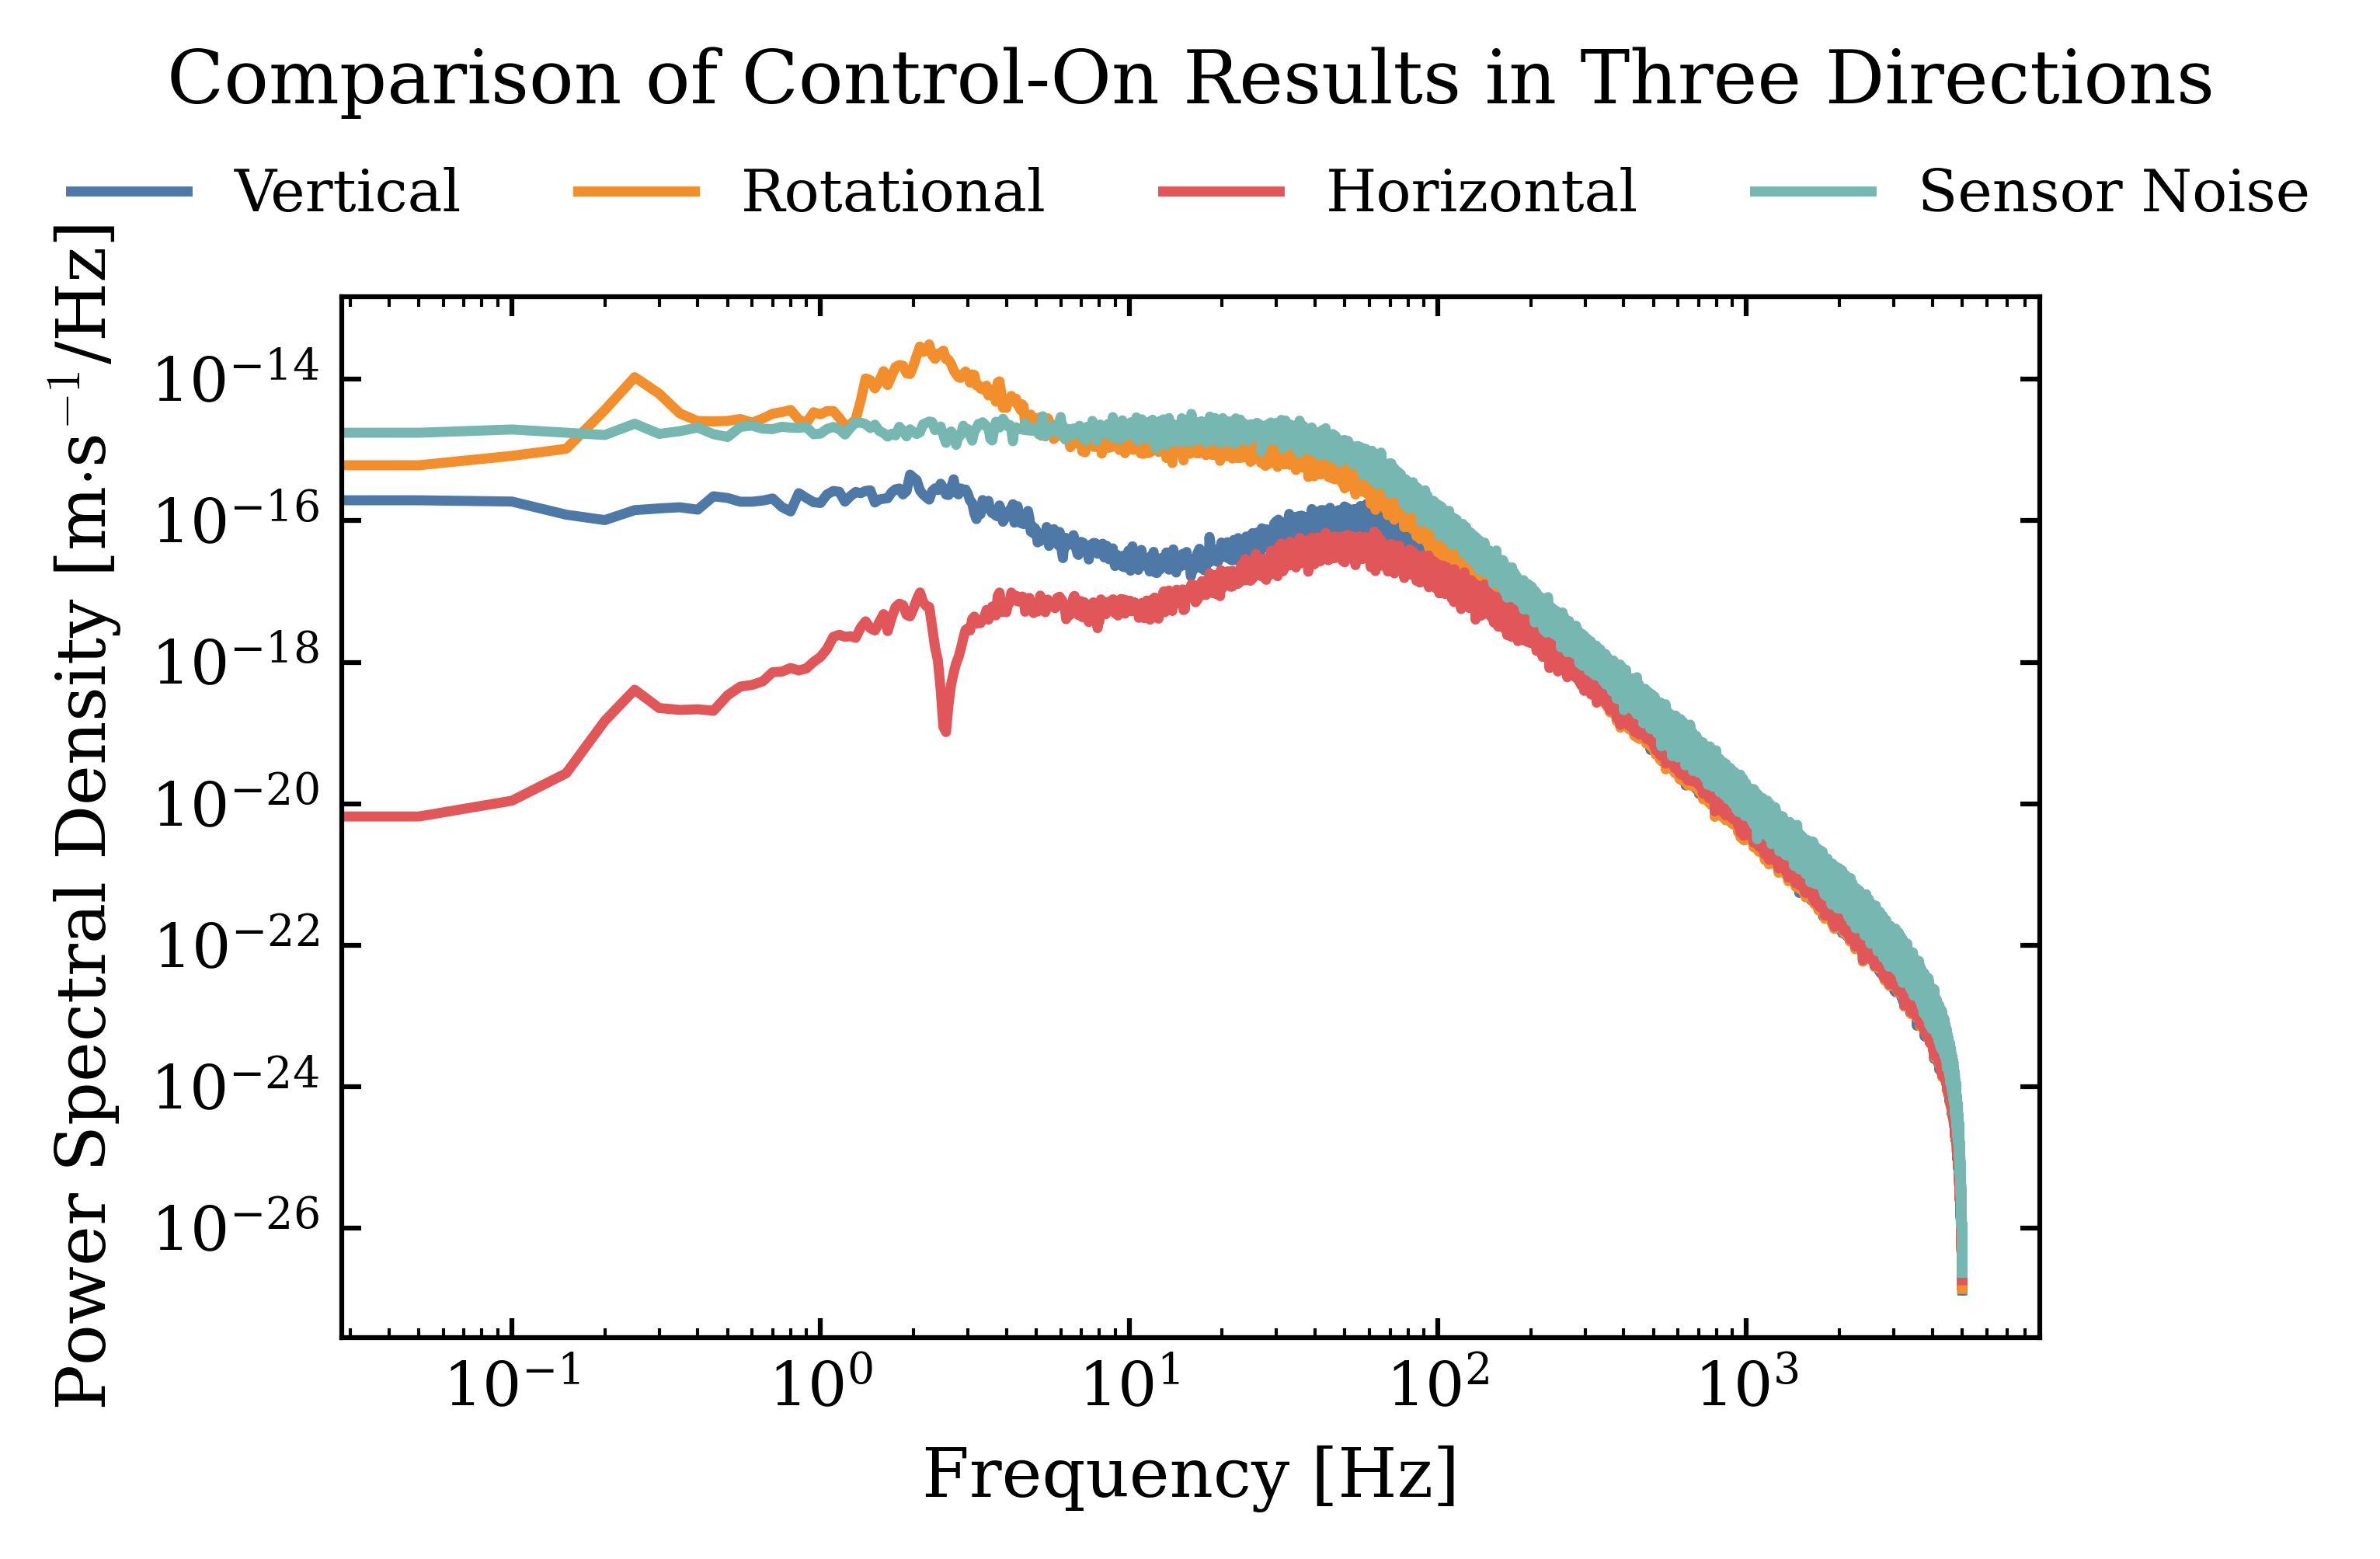

In [21]:
mb.mamplot(
    f, (P_Vc, P_Vd, P_H, P_ns), 
    ('Vertical', 'Rotational', 'Horizontal', 'Sensor Noise'), 
    plot_title='Comparison of Control-On Results in Three Directions', 
    x_label='Frequency [Hz]', y_label='Power Spectral Density [m$\cdot$s$^{-1}$/Hz]',
    logx=True, logy=True, 
    legend_up=True,
)

## Summary

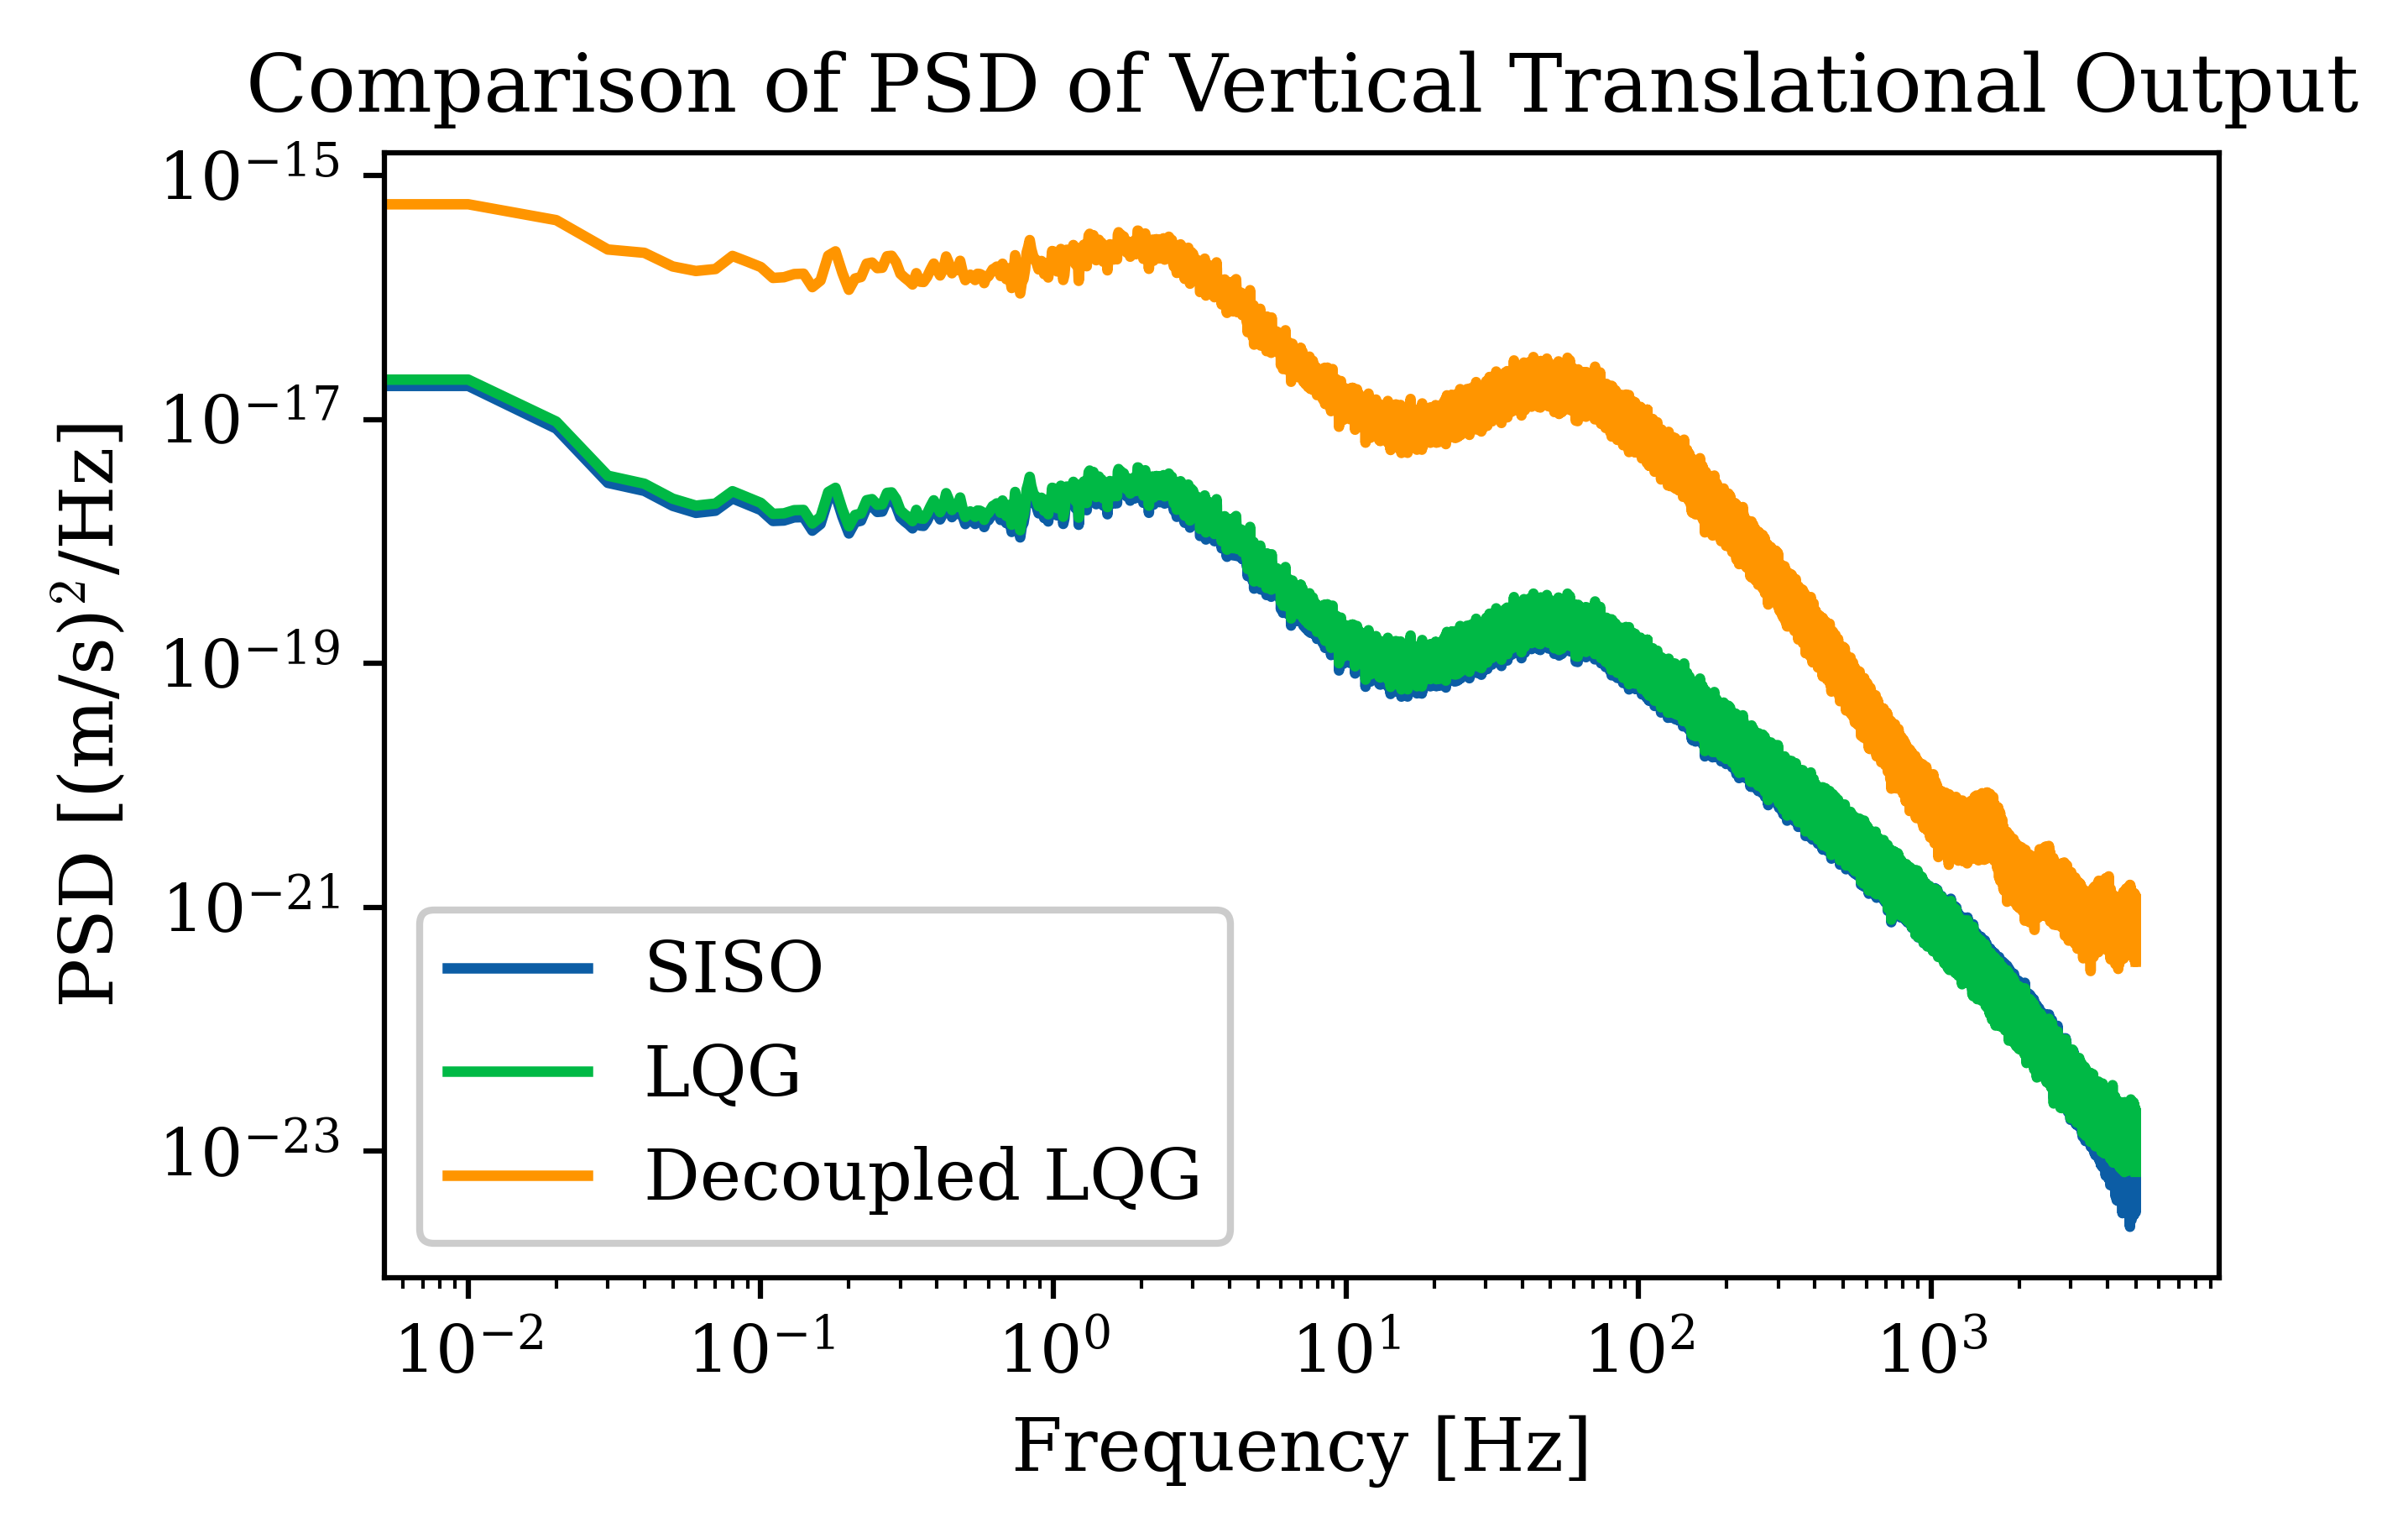

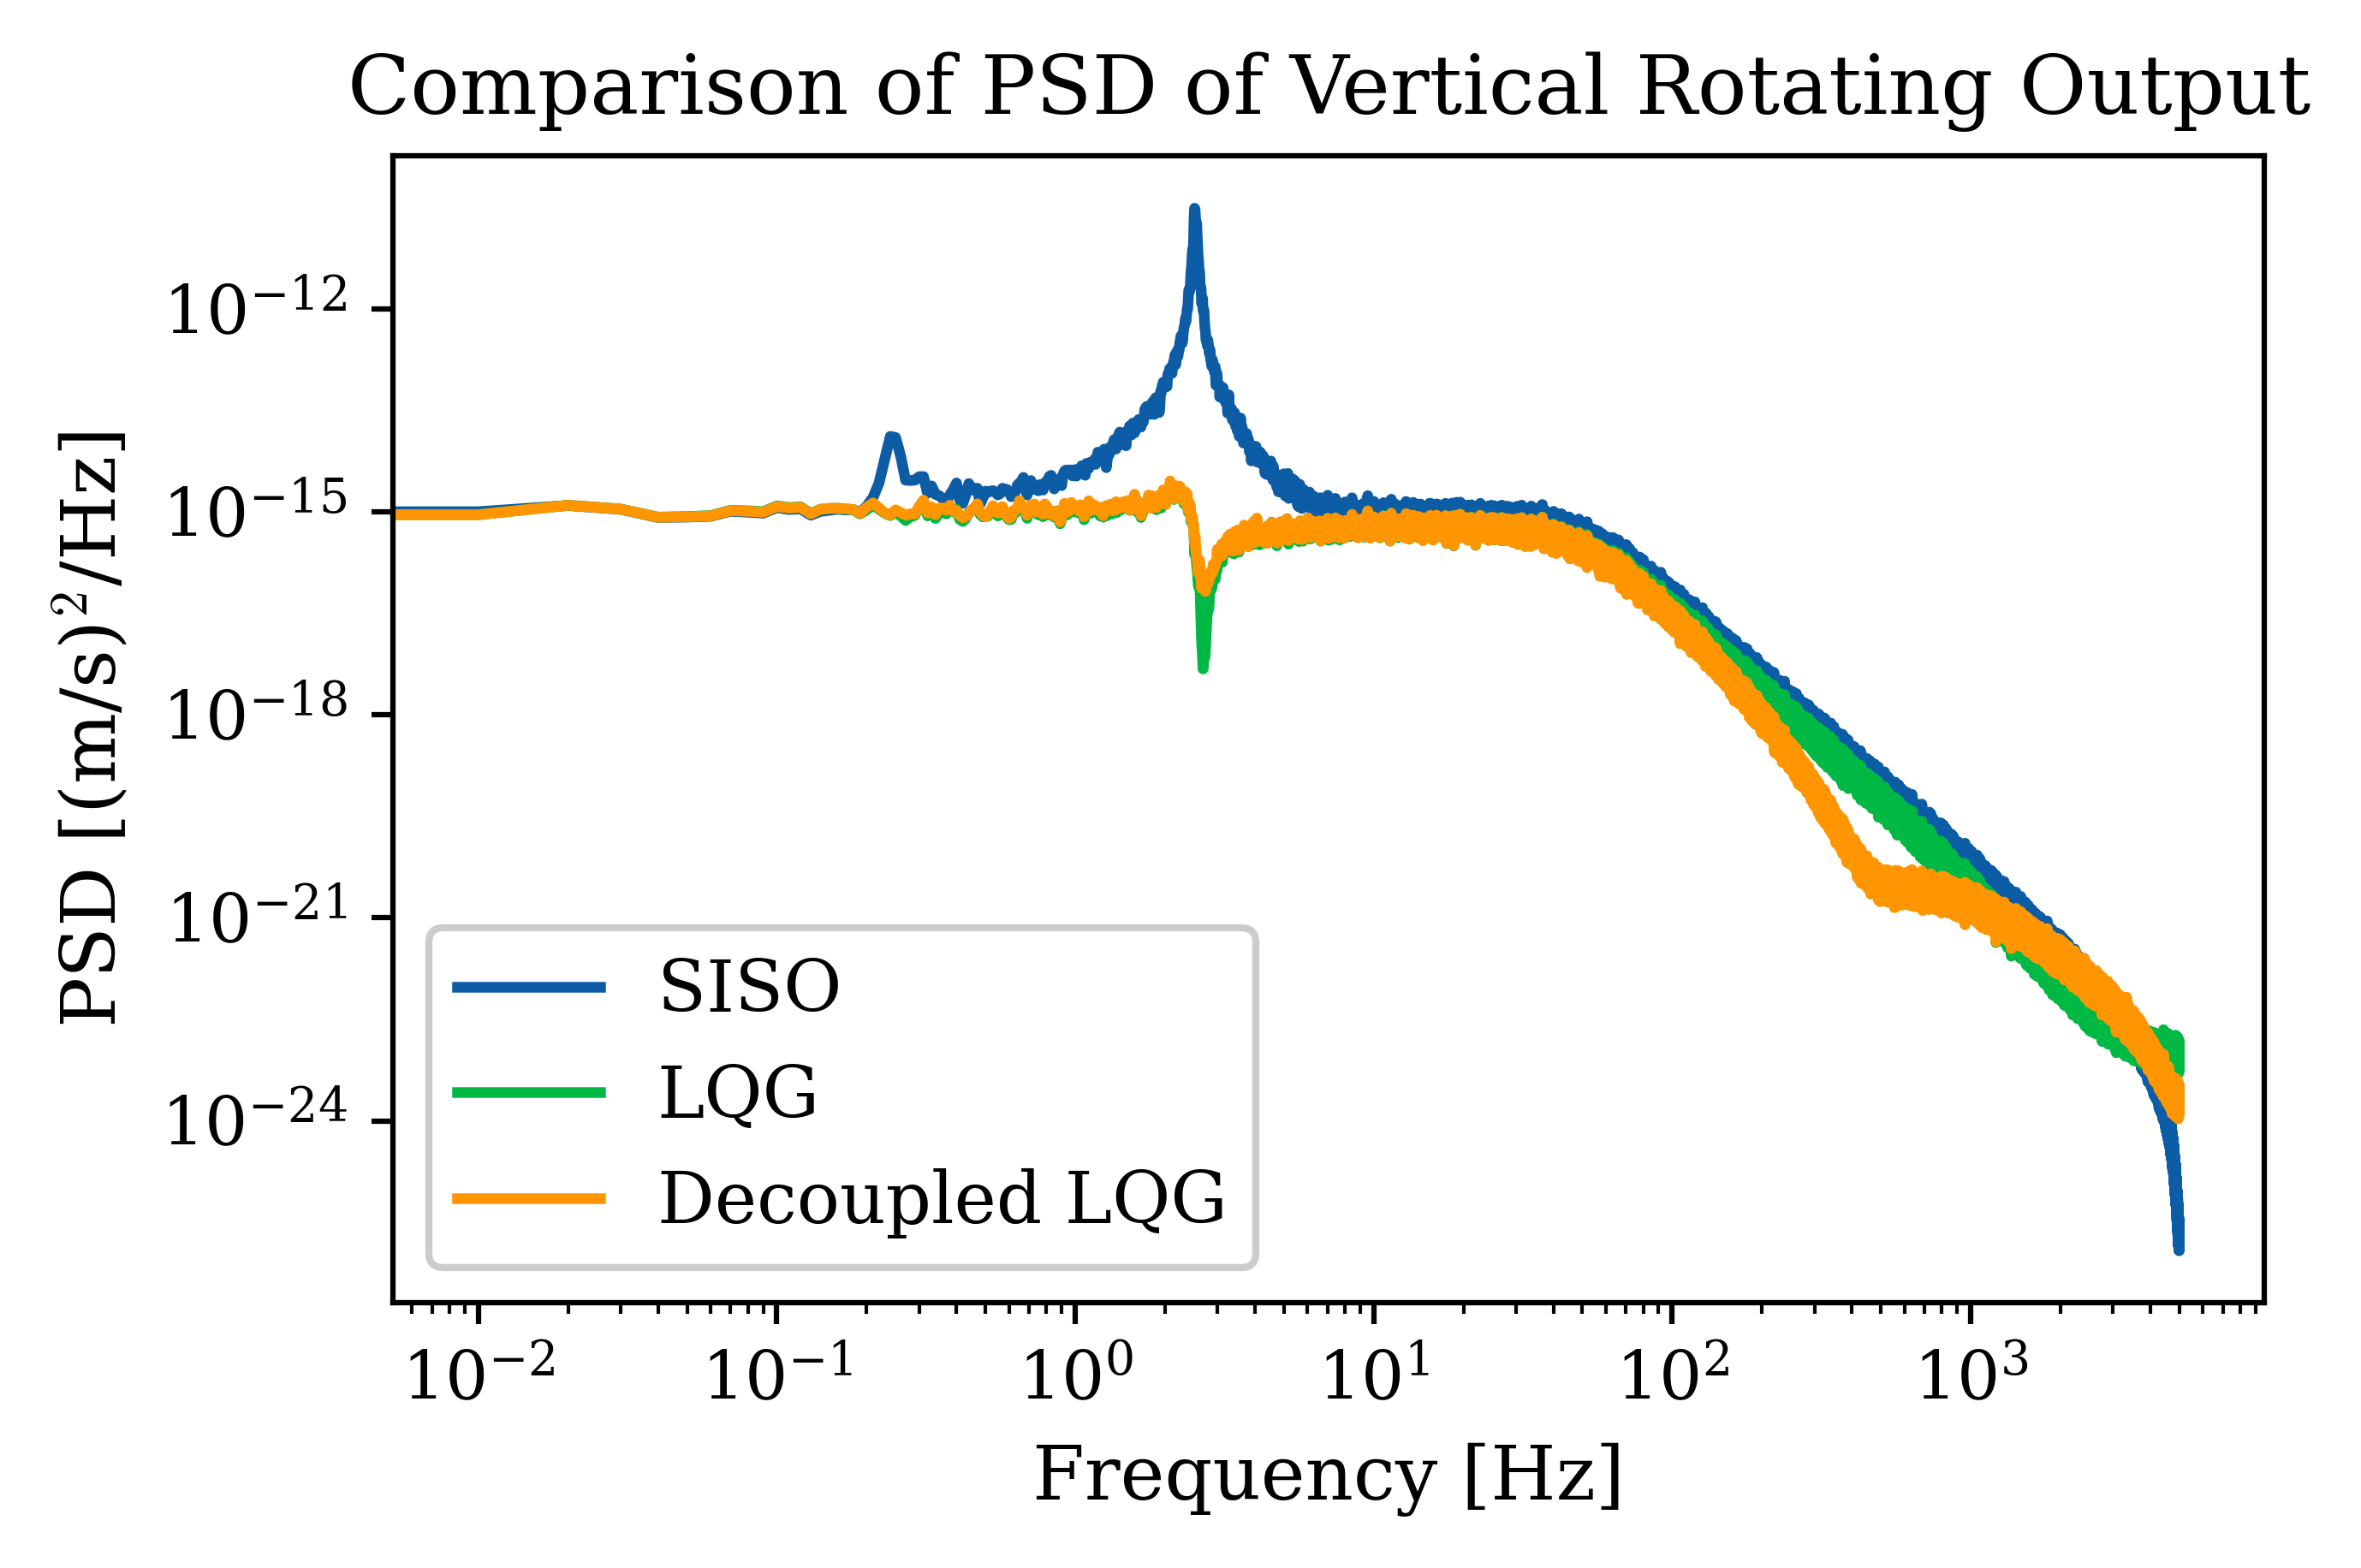

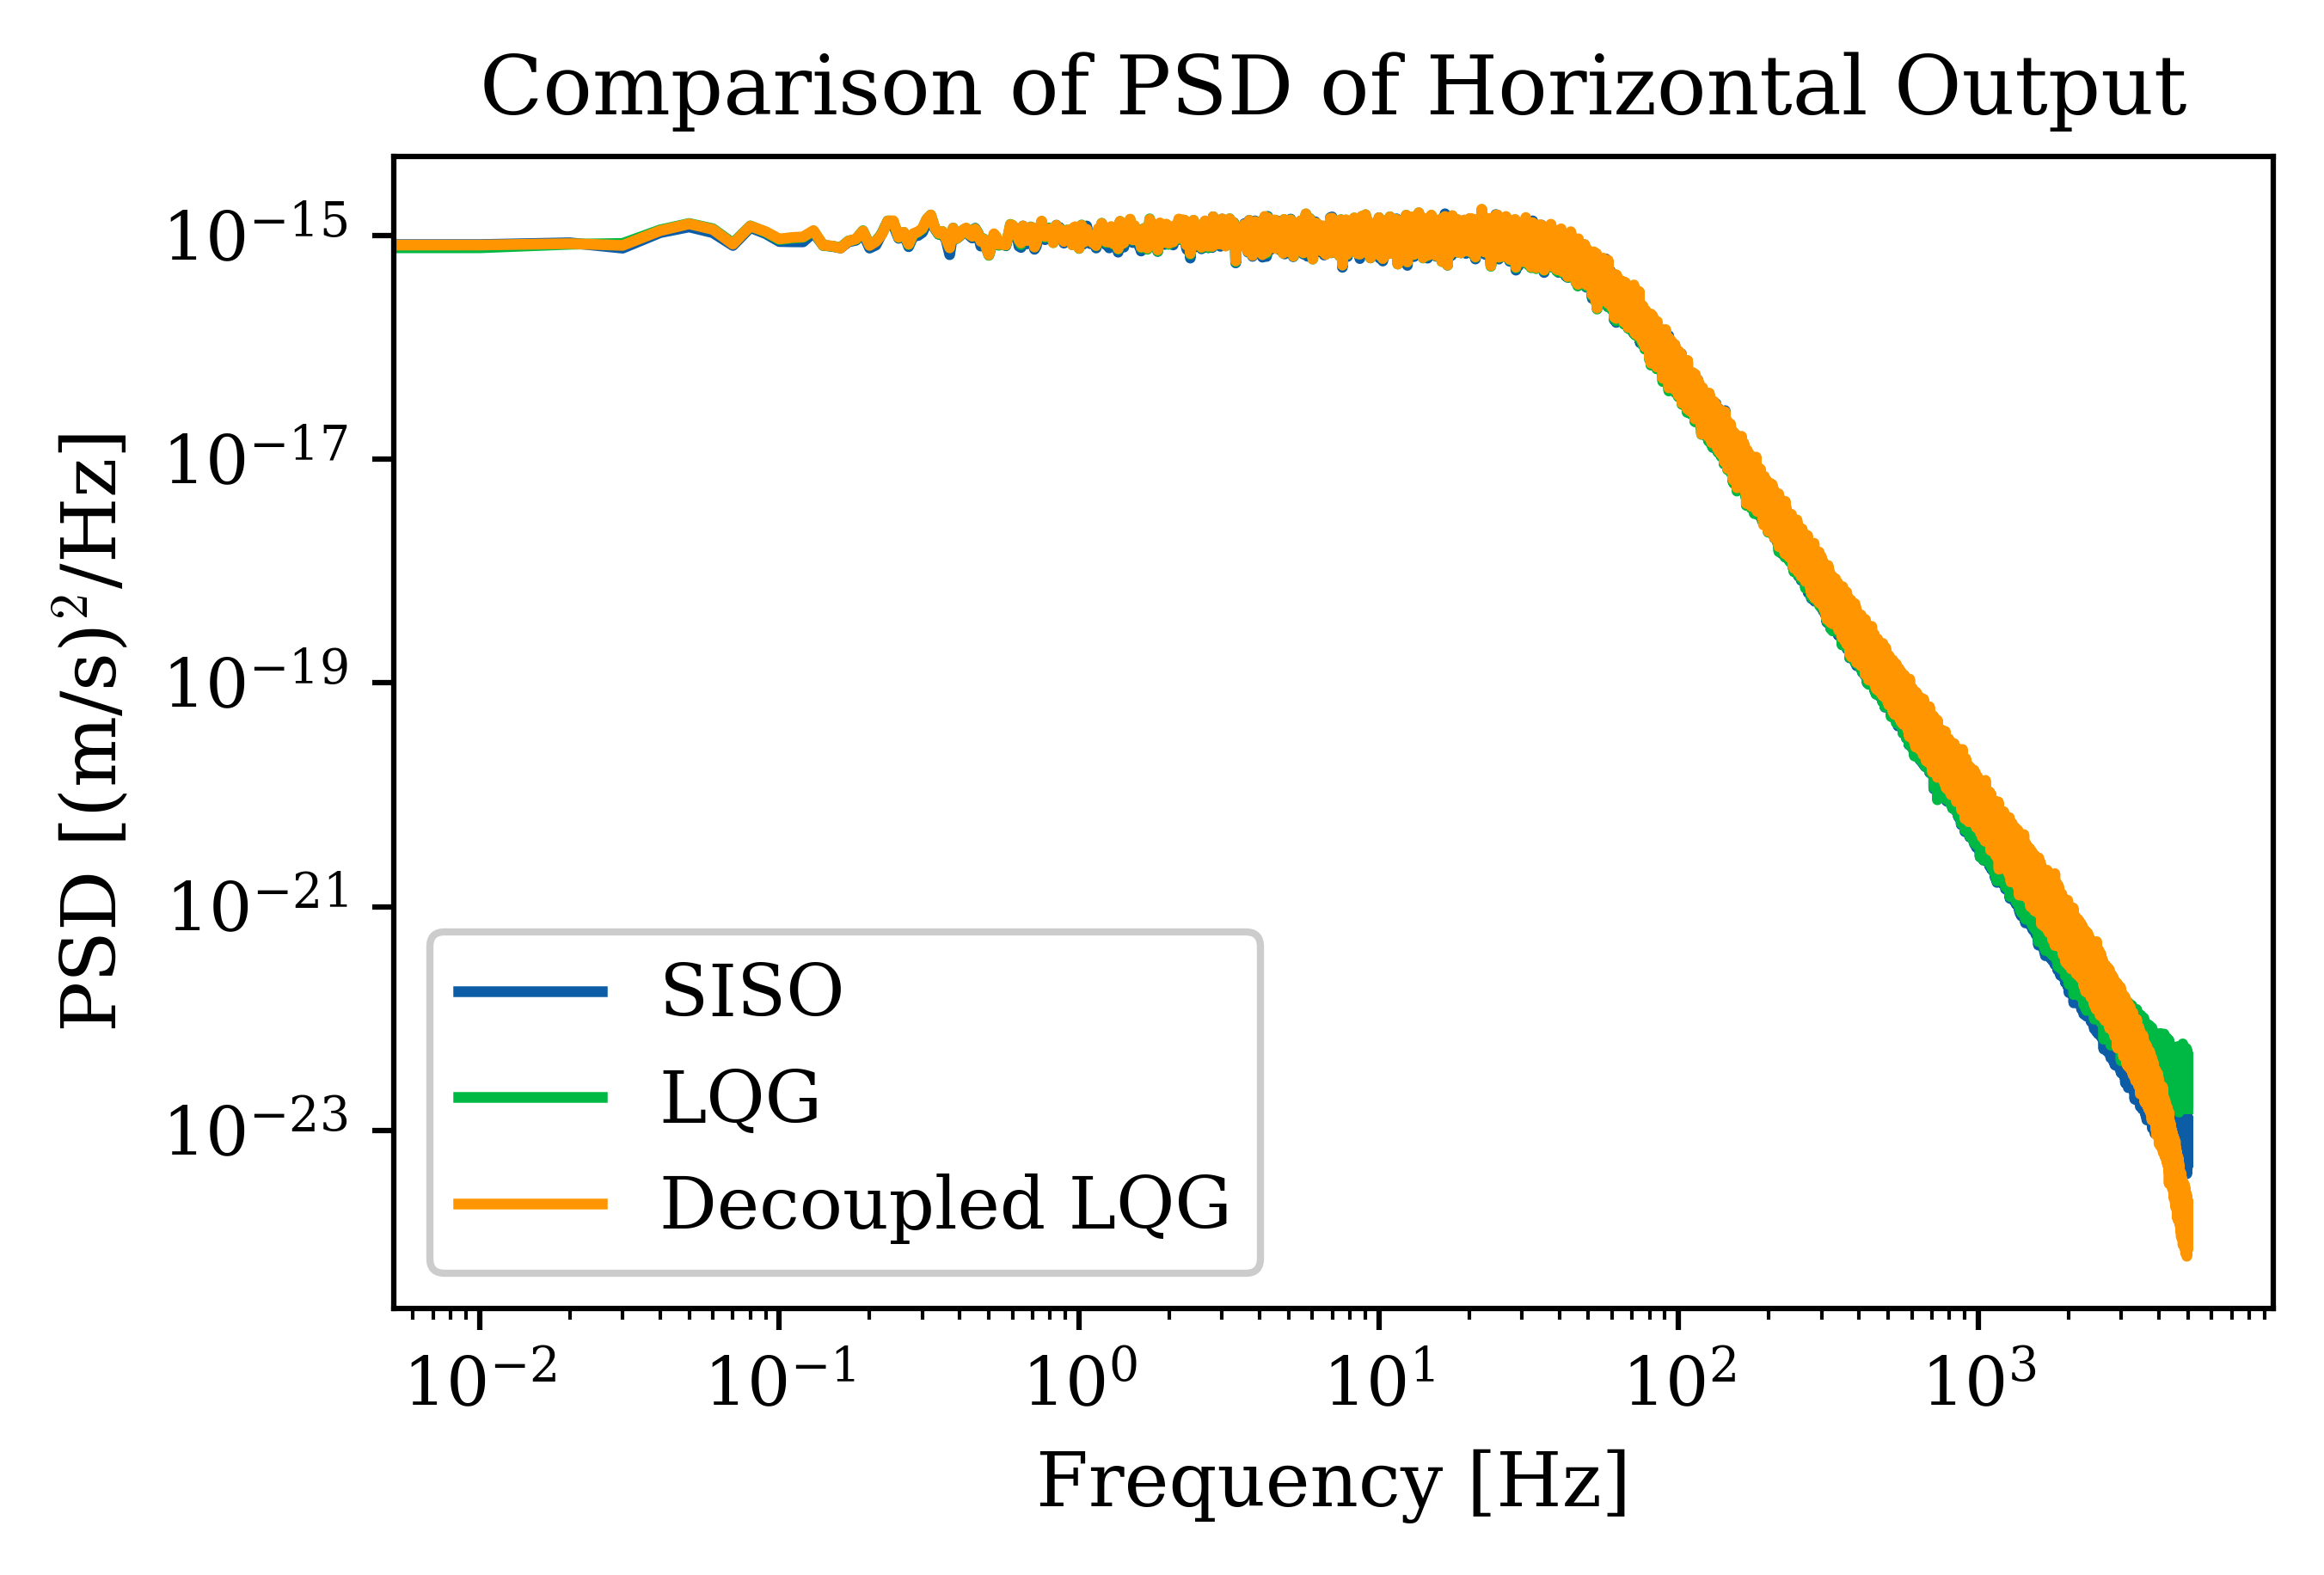

In [21]:
mb.mamplot(
    f, (P_sum_si, P_sum_c2, P_sum_cl3), 
    ('SISO', 'LQG', 'Decoupled LQG'), 
    'Comparison of PSD of Vertical Translational Output',
    'Frequency [Hz]', 'PSD [(m/s)$^2$/Hz]',
    xlog=True, ylog=True, svg_save=True, legend_out=False
)

mb.mamplot(
    f, (P_diff_si, P_diff_c2, P_diff_cl3), 
    ('SISO', 'LQG', 'Decoupled LQG'), 
    'Comparison of PSD of Vertical Rotating Output',
    'Frequency [Hz]', 'PSD [(m/s)$^2$/Hz]',
    xlog=True, ylog=True, svg_save=True, legend_out=False
)

mb.mamplot(
    f, (P_x_si, P_x_c2, P_x_cl3), 
    ('SISO', 'LQG', 'Decoupled LQG'), 
    'Comparison of PSD of Horizontal Output',
    'Frequency [Hz]', 'PSD [(m/s)$^2$/Hz]',
    xlog=True, ylog=True, svg_save=True, legend_out=False
)

## 实测扰动与噪声

In [3]:
grddis_data = pd.read_csv('ground_ts.csv')
t1 = grddis_data['t'].values
h = grddis_data['H'].values
v = grddis_data['V'].values

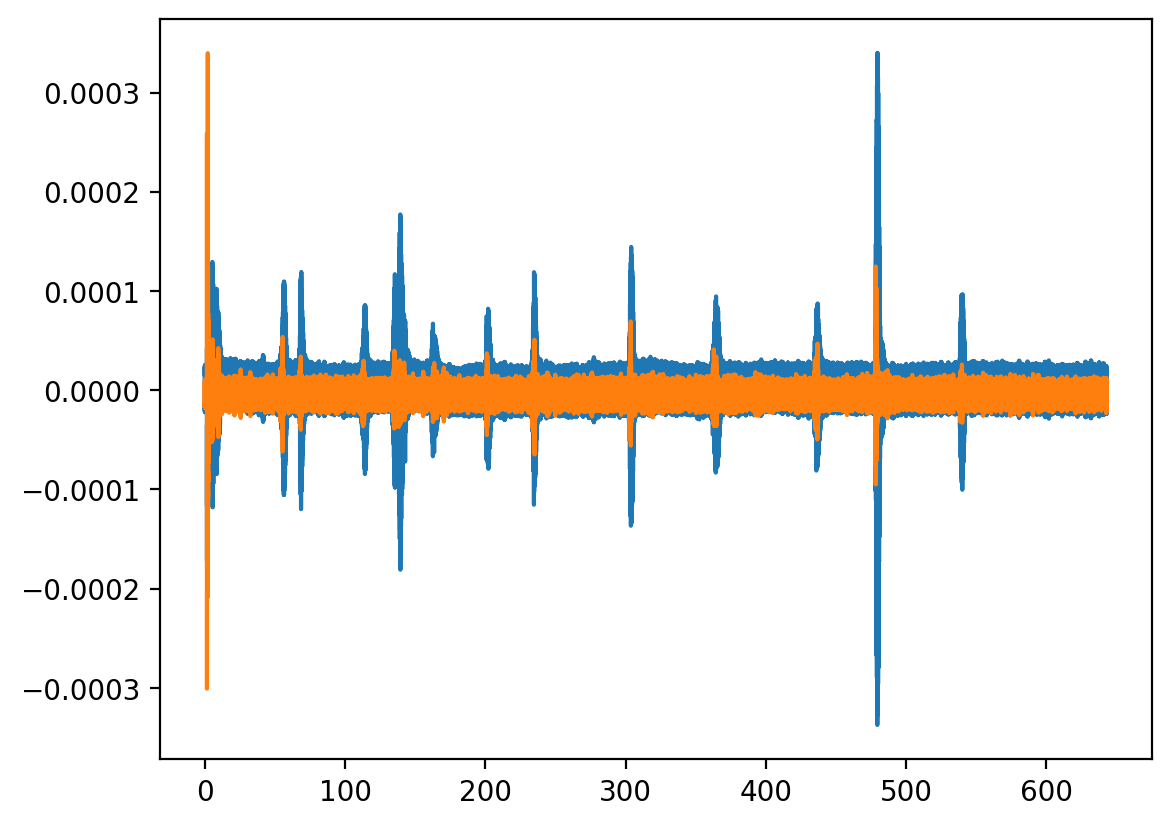

In [4]:
plt.plot(t1, h)
plt.plot(t1, v)

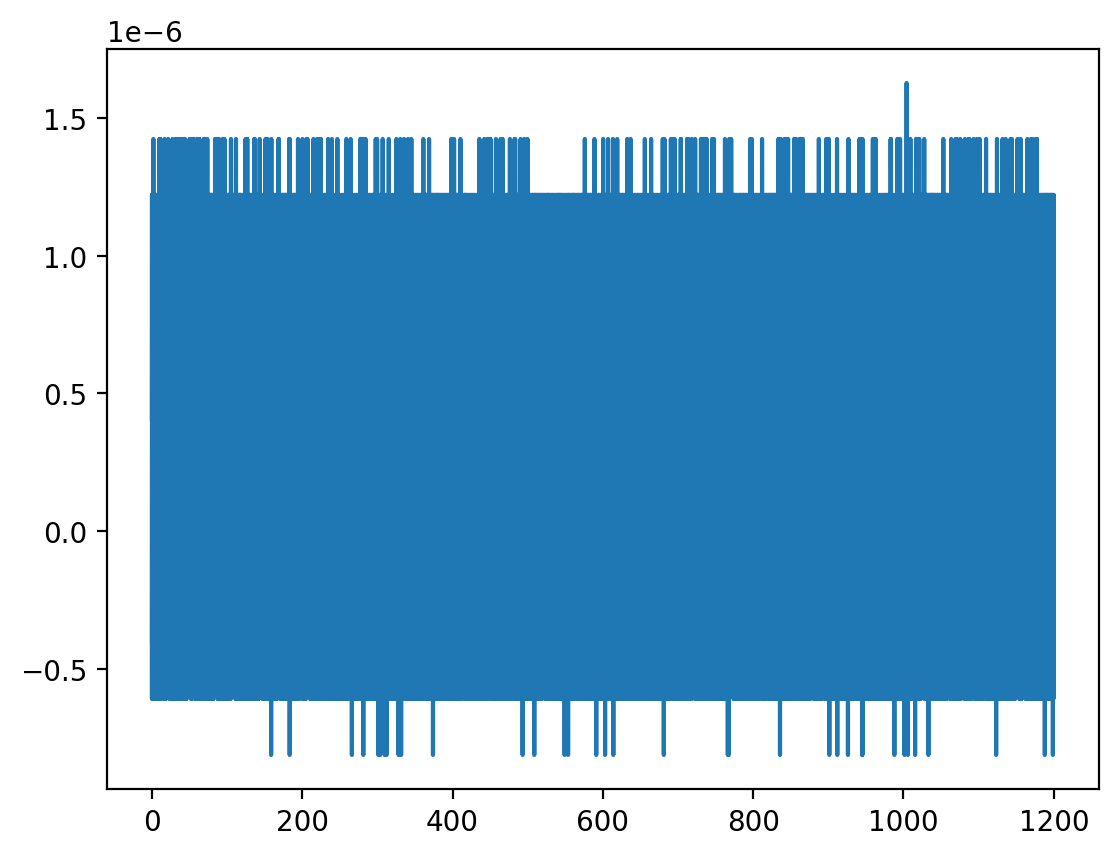

In [5]:
ns_data = pd.read_csv('noise_ts.csv')
t2 = ns_data['t'].values
ns = ns_data['N'].values
plt.plot(t2, ns)

In [ ]:
fs = 10_000
Delta_f = 0.01
M = fs / Delta_f
f2, P_ns = welch(ns, fs=fs, nperseg=M)

fig = iplot(
    f2, P_ns, 
    'ADC Noise', 
    'Power Spectra Density of ADC Noise',
    'Frequency [Hz]', 'PSD [㎡/Hz]',
)
fig.update_xaxes(type="log")
fig.update_yaxes(type="log")
fig.show()

In [ ]:
fs = 10_000
Delta_f = 0.1
M = fs / Delta_f
L = len(t1)
K = L/M
print(K)

f, P_h = welch(h, fs=fs, nperseg=M)
_, P_v = welch(v, fs=fs, nperseg=M)

In [ ]:
fig = iplot(
    f, (P_h, P_v), 
    ('H', 'V'), 
    'Power Spectra Density',
    'Frequency [Hz]', 'PSD [㎡/Hz]',
)
fig.update_xaxes(type="log")
fig.update_yaxes(type="log")
fig.show()

## 被控对象分析

In [ ]:
mat = loadmat('sys_ABCD.mat')
A = mat['A']
B = mat['B']
C = mat['C']
D = mat['D'].astype(float)

In [ ]:
Bu = B[:, :3]

In [ ]:
is_ctrb = ct.ctrb(A, Bu)
rank_ctrb = np.linalg.matrix_rank(is_ctrb)
n = A.shape[0]
print(n, rank_ctrb)
is_obs = ct.obsv(A, C)
rank_obs = np.linalg.matrix_rank(is_obs)
print(rank_obs)
is_ctrb_tot = ct.ctrb(A, B)
rank_ctrb_tot = np.linalg.matrix_rank(is_ctrb_tot)
print(rank_ctrb_tot)

In [ ]:
sys_oringinal = ct.ss(A, B, C, D)
sys2 = ct.minimal_realization(sys_oringinal, tol=1e-5)

In [ ]:
sys3 = ct.balanced_reduction(sys_oringinal, 8)
sys3